In [1]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [6]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'dataset_summary')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [9]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/nbhd_volumes.*pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/nbhd_volumes_l0.pkl',


In [10]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/co

In [11]:
exclude = ['S18-25943-A7', 'C3L-00970', 'WD-76845']

In [12]:
case_to_sections = {fp.split('/')[-3]:yaml.safe_load(open(fp))['sections'] for fp in fps}
case_to_sections = {k:v for k, v in case_to_sections.items() if k not in exclude}
case_to_sections.keys()

dict_keys(['C3L-00982', 'C3L-01287', 'C3L-02551', 'HT206B1', 'HT225C1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT413C1-K2', 'HT413C1-Th1k4A1', 'HT448C1-Th1K1Fp1', 'HT553P1-H2', 'HT565B1-H2', 'S18-5591-C8', 'S18-9906'])

In [13]:
case_meta = pd.read_csv(os.path.join(output_dir, 'case_metadata.txt'), sep='\t')
case_meta = case_meta[[True if x not in exclude else False for x in case_meta['case']]]
case_meta['n_sections'] = [len(case_to_sections[x]) for x in case_meta['case']]
case_to_disease = {k:v for k, v in zip(case_meta['case'], case_meta['tissue_type'])}
    
case_meta

case tissue_type   cohort  n_sections
1          C3L-00982       CCRCC  inhouse           5
2          C3L-01287       CCRCC  inhouse           2
3          C3L-02551       CCRCC  inhouse           5
4            HT206B1        BRCA  inhouse          15
5            HT225C1         CRC  inhouse           4
6            HT268B1        BRCA  inhouse           4
7         HT339B2-H1        BRCA  inhouse           2
8            HT397B1        BRCA  inhouse          12
9         HT413C1-K2         CRC  inhouse           2
10   HT413C1-Th1k4A1         CRC  inhouse          28
11  HT448C1-Th1K1Fp1         CRC  inhouse           4
12        HT553P1-H2        PDAC  inhouse           2
13        HT565B1-H2        BRCA  inhouse           2
14       S18-5591-C8         PKD  inhouse          14
15          S18-9906         PKD  inhouse          13

In [14]:
case_order = case_meta.sort_values(['tissue_type', 'n_sections'])['case'].to_list()
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

HT339B2-H1


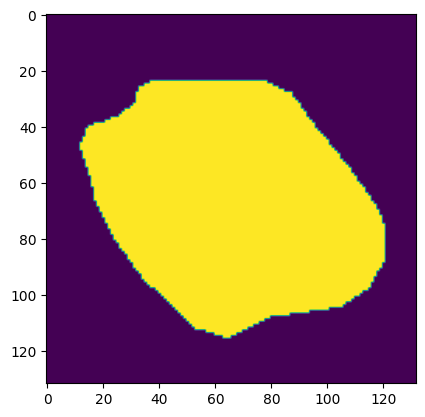

(132, 132) (2, 132, 132)
[(4, 19622, 3880), (3, 280, 0), (2, 234, 3084), (14, 126, 1402), (0, 120, 1956), (5, 86, 0), (13, 52, 672), (1, 50, 764), (11, 38, 1268), (7, 8, 294), (12, 6, 248), (8, 4, 66), (6, 4, 260), (16, 4, 98), (9, 4, 42), (18, 2, 20)]
HT565B1-H2


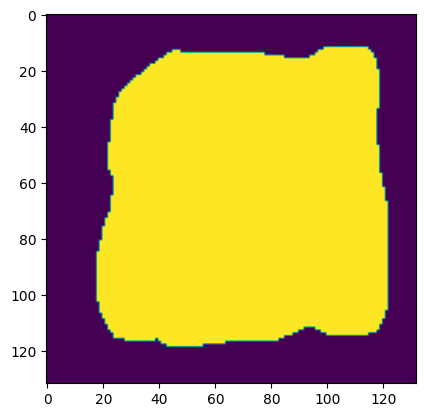

(132, 132) (3, 132, 132)
[(0, 19692, 7200), (4, 2211, 6651), (1, 579, 0)]
HT268B1


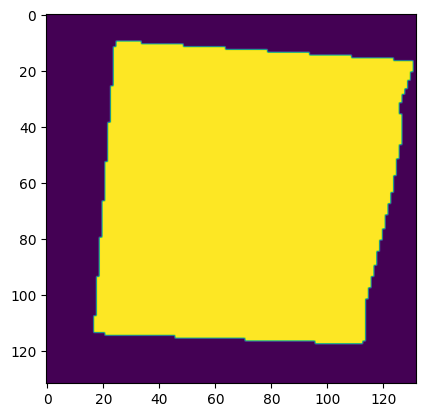

(132, 132) (32, 132, 132)
[(9, 98824, 16573), (5, 55456, 60409), (10, 51360, 1720), (0, 6999, 11083), (8, 5920, 25745), (3, 2085, 20405), (2, 715, 81215), (6, 603, 31021), (1, 333, 9471), (4, 331, 68278), (13, 125, 1506), (11, 48, 6233), (7, 17, 1028)]
HT397B1


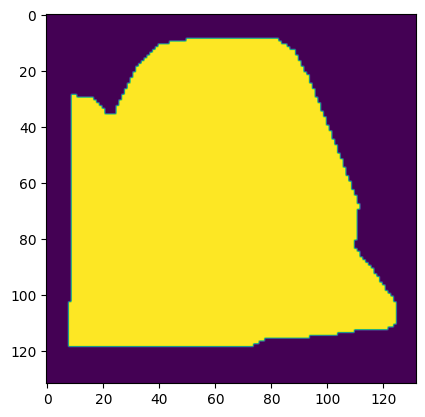

(132, 132) (31, 132, 132)
[(0, 220209, 108689), (15, 2881, 40690), (16, 1569, 17481), (12, 242, 10310), (11, 192, 11198), (1, 183, 8891), (2, 146, 5359), (3, 137, 22110), (8, 121, 943), (7, 105, 13162), (6, 101, 11422), (13, 39, 8304), (10, 34, 8040)]
HT206B1


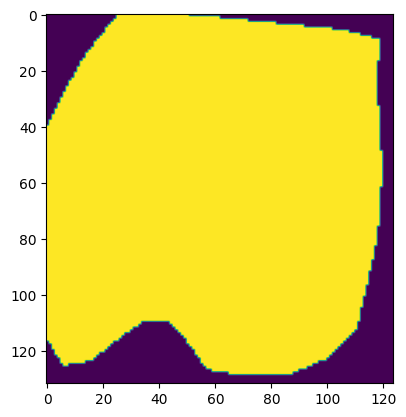

(132, 124) (25, 132, 124)
[(13, 57803, 108014), (15, 13375, 10017), (10, 22, 101822)]
C3L-01287


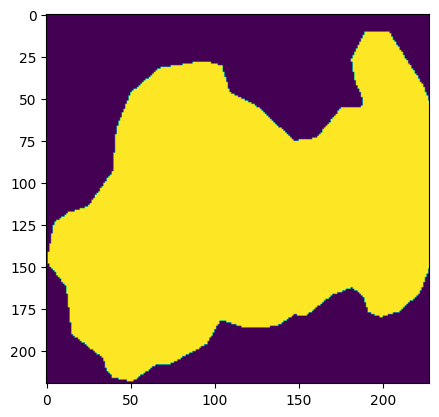

(220, 228) (2, 220, 228)
[(4, 41016, 19318), (10, 4, 2614), (14, 2, 3694)]
C3L-00982


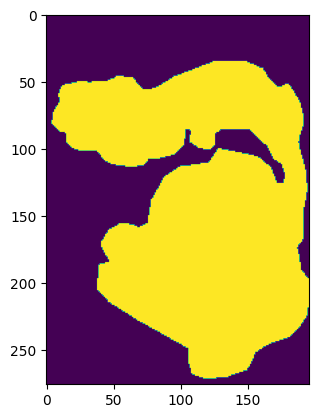

(276, 196) (7, 276, 196)
[(0, 168329, 64531), (33, 8183, 18473), (3, 819, 28650), (32, 511, 9912)]
C3L-02551


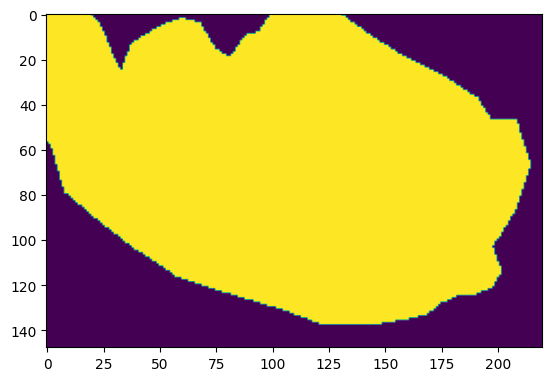

(148, 220) (8, 148, 220)
[(3, 83140, 33730), (10, 4, 176)]
HT413C1-K2


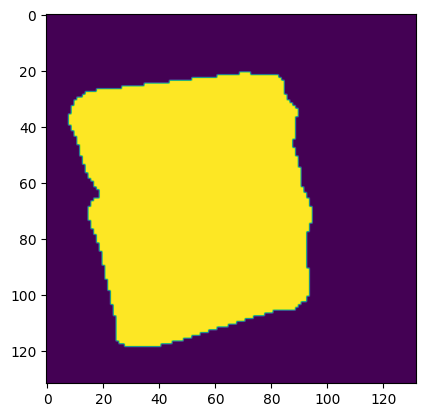

(132, 132) (2, 132, 132)
[(5, 21442, 2196), (12, 82, 0), (13, 44, 0)]
HT225C1


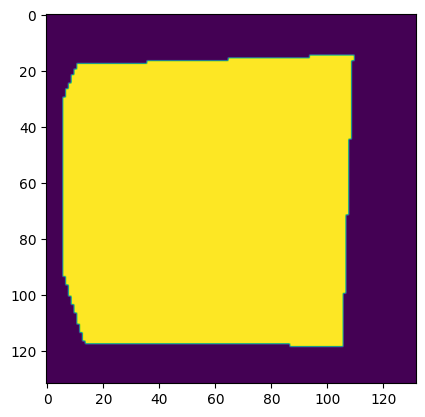

(132, 132) (37, 132, 132)
[(0, 217623, 52301), (4, 38877, 6568), (8, 3041, 42193), (3, 2374, 66155), (6, 1417, 43218), (7, 973, 36309), (2, 933, 9001), (9, 850, 28477), (1, 661, 30799), (5, 521, 24091), (12, 200, 12216), (13, 180, 7219), (11, 167, 13685), (10, 94, 3763), (14, 6, 776)]
HT448C1-Th1K1Fp1


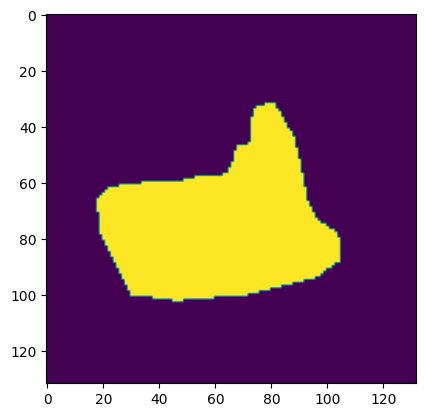

(132, 132) (14, 132, 132)
[(11, 181131, 10861), (4, 5284, 1282), (9, 3910, 13348), (1, 1352, 4106), (8, 486, 4448), (3, 481, 2282), (5, 443, 4649), (0, 247, 5970), (10, 210, 565), (12, 102, 256), (13, 52, 559), (7, 28, 1687), (2, 20, 125)]
HT413C1-Th1k4A1


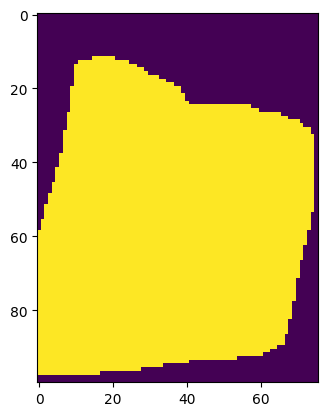

(100, 76) (42, 100, 76)
[(0, 90256, 63296), (16, 12516, 4286), (9, 2, 36142)]
HT553P1-H2


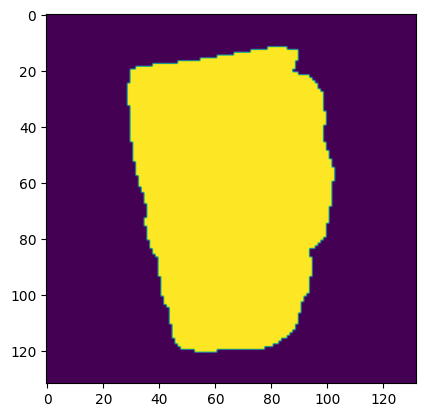

(132, 132) (2, 132, 132)
[(0, 22150, 2366), (1, 28, 0), (26, 2, 666)]
S18-9906


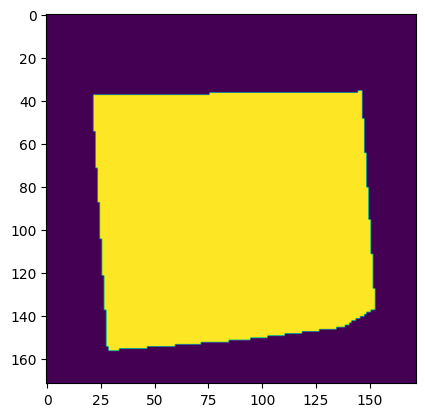

(172, 172) (33, 172, 172)
[(14, 204336, 9298), (7, 200739, 77023), (10, 40386, 52907), (3, 16908, 91570), (2, 11537, 58320), (1, 8004, 34029), (5, 7800, 52302), (13, 5147, 21593), (0, 4806, 32213), (6, 3087, 20358), (4, 1944, 16065), (12, 995, 1779), (8, 374, 853), (9, 237, 324), (11, 67, 236), (17, 37, 178), (19, 36, 234), (15, 20, 121), (18, 12, 157), (20, 6, 110), (16, 6, 118)]
S18-5591-C8


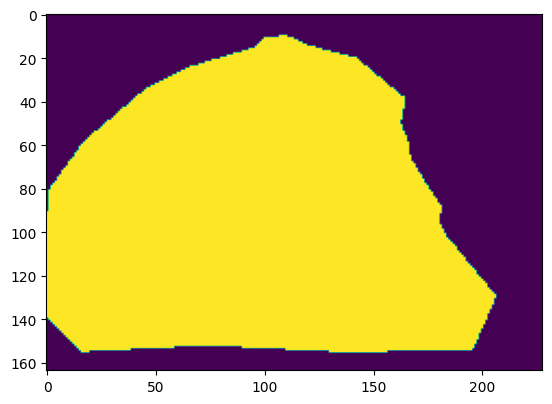

(164, 228) (24, 164, 228)
[(54, 325962, 81521), (31, 14754, 63980), (0, 9051, 121028), (30, 4948, 65577), (33, 593, 17453), (27, 550, 663), (9, 441, 76106), (26, 375, 1229), (11, 343, 561), (3, 218, 8052), (32, 180, 4), (1, 81, 22002), (25, 79, 2989), (34, 20, 31524), (4, 14, 14453), (7, 6, 2722), (10, 4, 118), (5, 3, 8502), (12, 2, 994)]


In [15]:
from collections import Counter
for case in case_order:
    print(case)
    v = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb'))['labeled']['integrated']
    
    mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
    tissue_mask = tifffile.imread(mask_fp)
    target_size  = v.shape[1:]
    tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
    plt.imshow(tissue_mask)
    plt.show()
    
    mask_counts = Counter(v[..., ~tissue_mask].flatten())
    other_counts = Counter(v[..., tissue_mask].flatten())
    
    print(tissue_mask.shape, v.shape)
    print([(c, val, other_counts[c]) for c, val in mask_counts.most_common()])
    
    


In [16]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
case_to_background = {
    'HT339B2-H1': [4, 3],
    'HT565B1-H2': [0],
    'HT268B1': [9],
    'HT397B1': [0],
    'HT206B1': [13],
    'C3L-01287': [4],
    'C3L-00982': [0],
    'C3L-02551': [3],
    'HT413C1-K2': [5],
    'HT225C1': [0],
    'HT448C1-Th1K1Fp1': [11],
    'HT413C1-Th1k4A1': [0, 16],
    'HT553P1-H2': [0],
    'S18-9906': [14],
    'S18-5591-C8': [54]
}

In [18]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/outputs.pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/ou

In [19]:
# for case in case_order:
#     print(case)
#     config = yaml.safe_load(open(os.path.join(project_dir, case, 'mushroom_50res', 'config.yaml')))
#     config['trainer_kwargs']['pct_expression'] = None # make sure we get all visium genes
#     config['dtype_to_chkpt'] = None

#     mushroom = Mushroom.from_config(
#         config, accelerator='cpu'
#     )
#     mushroom.embed_sections()
    
    
    
#     to_true_pixels = {}
#     target_size = None
#     for dtype, spore in mushroom.dtype_to_spore.items():
#         target_size = spore.true_pixels[0].shape[:-1]
#         print(dtype, target_size, spore.true_pixels[0].shape)
#         to_true_pixels[dtype] = {
#             'channels': spore.learner_data.dtype_to_channels[dtype],
#             'true_pixels': spore.true_pixels
#         }
#     print(target_size)
    
#     pickle.dump(to_true_pixels,
#                 open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'wb'), protocol=4)
#     del(to_true_pixels)
    
    
#     to_true_pixels = {}
#     for dtype, spore in mushroom.dtype_to_spore.items():
#         sids = [x for x, _ in spore.section_ids]
#         to_img = spore.learner_data.dtype_to_section_to_img[dtype]
#         imgs = [to_img[sid] for sid in sids]
#         print(dtype, len(imgs), imgs[0].shape)
#         imgs = [utils.rescale(x, size=target_size, dim_order='c h w', target_dtype=x.dtype) for x in imgs]
#         print(dtype, len(imgs), imgs[0].shape)
#         imgs = [rearrange(x, 'c h w -> h w c').numpy() for x in imgs]
        
#         to_true_pixels[dtype] = {
#             'channels': spore.learner_data.dtype_to_channels[dtype],
#             'true_pixels': imgs
#         }
    
#     pickle.dump(to_true_pixels,
#                 open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels_raw.pkl'), 'wb'), protocol=4)

In [20]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/true_pixels_raw.pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/true_pixels_raw.pkl',


In [21]:
fps = sorted(utils.listfiles(project_dir, regex=r'cytospace_.*/outputs/cell_type_assignments_by_spot.csv$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section1/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section2/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section3/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium

In [22]:
df = pd.read_csv(fps[0], sep=',', index_col=0)
df

T_reg  Pericyte   T  Tumor  Proximal_tubule  Macrophage  \
SpotID                                                               
h55_w102       4         0  15      0                0           0   
h164_w75       0        11   0      0                0           0   
h236_w165      0         0  38      0                0           0   
h180_w162      0         0   0     23                0           0   
h186_w174      0         0   0      1               10           0   
...          ...       ...  ..    ...              ...         ...   
h54_w17        0         1   0      0                0           0   
h79_w61        0         0   0      0                0           0   
h58_w147       0         1   0      0                0           0   
h153_w162      0         0   0      0                1           0   
h148_w189      1         0   0      0                0           0   

           Endothelial  Doublet  Fibroblast  Loop_of_Henle  B  pDC  NK  Mast  \
SpotID                                                                         
h55_w102             1        2           4              0  0    0   0     0   
h164_w75            19        0           0              0  0    0   0     0   
h236_w165            0        0           0              0  0    0   4     0   
h180_w162            0        0           0              0  0    0   0     0   
h186_w174            0        0           4              6  0    0   0     0   
...                ...      ...         ...            ... ..  ...  ..   ...   
h54_w17              0        0           0              0  0    0   0     0   
h79_w61              0        0           4              0  0    0   0     0   
h58_w147             0        0           0              0  0    0   0     0   
h153_w162            0        0           0              0  0    0   0     0   
h148_w189            0        0           0              0  0    0   0     0   

           Total cells  
SpotID                  
h55_w102            26  
h164_w75            30  
h236_w165           42  
h180_w162           23  
h186_w174           21  
...                ...  
h54_w17              1  
h79_w61              4  
h58_w147             1  
h153_w162            1  
h148_w189            1  

[22433 rows x 15 columns]

In [23]:
cell_type_mapping = {
    'LumHR': 'Epithelial',
    'Tumor': 'Epithelial',
    'LumSec': 'Epithelial',
    'Basal': 'Epithelial',
    'Ductal': 'Epithelial',
    'Basal_Epithelium': 'Epithelial',
    'Luminal_Epithelium': 'Epithelial',
    'Luminal_Tumor': 'Epithelial',
    'Myeloid': 'Macrophage',
    'Smooth_Muscle_Cells_Fibroblast_Mix': 'Fibroblast',
    'T_NK': 'T_cell',
    'T': 'T_cell',
    'B': 'B_cell',
    'Islet_alpha': 'Islet',
    'Islet_beta': 'Islet',
    'Islet_delta': 'Islet',
    'Islet_gamma': 'Islet',
}
excluded_cell_types = [
    'Doublet',
    'Remove_Unknown',
    'Plasma',
    'Schwann',
#     'Club_Cells',
#     'Hillock_Cells'
]

In [24]:
# case = 'HT206B1'
case_to_cytospace = {}
for case in case_order:
    outputs = pickle.load(open(os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb'))
    sids = outputs['section_ids']
    size = next(iter(outputs['dtype_to_clusters'].values()))[0].shape[1:]

    sid_to_cytospace = {}
    dtype_to_count = {dt:0 for dt in set([x for _, x in sids])}
    channels = []
    for sid, dtype in sids:
        if dtype in ['visium', 'xenium']:
            count = dtype_to_count[dtype]
            fp = os.path.join(project_dir, case, f'cytospace_{dtype}_section{count}', 'outputs', 'cell_type_assignments_by_spot.csv')
            df = pd.read_csv(fp, sep=',', index_col=0)
            df = df.iloc[:, :-1] # dont need total cells
            
            df = df[[c for c in df.columns if c not in excluded_cell_types]]
            renamed = [cell_type_mapping.get(c, c) for c in df.columns]
            count_dict = {}
            for ct in sorted(set(renamed)):
                idxs = [i for i, x in enumerate(renamed) if x == ct]
                count_dict[ct] = df.values[:, idxs].sum(1)
            merged = pd.DataFrame.from_dict(count_dict)
            merged.index = df.index.to_list()
            merged.columns = sorted(set(renamed))

            tiled = np.zeros((size[0], size[1], merged.shape[1]), dtype=int)
            for i, spotid in enumerate(merged.index.to_list()):
                h = int(re.sub(r'^h([0-9]+).*$', r'\1', spotid))
                w = int(re.sub(r'^.*w([0-9]+)$', r'\1', spotid))
                tiled[h, w] = merged.values[i]

            sid_to_cytospace[(sid, dtype)] = tiled
            channels = list(merged.columns)

            dtype_to_count[dtype] += 1
    case_to_cytospace[case] = {
        'sid_to_cytospace': sid_to_cytospace,
        'channels': channels
    }

In [25]:
for case, d in case_to_cytospace.items():
    sid_to_cytospace = d['sid_to_cytospace']
    channels = d['channels']
    print(case, channels)


HT339B2-H1 ['Adipocyte', 'B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Mast', 'Pericyte', 'T_cell', 'pDC']
HT565B1-H2 ['Adipocyte', 'B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Mast', 'Pericyte', 'T_cell', 'pDC']
HT268B1 ['Adipocyte', 'B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Mast', 'Pericyte', 'T_cell', 'pDC']
HT397B1 ['Adipocyte', 'B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Mast', 'Pericyte', 'T_cell', 'pDC']
HT206B1 ['Adipocyte', 'B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Mast', 'Pericyte', 'T_cell', 'pDC']
C3L-01287 ['B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Loop_of_Henle', 'Macrophage', 'Mast', 'NK', 'Pericyte', 'Proximal_tubule', 'T_cell', 'T_reg', 'pDC']
C3L-00982 ['B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Loop_of_Henle', 'Macrophage', 'Mast', 'NK', 'Pericyte', 'Proximal_tubule', 'T_cell', 'T_reg', 'pDC']
C3L-02551 ['B_cell', 'Endothelia

In [26]:
def show_cytospace(case, show_channels=None):
    sid_to_cytospace = case_to_cytospace[case]['sid_to_cytospace']
    channels = case_to_cytospace[case]['channels']

    if show_channels is None:
        show_channels = channels

    nrows, ncols = len(sid_to_cytospace), len(show_channels)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols, nrows))
    if nrows == 1:
        axs = rearrange(axs, 'c -> 1 c')
    if ncols == 1:
        axs = rearrange(axs, 'c -> c 1')

    for i, ((sid, dtype), tiled) in enumerate(sid_to_cytospace.items()):
        for j, channel in enumerate(show_channels):
            ax = axs[i, j]
            img = tiled[..., channels.index(channel)]
            ax.imshow(img)
            if i==0: ax.set_title(channel)
            if j==0: ax.set_ylabel(dtype)
            ax.set_xticks([])
            ax.set_yticks([])

HT339B2-H1


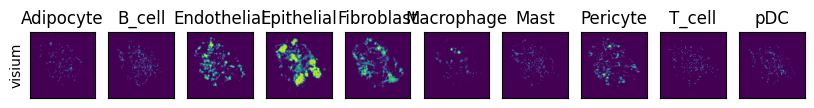

HT565B1-H2


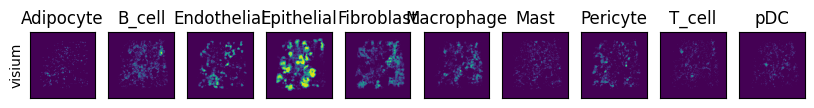

HT268B1


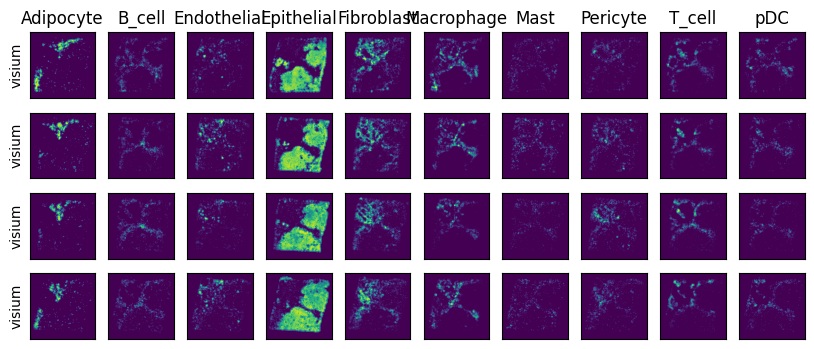

HT397B1


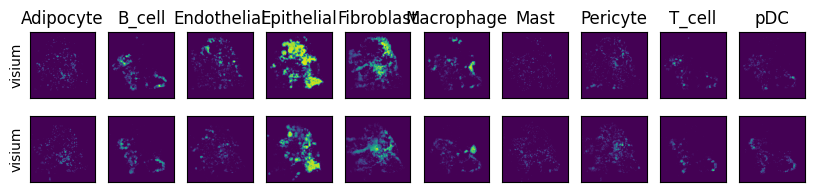

HT206B1


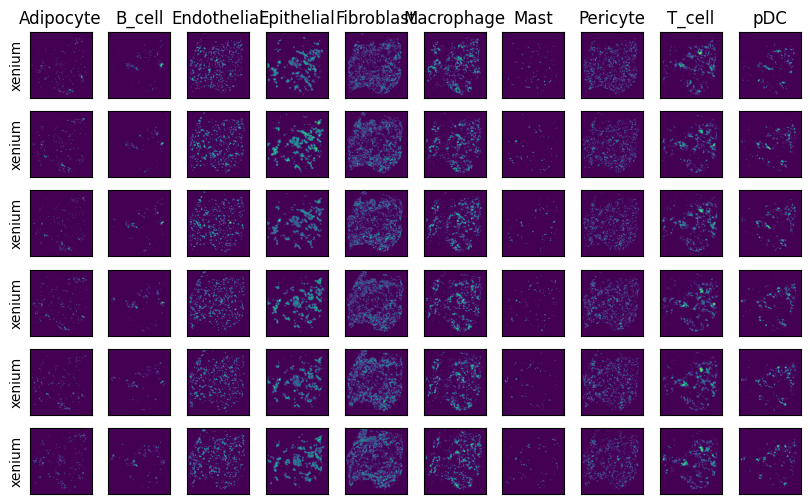

C3L-01287


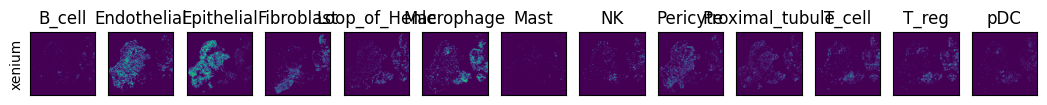

C3L-00982


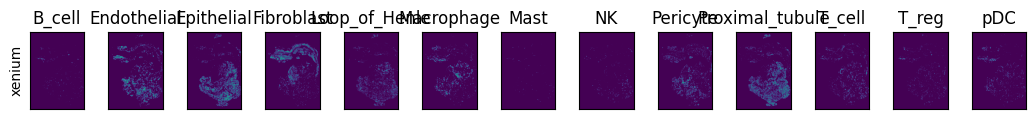

C3L-02551


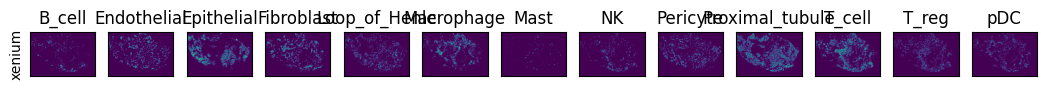

HT413C1-K2


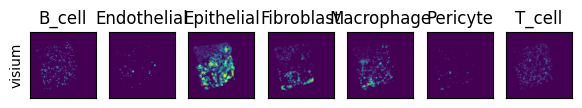

HT225C1


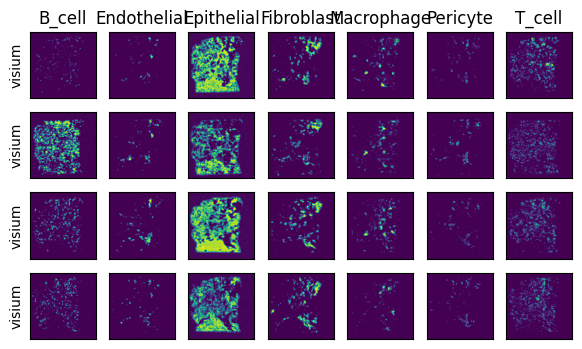

HT448C1-Th1K1Fp1


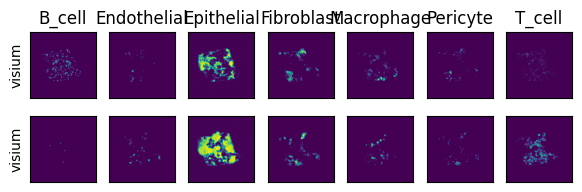

HT413C1-Th1k4A1


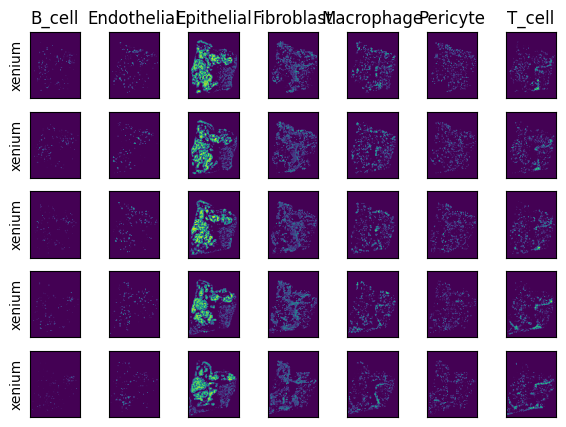

HT553P1-H2


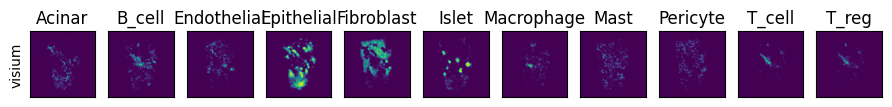

S18-9906


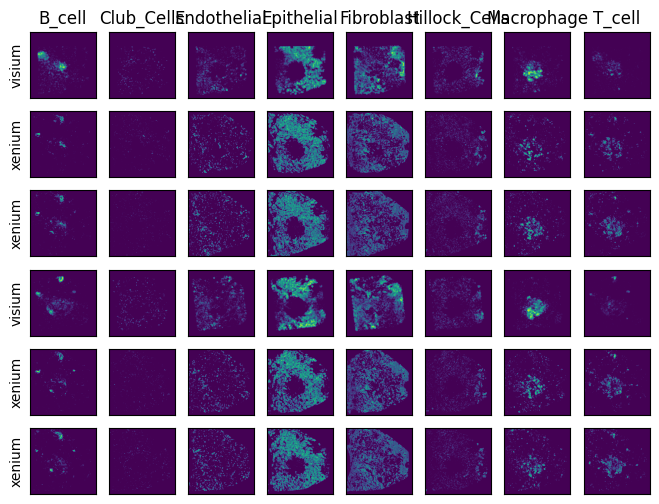

S18-5591-C8


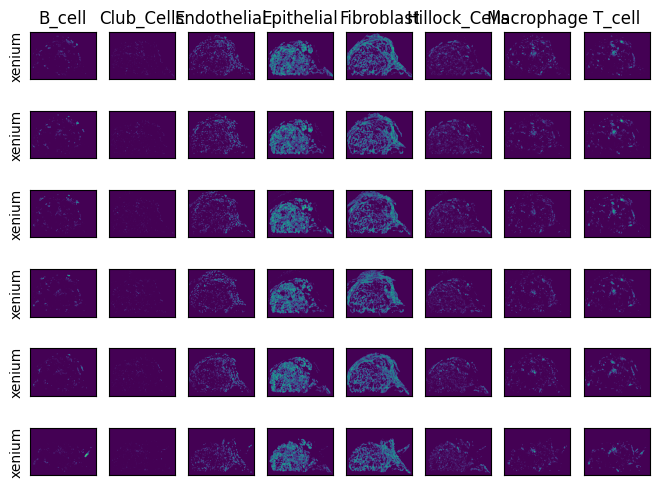

In [27]:
for case in case_order:
    print(case)
    show_cytospace(case)
    plt.show()

In [28]:
case_to_exp = {}
for case in case_order:
    print(case)
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels_raw.pkl'), 'rb')
    )
    
    dtypes = [dt for dt in dtype_to_true_pixels.keys() if dt != 'integrated']
    dtype_to_exp = {}
    for dtype in dtypes:    
        channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
        true_pixels = np.stack(true_pixels)
        
#         # norm by grid count for visium and xenium
#         if dtype in ['visium', 'xenium', 'cosmx']:
#             true_pixels = rearrange(true_pixels, 'n h w c -> n c h w')
#             true_pixels /= (true_pixels.sum((0, 1)) + 1)
#             true_pixels = rearrange(true_pixels, 'n c h w -> n h w c')

        volume = pickle.load(
            open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
        )['labeled']['integrated']

        outputs = pickle.load(
            open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
        )
        section_ids = outputs['section_ids']
        section_positions = outputs['section_positions']
        positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if dt==dtype]
        volume = volume[positions]
        
        print(volume.shape, true_pixels.shape)
        data = []
        for label in np.unique(volume):
            data.append(true_pixels[volume==label].mean(0))
        exp_df = pd.DataFrame(data=data, columns=channels, index=np.unique(volume))
        dtype_to_exp[dtype] = exp_df
    
    case_to_exp[case] = dtype_to_exp
    
    

HT339B2-H1
(1, 132, 132) (1, 132, 132, 3)
(1, 132, 132) (1, 132, 132, 33)
(1, 132, 132) (1, 132, 132, 17943)
HT565B1-H2
(1, 132, 132) (1, 132, 132, 3)
(1, 132, 132) (1, 132, 132, 33)
(1, 132, 132) (1, 132, 132, 17943)
HT268B1
(4, 132, 132) (4, 132, 132, 3)
(4, 132, 132) (4, 132, 132, 36601)
HT397B1
(6, 132, 132) (6, 132, 132, 3)
(2, 132, 132) (2, 132, 132, 3)
(4, 132, 132) (4, 132, 132, 24)
(2, 132, 132) (2, 132, 132, 17943)
HT206B1
(3, 132, 124) (3, 132, 124, 3)
(6, 132, 124) (6, 132, 124, 36)
(6, 132, 124) (6, 132, 124, 377)
C3L-01287
(1, 220, 228) (1, 220, 228, 29)
(1, 220, 228) (1, 220, 228, 477)
C3L-00982
(1, 276, 196) (1, 276, 196, 3)
(3, 276, 196) (3, 276, 196, 32)
(1, 276, 196) (1, 276, 196, 477)
C3L-02551
(1, 148, 220) (1, 148, 220, 3)
(3, 148, 220) (3, 148, 220, 32)
(1, 148, 220) (1, 148, 220, 477)
HT413C1-K2
(1, 132, 132) (1, 132, 132, 3)
(1, 132, 132) (1, 132, 132, 33)
(1, 132, 132) (1, 132, 132, 17943)
HT225C1
(4, 132, 132) (4, 132, 132, 3)
(4, 132, 132) (4, 132, 132, 3660

In [29]:
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [30]:
# masking_dtype_order = [
#     'xenium',
#     'visium',
# ]

HT339B2-H1
26


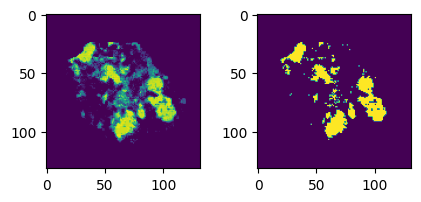

HT565B1-H2
31


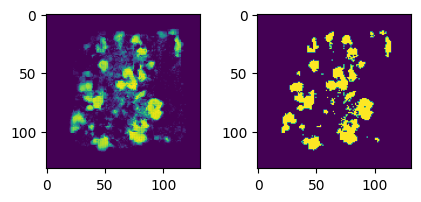

HT268B1
26
25
26
26


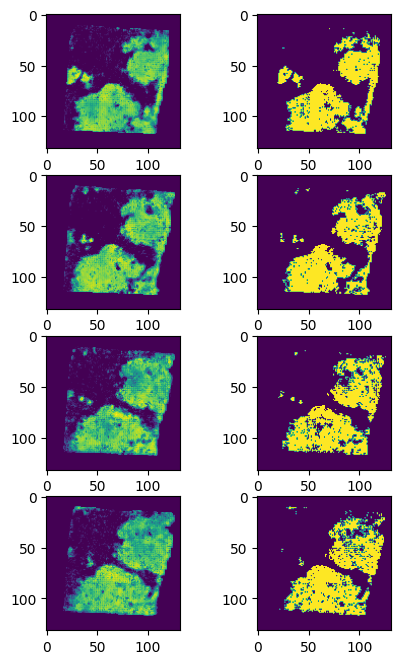

HT397B1
29
40


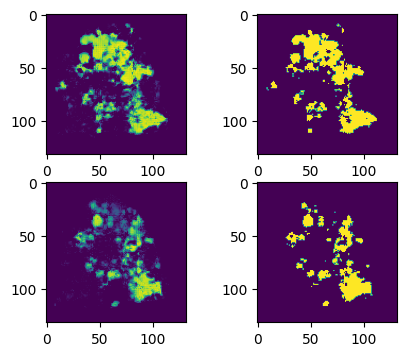

HT206B1
52
44
59
50
55
52


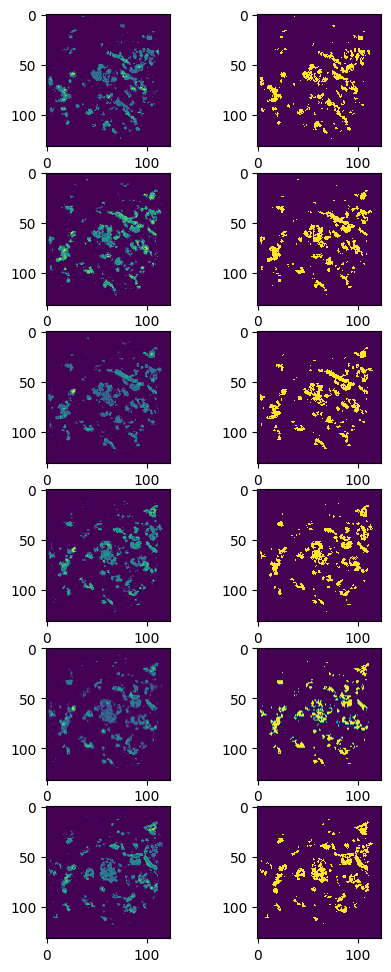

C3L-01287
25


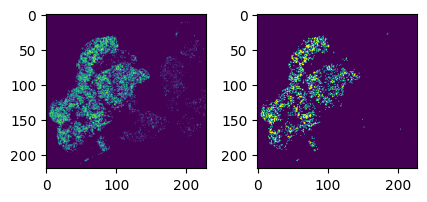

C3L-00982
30


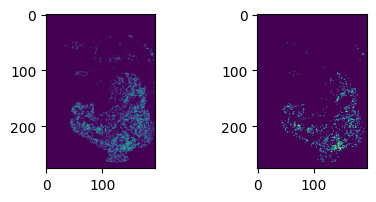

C3L-02551
23


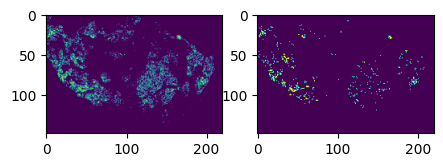

HT413C1-K2
32


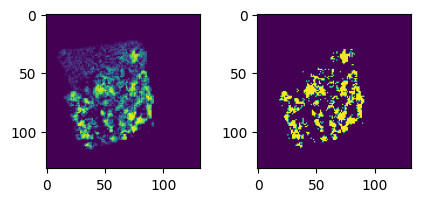

HT225C1
40
39
40
42


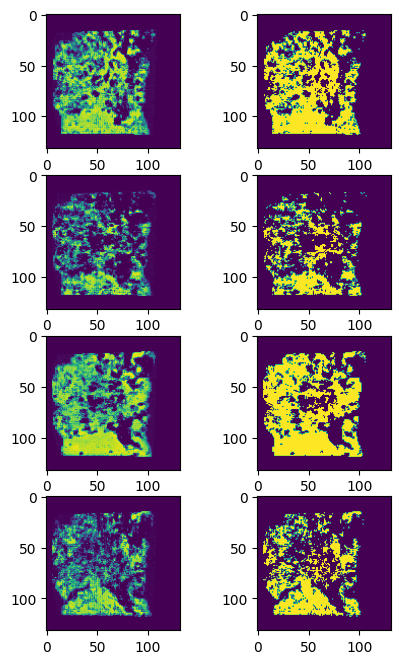

HT448C1-Th1K1Fp1
99
97


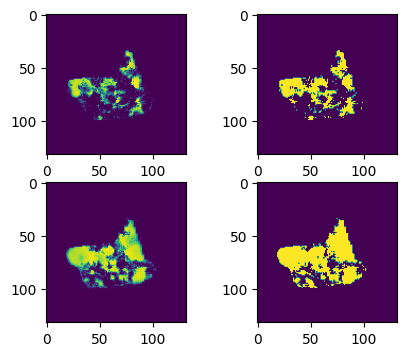

HT413C1-Th1k4A1
33
34
34
37
39


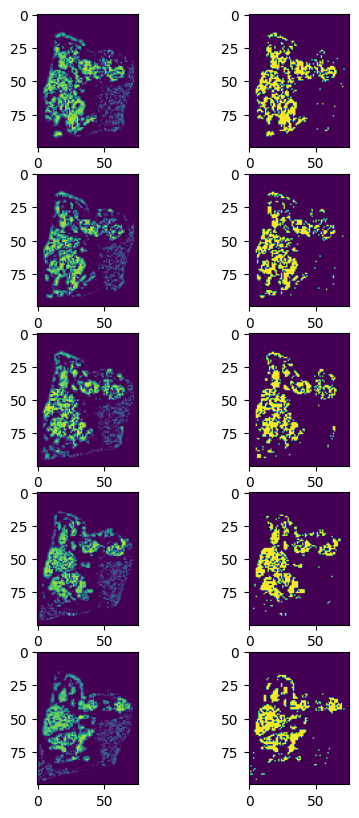

HT553P1-H2
31


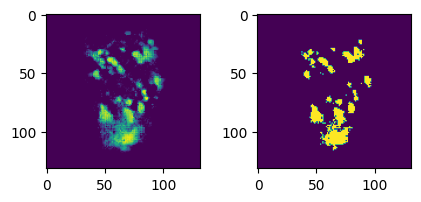

S18-9906
38
32
33
35
32
32


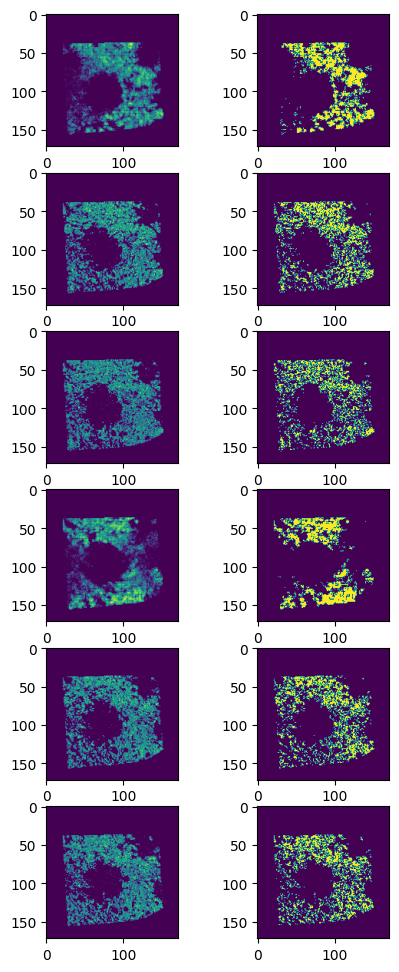

S18-5591-C8
36
36
35
39
35
35


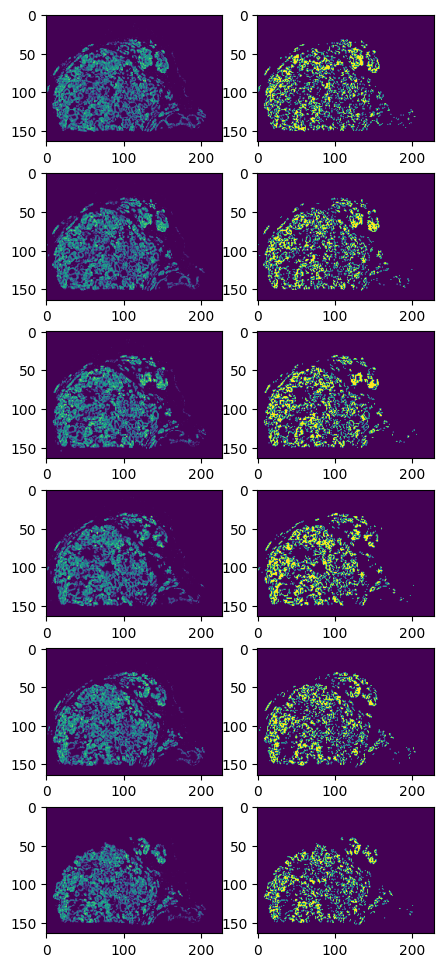

In [31]:
case_to_tumor_mask = {}
for case in case_order:
    print(case)

    section_ids = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb')
    )['section_ids']
    sid_to_cytospace = case_to_cytospace[case]['sid_to_cytospace']
    channels = case_to_cytospace[case]['channels']
    section_ids = [x for x in section_ids if x in sid_to_cytospace]    
    
    mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
    tissue_mask = tifffile.imread(mask_fp)
    target_size  = next(iter(sid_to_cytospace.values())).shape[:2]
    tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
    
    thresh = 15
    
    nrows = len(section_ids)
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(5, nrows * 2))
    if nrows == 1:
        axs = rearrange(axs, 'n -> 1 n')
    
    masks = []
    for i, section_id in enumerate(section_ids):
        tiled = sid_to_cytospace[section_id]
        img = tiled[..., channels.index('Epithelial')]
        img[~tissue_mask] = img.min()
#         fracs = tiled / tiled.sum((0, 1))
#         img = fracs[..., channels.index('Epithelial')]
#         img[~tissue_mask] = img.min()
#         img = skimage.filters.gaussian(img)
        print(img.max())
        axs[i, 0].imshow(img)
        axs[i, 1].imshow(img > thresh)
        masks.append(img > thresh)
    plt.show()
    
    tumor_mask = np.stack(masks)
    
    case_to_tumor_mask[case] = tumor_mask


    

In [32]:
outputs = pickle.load(
    open(os.path.join(project_dir, 'HT397B1', 'mushroom_50res', f'outputs.pkl'), 'rb')
)
outputs.keys()


dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [326]:
# case_to_true_slice = {}
case_to_labeled_slice = {}
for case in case_order:
    print(case)
#     dtype_to_true_pixels = pickle.load(
#         open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
#     )
    
#     dtype = [dt for dt in masking_dtype_order if dt in dtype_to_true_pixels][0]
#     channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
#     true_pixels = true_pixels[0]
    
    volume = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
    )['labeled']['integrated']
    print(volume.shape)
    labeled = volume[0]
    
    if case == 'HT413C1-Th1k4A1':
        labeled = volume[30]
    
#     case_to_true_slice[case] = true_pixels
    case_to_labeled_slice[case] = labeled

HT339B2-H1
(2, 132, 132)
HT565B1-H2
(3, 132, 132)
HT268B1
(32, 132, 132)
HT397B1
(31, 132, 132)
HT206B1
(25, 132, 124)
C3L-01287
(2, 220, 228)
C3L-00982
(7, 276, 196)
C3L-02551
(8, 148, 220)
HT413C1-K2
(2, 132, 132)
HT225C1
(37, 132, 132)
HT448C1-Th1K1Fp1
(14, 132, 132)
HT413C1-Th1k4A1
(42, 100, 76)
HT553P1-H2
(2, 132, 132)
S18-9906
(33, 172, 172)
S18-5591-C8
(24, 164, 228)


In [233]:
def get_nbhd_rgb(case, nbhds, cmap=None):
    labeled = case_to_labeled_slice[case]
    
    mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
    tissue_mask = tifffile.imread(mask_fp)
    target_size  = labeled.shape
    tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
    labeled[~tissue_mask] = 0
    
    rgb = vis_utils.display_labeled_as_rgb(labeled, cmap=cmap)
    
    m = np.zeros_like(labeled, dtype=bool)
    for l in nbhds:
        m |= labeled==l
    
    rgb[~m] = 0.
    
    return rgb



def get_intensity_img(case, dtype, gene):
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
    )
    
    channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
    true_pixels = true_pixels[0]
    
    img = true_pixels[..., channels.index(gene)]
    
    return img


In [35]:
case_to_contact_counts = {}
case_to_tumor_counts = {}
case_to_overall_counts = {}
for case in case_order:
    print(case)
    sid_to_cytospace = case_to_cytospace[case]['sid_to_cytospace']
    channels = case_to_cytospace[case]['channels']
    
    volume = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
    )['labeled']['integrated']
    
    outputs = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
    )
    section_ids = outputs['section_ids']
    section_positions = outputs['section_positions']
#     dtypes = sorted(set([v for _, v in section_ids]))
    
#     dtype = [dt for dt in masking_dtype_order if dt in dtypes][0]

    positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if (sid, dt) in sid_to_cytospace]
    volume = volume[positions]
    
    tumor_mask = case_to_tumor_mask[case]
    
    assert volume.shape[0] == tumor_mask.shape[0]
    
    data, labels = [], np.unique(volume)
    counts = Counter()
    tumor_counts = Counter()
    overall_counts = Counter()
    for v, m in zip(volume, tumor_mask):
        expanded = skimage.morphology.binary_dilation(m)
        boundary = expanded ^ m
        counts += Counter(v[boundary])
        tumor_counts += Counter(v[m])
        overall_counts += Counter(v.flatten())
    
    case_to_contact_counts[case] = counts
    case_to_tumor_counts[case] = tumor_counts
    case_to_overall_counts[case] = overall_counts

HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


In [36]:
case_to_contact_counts['HT397B1'], case_to_tumor_counts['HT397B1']

(Counter({4: 269,
          3: 260,
          14: 216,
          5: 139,
          7: 128,
          15: 126,
          12: 107,
          0: 102,
          10: 102,
          1: 65,
          6: 47,
          16: 43,
          11: 42,
          13: 40,
          9: 31,
          2: 29,
          19: 2,
          8: 2,
          18: 1}),
 Counter({4: 1187,
          1: 455,
          3: 349,
          10: 345,
          2: 333,
          5: 284,
          14: 256,
          12: 143,
          15: 109,
          0: 100,
          7: 90,
          9: 68,
          16: 41,
          13: 33,
          6: 18,
          11: 14,
          8: 2}))

In [37]:
gene_sets = json.load(open(os.path.join(project_dir, 'analysis', 'gene_sets', 'c4.3ca.v2023.2.Hs.json')))
gene_sets.keys()

dict_keys(['GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_3_CELL_CYLCE_HMG_RICH', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_4_CHROMATIN', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_5_STRESS', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_7_STRESS_IN_VITRO', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_8_PROTEASOMAL_DEGRADATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_9_UNFOLDED_PROTEIN_RESPONSE', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_14_EMT_3', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_15_EMT_4', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_16_MES_GLIOMA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_18_INTERFERON_MHC_II_2', 'GAVISH_3CA_MALIGNANT_ME

In [38]:
# dtype_to_gene_order = {dtype: set() for dtype in dtype_to_integrated.keys()}
# for dtype, df in dtype_to_integrated.items():
#     dtype_to_gene_order[dtype].update(df.columns)
# dtype_to_gene_order = {k:sorted(v) for k, v in dtype_to_gene_order.items()}


dtype_to_gene_order = {}
for case in case_order:
    dtype_to_integrated = case_to_exp[case]
    for dtype, df in dtype_to_integrated.items():
        if dtype not in dtype_to_gene_order:
            dtype_to_gene_order[dtype] = set()
    dtype_to_gene_order[dtype].update(df.columns)
dtype_to_gene_order = {k:sorted(v) for k, v in dtype_to_gene_order.items()}


dtype_to_exp_df = {dt:None for dt in dtype_to_gene_order}
for case in case_order:
    dtype_to_integrated = case_to_exp[case]
#     dtype_to_integrated = case_to_integrated[case]
    for dtype, df in dtype_to_integrated.items():
        if dtype in dtype_to_gene_order:
            order = dtype_to_gene_order[dtype]
            missing = sorted(set(order) - set(df.columns))
            tail = pd.DataFrame(data=np.full((df.shape[0], len(missing)), df.values.min()))
            tail.columns = missing
            tail.index = df.index
            combined = pd.concat((df, tail), axis=1)
            combined = combined[order]
            combined.index = [(case, nbhd) for nbhd in df.index.to_list()]

            if dtype_to_exp_df[dtype] is None:
                dtype_to_exp_df[dtype] = combined
            else:
                dtype_to_exp_df[dtype] = pd.concat((dtype_to_exp_df[dtype], combined), axis=0)

In [39]:
quant_dtypes = ['xenium', 'visium', 'cosmx']

data = []
exp_data = []
for case in case_order:
    print(case)
#     dtype_to_integrated = case_to_integrated[case]
    dtype_to_integrated = case_to_exp[case]
    dtypes = [qdt for qdt in quant_dtypes if qdt in dtype_to_integrated]
    for quant_dtype in dtypes:
        df = dtype_to_integrated[quant_dtype]
        for name, gs in gene_sets.items():
            genes = [g for g in gs['geneSymbols'] if g in df.columns]
            if len(genes) >= 3:
                nbhd_scores = df[genes].values.mean(1)
                for nbhd, score in zip(df.index.to_list(), nbhd_scores):
                    data.append([case, quant_dtype, name, nbhd, score])

score_df = pd.DataFrame(data, columns=['case', 'dtype', 'gene_set', 'nbhd', 'score'])
score_df


HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


case   dtype                                           gene_set  \
0       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
1       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
2       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
3       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
4       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
...            ...     ...                                                ...   
49787  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49788  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49789  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49790  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49791  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   

       nbhd     score  
0         0  1.493730  
1         1  0.682513  
2         2  0.197669  
3         3  0.193870  
4         4  0.030979  
...     ...       ...  
49787    52  1.071059  
49788    53  1.434338  
49789    54  0.124539  
49790    55  1.630600  
49791    56  1.391970  

[49792 rows x 5 columns]

In [40]:
case_to_background

{'HT339B2-H1': [4, 3],
 'HT565B1-H2': [0],
 'HT268B1': [9],
 'HT397B1': [0],
 'HT206B1': [13],
 'C3L-01287': [4],
 'C3L-00982': [0],
 'C3L-02551': [3],
 'HT413C1-K2': [5],
 'HT225C1': [0],
 'HT448C1-Th1K1Fp1': [11],
 'HT413C1-Th1k4A1': [0, 16],
 'HT553P1-H2': [0],
 'S18-9906': [14],
 'S18-5591-C8': [54]}

In [41]:
df = score_df.copy()
df = df.pivot(columns='gene_set', index=['case', 'dtype', 'nbhd'])
df = df.reset_index()

df = df[[False if nbhd in case_to_background[case] else True for case, nbhd in zip(df['case'], df['nbhd'])]]

df.index = [(case, nbhd) for case, nbhd in zip(df['case'], df['nbhd'])]


df

case   dtype nbhd  \
gene_set                                 
(C3L-00982, 1)  C3L-00982  xenium    1   
(C3L-00982, 2)  C3L-00982  xenium    2   
(C3L-00982, 3)  C3L-00982  xenium    3   
(C3L-00982, 4)  C3L-00982  xenium    4   
(C3L-00982, 5)  C3L-00982  xenium    5   
...                   ...     ...  ...   
(S18-9906, 16)   S18-9906  xenium   16   
(S18-9906, 17)   S18-9906  xenium   17   
(S18-9906, 18)   S18-9906  xenium   18   
(S18-9906, 19)   S18-9906  xenium   19   
(S18-9906, 20)   S18-9906  xenium   20   

                                                                score  \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION   
(C3L-00982, 1)                                           3.296440       
(C3L-00982, 2)                                           3.951151       
(C3L-00982, 3)                                           0.404217       
(C3L-00982, 4)                                           0.435817       
(C3L-00982, 5)                                           5.737449       
...                                                           ...       
(S18-9906, 16)                                                NaN       
(S18-9906, 17)                                                NaN       
(S18-9906, 18)                                                NaN       
(S18-9906, 19)                                                NaN       
(S18-9906, 20)                                                NaN       

                                                                           \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION   
(C3L-00982, 1)                                                NaN           
(C3L-00982, 2)                                                NaN           
(C3L-00982, 3)                                                NaN           
(C3L-00982, 4)                                                NaN           
(C3L-00982, 5)                                                NaN           
...                                                           ...           
(S18-9906, 16)                                                NaN           
(S18-9906, 17)                                                NaN           
(S18-9906, 18)                                                NaN           
(S18-9906, 19)                                                NaN           
(S18-9906, 20)                                                NaN           

                                                          \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1   
(C3L-00982, 1)                                 15.099572   
(C3L-00982, 2)                                  5.810843   
(C3L-00982, 3)                                  2.339755   
(C3L-00982, 4)                                  8.788456   
(C3L-00982, 5)                                  9.765514   
...                                                  ...   
(S18-9906, 16)                                  6.000271   
(S18-9906, 17)                                  5.589149   
(S18-9906, 18)                                  5.502994   
(S18-9906, 19)                                  6.690787   
(S18-9906, 20)                                  6.941039   

                                                          \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2   
(C3L-00982, 1)                                  8.233236   
(C3L-00982, 2)                                  3.899374   
(C3L-00982, 3)                                  1.085053   
(C3L-00982, 4)                                  3.773378   
(C3L-00982, 5)                                  6.320941   
...                                                  ...   
(S18-9906, 16)                                  1.341584   
(S18-9906, 17)                                  1.661936   
(S18-9906, 18)                                  1.493572   
(S18-9906, 19)                                  1.520338   
(S18-9906, 20)       

In [42]:
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [43]:
def score_gene_set(df, gene_set):
    data = []
    order = sorted(gene_set.keys())
    for name in order:
        genes = gene_set[name]
        f = df[[c for c in df.columns if c in genes]]
        data.append(f.values.mean(1).flatten())
    scored = pd.DataFrame(data=data, columns=df.index, index=order).T
    return scored

In [44]:
tiled = case_to_cytospace['HT397B1']['sid_to_cytospace'][('HT397B1-U1', 'visium')]
tiled.shape

(132, 132, 10)

In [45]:
# sums = tiled.sum(-1)
# sums[sums==0] += 1
# tiled /= np.expand_dims(sums, -1)
# tiled

In [46]:
# scoring_order = ['xenium', 'visium']
# case_to_scored = {}
# for case in case_order:
# #     dtype_to_integrated = case_to_integrated[case]
#     dtype_to_integrated = case_to_exp[case]
#     dtype = [dt for dt in scoring_order if dt in dtype_to_integrated][0]
    
#     scored = score_gene_set(dtype_to_integrated[dtype], components)
    
#     scored = scored[[True if x not in case_to_background[case] else False for x in scored.index]]
# #     scored -= np.expand_dims(scored.min(1), -1)
# #     scored /= np.expand_dims(scored.max(1), -1)
# #     scored -= scored.min(1)
# #     scored /= scored.max(1)
    
    
#     case_to_scored[case] = scored
# case_to_scored.keys()

In [47]:
tumor_thresh = .5
contact_thresh = .02

case_to_included = {}
for case in case_order:
    case_to_included[case] = []
    tumor_counts = case_to_tumor_counts[case]
    overall_counts = case_to_overall_counts[case]
    contact_counts = case_to_contact_counts[case]
    
    for nbhd, oc in overall_counts.items():
        tc = tumor_counts[nbhd]
        cc = contact_counts[nbhd]
        
        contact_frac = cc / sum(contact_counts.values())
        tumor_frac = tc / oc
        print(case, nbhd, tumor_frac, contact_frac)
        
        if tumor_frac < tumor_thresh and contact_frac > contact_thresh:
            case_to_included[case].append(nbhd)
case_to_included
        
        
        
    

HT339B2-H1 4 0.01063739256233512 0.20208604954367665
HT339B2-H1 14 0.0549738219895288 0.10299869621903521
HT339B2-H1 2 0.0325497287522604 0.12385919165580182
HT339B2-H1 8 0.11428571428571428 0.001303780964797914
HT339B2-H1 1 0.3759213759213759 0.09256844850065189
HT339B2-H1 6 0.18181818181818182 0.03259452411994785
HT339B2-H1 13 0.3011049723756906 0.0938722294654498
HT339B2-H1 0 0.6868978805394991 0.14341590612777053
HT339B2-H1 11 0.16079632465543645 0.1421121251629726
HT339B2-H1 7 0.19205298013245034 0.027379400260756193
HT339B2-H1 3 0.0 0.0
HT339B2-H1 5 0.0 0.0
HT339B2-H1 12 0.12598425196850394 0.02346805736636245
HT339B2-H1 18 0.09090909090909091 0.002607561929595828
HT339B2-H1 16 0.0 0.001303780964797914
HT339B2-H1 17 0.07407407407407407 0.007822685788787484
HT339B2-H1 15 0.058823529411764705 0.001303780964797914
HT339B2-H1 10 0.5 0.001303780964797914
HT339B2-H1 9 0.21739130434782608 0.0
HT565B1-H2 0 0.015171798304328426 0.1605911330049261
HT565B1-H2 4 0.022004062288422478 0.113300

{'HT339B2-H1': [4, 14, 2, 1, 6, 13, 11, 7, 12],
 'HT565B1-H2': [0, 4, 6, 2, 10, 5],
 'HT268B1': [9, 8, 5],
 'HT397B1': [0, 16, 12, 3, 14, 15, 7, 13, 11, 5, 6],
 'HT206B1': [15, 13, 10, 16, 1, 11, 8, 14, 6, 9],
 'C3L-01287': [4, 7, 9, 15, 11, 18, 13, 17],
 'C3L-00982': [33, 0, 32, 2, 5, 6],
 'C3L-02551': [3, 7, 4, 11, 13, 8, 0, 12],
 'HT413C1-K2': [5, 8, 0, 1, 6, 2],
 'HT225C1': [0, 4, 2, 5, 1, 3],
 'HT448C1-Th1K1Fp1': [11, 9, 8, 4],
 'HT413C1-Th1k4A1': [0, 9, 12, 4, 10, 6, 1, 5, 8, 11],
 'HT553P1-H2': [0, 26, 2, 4, 12, 9, 3, 18, 7, 5, 19, 6],
 'S18-9906': [7, 10, 0, 13, 3, 5, 2, 4, 1],
 'S18-5591-C8': [54, 31, 30, 0, 33, 9, 1, 34, 3, 5]}

In [48]:
case_to_scored = {}
for case in case_order:
    sid_to_cytospace = case_to_cytospace[case]['sid_to_cytospace']
    channels = case_to_cytospace[case]['channels']
    
    volume = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
    )['labeled']['integrated']
    
    outputs = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
    )
    section_ids = outputs['section_ids']
    section_positions = outputs['section_positions']

    
    positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if (sid, dt) in sid_to_cytospace]
    ids = [(sid, dt) for i, (sid, dt) in zip(section_positions, section_ids) if (sid, dt) in sid_to_cytospace]
    volume = volume[positions]
    
    labels = np.unique(volume)
    
    counts = []
    for section_id, labeled in zip(ids, volume):
        tiled = sid_to_cytospace[section_id].astype(float)
        
#         scaler = tiled.std()
#         tiled /= scaler
        
#         sums = tiled.std((0, 1))
#         tiled /= sums
        
#         sums = tiled.sum(-1)
#         sums[sums==0] += 1
#         tiled /= np.expand_dims(sums, -1)

        data = []
        for label in labels:
            m = labeled==label
            n = np.count_nonzero(m)
            if n == 0:
                x = np.asarray([0] * len(channels))
            else:
                x = tiled[m].mean(0)
            data.append(x)
        data = np.stack(data)
        counts.append(data)
    counts = np.stack(counts).mean(0)
    score_df = pd.DataFrame(counts, columns=channels, index=labels)
    
    score_df = score_df.loc[case_to_included[case]]
    
    case_to_scored[case] = score_df

In [49]:
cols = sorted(set([c for case, scored in case_to_scored.items() for c in scored.columns]))
cols

['Acinar',
 'Adipocyte',
 'B_cell',
 'Club_Cells',
 'Endothelial',
 'Epithelial',
 'Fibroblast',
 'Hillock_Cells',
 'Islet',
 'Loop_of_Henle',
 'Macrophage',
 'Mast',
 'NK',
 'Pericyte',
 'Proximal_tubule',
 'T_cell',
 'T_reg',
 'pDC']

In [50]:
common = sorted(set.intersection(*[set(scored.columns) for case, scored in case_to_scored.items()]))
common

['B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'T_cell']

In [51]:
common = [
#     'Epithelial',
    'Fibroblast',
    'Endothelial',
    'Macrophage',
    'T_cell',
    'B_cell',
]

In [52]:
cases = []
dtypes = []
combined = None
for case, scored in case_to_scored.items():
    cases += [case] * len(scored)

#     dtype_to_integrated = case_to_exp[case]
#     dtype = [dt for dt in scoring_order if dt in dtype_to_integrated][0]
#     dtypes += [dtype] * len(scored)
    f = scored[common]

    if combined is None:
        combined = f.copy()
    else:
        combined = pd.concat((combined, f), axis=0)

combined

Fibroblast  Endothelial  Macrophage    T_cell    B_cell
4     0.173177     0.176751    0.008765  0.003149  0.023062
14    3.730366     3.760471    0.409686  0.030105  0.232984
2     7.173599     3.231465    0.418927  0.023508  0.145268
1     2.491400     3.643735    0.511057  0.027027  0.307125
6     2.143939     4.757576    0.810606  0.075758  0.393939
..         ...          ...         ...       ...       ...
9    11.449360     2.414063    0.906808  0.965007  0.471358
1     9.047613     5.086124    2.503533  3.022711  1.364066
34    4.512774     1.981696    1.089184  1.134916  0.410390
3     3.841850     3.836639    6.769121  7.977343  2.341862
5     7.279239     3.738567    1.662142  1.413911  0.552011

[118 rows x 5 columns]

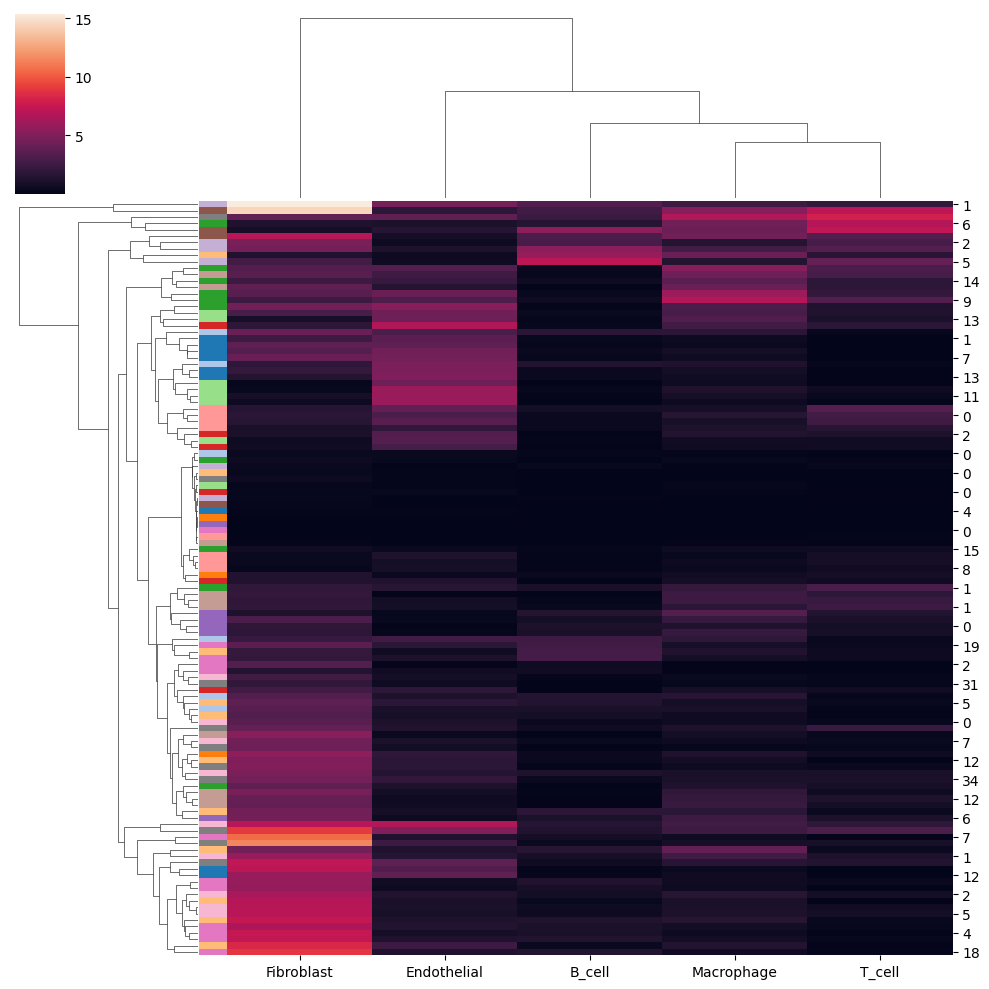

In [53]:
colors = [sns.color_palette('tab20')[case_order.index(z)] for z in cases]
# colors = [sns.color_palette('tab20')[order.index(z)] for z in dtypes]
sns.clustermap(combined, col_cluster=True, row_cluster=True, row_colors=colors)
plt.show()

In [54]:
cuts = [.75, .9, .95]
to_cuts = {}
for c in combined.columns:
    to_cuts[c] = {}
    for cut in cuts:
        val = combined.sort_values(c)[c].to_list()[int(cut * combined.shape[0])]
        to_cuts[c][cut] = val
print(to_cuts)

{'Fibroblast': {0.75: 4.697350230417924, 0.9: 7.173598553345389, 0.95: 8.872881355932204}, 'Endothelial': {0.75: 3.036406806489909, 0.9: 4.516556291390729, 0.95: 5.2317140484672215}, 'Macrophage': {0.75: 2.114691933461072, 0.9: 3.911679559111583, 0.95: 4.422167487684729}, 'T_cell': {0.75: 1.4087494476358815, 0.9: 2.970949312051959, 0.95: 3.3888864136921093}, 'B_cell': {0.75: 1.1196911196911197, 0.9: 2.5243088655862724, 0.95: 3.0481937602627256}}


In [55]:
# contact_thres = .02

agg = []
for case in case_order:
    counts = case_to_contact_counts[case]
    scored = case_to_scored[case]

#     total = sum(counts.values())
#     fracs = {k:v / total for k, v in counts.items()}

#     nbhds, contact_fracs = zip(*sorted([(nbhd, frac) for nbhd, frac in fracs.items()
#                                if frac > contact_thres
#                                if nbhd in scored.index],
#                               key=lambda x:-x[1]))
    nbhds = scored.index.to_list()
    contact_fracs = [case_to_contact_counts[case][x] / sum(case_to_contact_counts[case].values()) for x in nbhds]
    nbhds, contact_fracs = zip(*sorted([(nbhd, frac)
                                        for nbhd, frac in zip(nbhds, contact_fracs)],
                                       key=lambda x: x[1], reverse=True))
    
    exp = scored.loc[list(nbhds), common].copy()

    expanded = exp.copy()
    for cut in cuts:
        vals = np.asarray([to_cuts[c][cut] for c in exp.columns])
        m = exp > vals
        m.columns = [f'{c}_q{cut}' for c in m]
        expanded = pd.concat((expanded, m), axis=1)
    expanded['case'] = case
    expanded['tissue_type'] = case_to_disease[case]
    expanded['contact_frac'] = contact_fracs
    expanded['nbhd'] = [f'nbhd {x}' for x in exp.index.to_list()]
    agg.append(expanded)
agg = pd.concat(agg, axis=0)
agg['range'] = [f'item{x}' for x in np.arange(agg.shape[0])]
agg
    

Fibroblast  Endothelial  Macrophage    T_cell    B_cell  Fibroblast_q0.75  \
4     0.173177     0.176751    0.008765  0.003149  0.023062             False   
11    3.362940     4.384380    0.869832  0.044410  0.416539             False   
2     7.173599     3.231465    0.418927  0.023508  0.145268              True   
14    3.730366     3.760471    0.409686  0.030105  0.232984             False   
13    1.477901     4.964088    0.674033  0.055249  0.364641             False   
..         ...          ...         ...       ...       ...               ...   
54    0.496016     0.138762    0.036540  0.047028  0.033384             False   
33    4.012069     1.345804    1.156200  2.310463  0.602136             False   
1     9.047613     5.086124    2.503533  3.022711  1.364066              True   
5     7.279239     3.738567    1.662142  1.413911  0.552011              True   
3     3.841850     3.836639    6.769121  7.977343  2.341862             False   

    Endothelial_q0.75  Macrophage_q0.75  T_cell_q0.75  B_cell_q0.75  ...  \
4               False             False         False         False  ...   
11               True             False         False         False  ...   
2                True             False         False         False  ...   
14               True             False         False         False  ...   
13               True             False         False         False  ...   
..                ...               ...           ...           ...  ...   
54              False             False         False         False  ...   
33              False             False          True         False  ...   
1                True              True          True          True  ...   
5                True             False          True         False  ...   
3                True              True          True          True  ...   

    Fibroblast_q0.95  Endothelial_q0.95  Macrophage_q0.95  T_cell_q0.95  \
4              False              False             False         False   
11             False              False             False         False   
2              False              False             False         False   
14             False              False             False         False   
13             False              False             False         False   
..               ...                ...               ...           ...   
54             False              False             False         False   
33             False              False             False         False   
1               True              False             False         False   
5              False              False             False         False   
3              False              False              True          True   

    B_cell_q0.95         case  tissue_type  contact_frac     nbhd    range  
4          False   HT339B2-H1         BRCA      0.202086   nbhd 4    item0  
11         False   HT339B2-H1         BRCA      0.142112  nbhd 11    item1  
2          False   HT339B2-H1         BRCA      0.123859   nbhd 2    item2  
14         False   HT339B2-H1         BRCA      0.102999  nbhd 14    item3  
13         False   HT339B2-H1         BRCA      0.093872  nbhd 13    item4  
..           ...          ...          ...           ...      ...      ...  
54         False  S18-5591-C8          PKD      0.082077  nbhd 54  item113  
33         False  S18-5591-C8          PKD      0.039807  nbhd 33  item114  
1          False  S18-5591-C8          PKD      0.038789   nbhd 1  item115  
5          False  S18-5591-C8          PKD      0.025027   nbhd 5  item116  
3          False  S18-5591-C8          PKD      0.021743   nbhd 3  item117  

[118 rows x 25 columns]

In [56]:
nbhd_mapping = {}
r_nbhd_mapping = {}
current_idx = -1
current_case = agg['case'].to_list()[0]
current_pct = 0.

nbhds = []
starts, stops = [], []
for case, nbhd, frac in zip(agg['case'], agg['nbhd'], agg['contact_frac']):
    if case == current_case:
        current_idx += 1
    else:
        current_idx = 0
        current_case = case
        current_pct = 0.
    
    start = current_pct
    stop = start + frac
    current_pct = stop
    
    starts.append(start)
    stops.append(stop)
    
    nbhd_str = f'nbhd {current_idx}'
    nbhds.append(nbhd_str)
    
    if case not in nbhd_mapping:
        nbhd_mapping[case] = {}
    nbhd_mapping[case][nbhd] = nbhd_str
r_nbhd_mapping = {case:{v:k for k, v in mapping.items()} for case, mapping in nbhd_mapping.items()}
    
agg['renamed_nbhd'] = nbhds
agg['start'] = starts
agg['stop'] = stops
agg['nbhd_identifier'] = [f'{case}_{nbhd}' for case, nbhd in zip(agg['case'], agg['nbhd'])]
agg['case_idx']= [-case_order.index(case) for case in agg['case']]
agg

Fibroblast  Endothelial  Macrophage    T_cell    B_cell  Fibroblast_q0.75  \
4     0.173177     0.176751    0.008765  0.003149  0.023062             False   
11    3.362940     4.384380    0.869832  0.044410  0.416539             False   
2     7.173599     3.231465    0.418927  0.023508  0.145268              True   
14    3.730366     3.760471    0.409686  0.030105  0.232984             False   
13    1.477901     4.964088    0.674033  0.055249  0.364641             False   
..         ...          ...         ...       ...       ...               ...   
54    0.496016     0.138762    0.036540  0.047028  0.033384             False   
33    4.012069     1.345804    1.156200  2.310463  0.602136             False   
1     9.047613     5.086124    2.503533  3.022711  1.364066              True   
5     7.279239     3.738567    1.662142  1.413911  0.552011              True   
3     3.841850     3.836639    6.769121  7.977343  2.341862             False   

    Endothelial_q0.75  Macrophage_q0.75  T_cell_q0.75  B_cell_q0.75  ...  \
4               False             False         False         False  ...   
11               True             False         False         False  ...   
2                True             False         False         False  ...   
14               True             False         False         False  ...   
13               True             False         False         False  ...   
..                ...               ...           ...           ...  ...   
54              False             False         False         False  ...   
33              False             False          True         False  ...   
1                True              True          True          True  ...   
5                True             False          True         False  ...   
3                True              True          True          True  ...   

           case  tissue_type  contact_frac     nbhd    range  renamed_nbhd  \
4    HT339B2-H1         BRCA      0.202086   nbhd 4    item0        nbhd 0   
11   HT339B2-H1         BRCA      0.142112  nbhd 11    item1        nbhd 1   
2    HT339B2-H1         BRCA      0.123859   nbhd 2    item2        nbhd 2   
14   HT339B2-H1         BRCA      0.102999  nbhd 14    item3        nbhd 3   
13   HT339B2-H1         BRCA      0.093872  nbhd 13    item4        nbhd 4   
..          ...          ...           ...      ...      ...           ...   
54  S18-5591-C8          PKD      0.082077  nbhd 54  item113        nbhd 5   
33  S18-5591-C8          PKD      0.039807  nbhd 33  item114        nbhd 6   
1   S18-5591-C8          PKD      0.038789   nbhd 1  item115        nbhd 7   
5   S18-5591-C8          PKD      0.025027   nbhd 5  item116        nbhd 8   
3   S18-5591-C8          PKD      0.021743   nbhd 3  item117        nbhd 9   

       start      stop      nbhd_identifier  case_idx  
4   0.000000  0.202086    HT339B2-H1_nbhd 4         0  
11  0.202086  0.344198   HT339B2-H1_nbhd 11         0  
2   0.344198  0.468057    HT339B2-H1_nbhd 2         0  
14  0.468057  0.571056   HT339B2-H1_nbhd 14         0  
13  0.571056  0.664928   HT339B2-H1_nbhd 13         0  
..       ...       ...                  ...       ...  
54  0.661904  0.743981  S18-5591-C8_nbhd 54       -14  
33  0.743981  0.783788  S18-5591-C8_nbhd 33       -14  
1   0.783788  0.822577   S18-5591-C8_nbhd 1       -14  
5   0.822577  0.847604   S18-5591-C8_nbhd 5       -14  
3   0.847604  0.869347   S18-5591-C8_nbhd 3       -14  

[118 rows x 30 columns]

In [57]:
id_order = agg.sort_values(['case_idx', 'contact_frac'], ascending=False)['nbhd_identifier'].to_list()
id_order

['HT339B2-H1_nbhd 4',
 'HT339B2-H1_nbhd 11',
 'HT339B2-H1_nbhd 2',
 'HT339B2-H1_nbhd 14',
 'HT339B2-H1_nbhd 13',
 'HT339B2-H1_nbhd 1',
 'HT339B2-H1_nbhd 6',
 'HT339B2-H1_nbhd 7',
 'HT339B2-H1_nbhd 12',
 'HT565B1-H2_nbhd 5',
 'HT565B1-H2_nbhd 0',
 'HT565B1-H2_nbhd 2',
 'HT565B1-H2_nbhd 4',
 'HT565B1-H2_nbhd 10',
 'HT565B1-H2_nbhd 6',
 'HT268B1_nbhd 5',
 'HT268B1_nbhd 8',
 'HT268B1_nbhd 9',
 'HT397B1_nbhd 3',
 'HT397B1_nbhd 14',
 'HT397B1_nbhd 5',
 'HT397B1_nbhd 7',
 'HT397B1_nbhd 15',
 'HT397B1_nbhd 12',
 'HT397B1_nbhd 0',
 'HT397B1_nbhd 6',
 'HT397B1_nbhd 16',
 'HT397B1_nbhd 11',
 'HT397B1_nbhd 13',
 'HT206B1_nbhd 14',
 'HT206B1_nbhd 9',
 'HT206B1_nbhd 10',
 'HT206B1_nbhd 8',
 'HT206B1_nbhd 15',
 'HT206B1_nbhd 16',
 'HT206B1_nbhd 1',
 'HT206B1_nbhd 13',
 'HT206B1_nbhd 11',
 'HT206B1_nbhd 6',
 'C3L-01287_nbhd 11',
 'C3L-01287_nbhd 9',
 'C3L-01287_nbhd 17',
 'C3L-01287_nbhd 4',
 'C3L-01287_nbhd 7',
 'C3L-01287_nbhd 18',
 'C3L-01287_nbhd 15',
 'C3L-01287_nbhd 13',
 'C3L-00982_nbhd 6',
 'C

In [58]:
common

['Fibroblast', 'Endothelial', 'Macrophage', 'T_cell', 'B_cell']

In [59]:
agg.sort_values([
    'case_idx', 'Fibroblast_q0.75', 'Macrophage_q0.75', 'T_cell_q0.75', 'B_cell_q0.75', 'Endothelial_q0.75'],
    ascending=False)

Fibroblast  Endothelial  Macrophage    T_cell    B_cell  Fibroblast_q0.75  \
2     7.173599     3.231465    0.418927  0.023508  0.145268              True   
12    5.826772     3.826772    0.614173  0.023622  0.204724              True   
11    3.362940     4.384380    0.869832  0.044410  0.416539             False   
14    3.730366     3.760471    0.409686  0.030105  0.232984             False   
13    1.477901     4.964088    0.674033  0.055249  0.364641             False   
..         ...          ...         ...       ...       ...               ...   
33    4.012069     1.345804    1.156200  2.310463  0.602136             False   
31    1.990186     0.616269    0.255510  0.221095  0.055794             False   
0     4.322148     0.730117    0.227604  0.253787  0.098843             False   
34    4.512774     1.981696    1.089184  1.134916  0.410390             False   
54    0.496016     0.138762    0.036540  0.047028  0.033384             False   

    Endothelial_q0.75  Macrophage_q0.75  T_cell_q0.75  B_cell_q0.75  ...  \
2                True             False         False         False  ...   
12               True             False         False         False  ...   
11               True             False         False         False  ...   
14               True             False         False         False  ...   
13               True             False         False         False  ...   
..                ...               ...           ...           ...  ...   
33              False             False          True         False  ...   
31              False             False         False         False  ...   
0               False             False         False         False  ...   
34              False             False         False         False  ...   
54              False             False         False         False  ...   

           case  tissue_type  contact_frac     nbhd    range  renamed_nbhd  \
2    HT339B2-H1         BRCA      0.123859   nbhd 2    item2        nbhd 2   
12   HT339B2-H1         BRCA      0.023468  nbhd 12    item8        nbhd 8   
11   HT339B2-H1         BRCA      0.142112  nbhd 11    item1        nbhd 1   
14   HT339B2-H1         BRCA      0.102999  nbhd 14    item3        nbhd 3   
13   HT339B2-H1         BRCA      0.093872  nbhd 13    item4        nbhd 4   
..          ...          ...           ...      ...      ...           ...   
33  S18-5591-C8          PKD      0.039807  nbhd 33  item114        nbhd 6   
31  S18-5591-C8          PKD      0.147831  nbhd 31  item108        nbhd 0   
0   S18-5591-C8          PKD      0.146484   nbhd 0  item109        nbhd 1   
34  S18-5591-C8          PKD      0.097645  nbhd 34  item112        nbhd 4   
54  S18-5591-C8          PKD      0.082077  nbhd 54  item113        nbhd 5   

       start      stop      nbhd_identifier  case_idx  
2   0.344198  0.468057    HT339B2-H1_nbhd 2         0  
12  0.817471  0.840939   HT339B2-H1_nbhd 12         0  
11  0.202086  0.344198   HT339B2-H1_nbhd 11         0  
14  0.468057  0.571056   HT339B2-H1_nbhd 14         0  
13  0.571056  0.664928   HT339B2-H1_nbhd 13         0  
..       ...       ...                  ...       ...  
33  0.743981  0.783788  S18-5591-C8_nbhd 33       -14  
31  0.000000  0.147831  S18-5591-C8_nbhd 31       -14  
0   0.147831  0.294315   S18-5591-C8_nbhd 0       -14  
34  0.564259  0.661904  S18-5591-C8_nbhd 34       -14  
54  0.661904  0.743981  S18-5591-C8_nbhd 54       -14  

[118 rows x 30 columns]

In [60]:
id_order = agg.sort_values([
    'case_idx', 'Fibroblast_q0.75', 'Macrophage_q0.75', 'T_cell_q0.75', 'B_cell_q0.75', 'Endothelial_q0.75'],
    ascending=False)['nbhd_identifier'].to_list()
id_order

['HT339B2-H1_nbhd 2',
 'HT339B2-H1_nbhd 12',
 'HT339B2-H1_nbhd 11',
 'HT339B2-H1_nbhd 14',
 'HT339B2-H1_nbhd 13',
 'HT339B2-H1_nbhd 1',
 'HT339B2-H1_nbhd 6',
 'HT339B2-H1_nbhd 7',
 'HT339B2-H1_nbhd 4',
 'HT565B1-H2_nbhd 2',
 'HT565B1-H2_nbhd 5',
 'HT565B1-H2_nbhd 10',
 'HT565B1-H2_nbhd 6',
 'HT565B1-H2_nbhd 0',
 'HT565B1-H2_nbhd 4',
 'HT268B1_nbhd 8',
 'HT268B1_nbhd 5',
 'HT268B1_nbhd 9',
 'HT397B1_nbhd 13',
 'HT397B1_nbhd 14',
 'HT397B1_nbhd 15',
 'HT397B1_nbhd 12',
 'HT397B1_nbhd 6',
 'HT397B1_nbhd 11',
 'HT397B1_nbhd 3',
 'HT397B1_nbhd 5',
 'HT397B1_nbhd 7',
 'HT397B1_nbhd 0',
 'HT397B1_nbhd 16',
 'HT206B1_nbhd 6',
 'HT206B1_nbhd 9',
 'HT206B1_nbhd 8',
 'HT206B1_nbhd 11',
 'HT206B1_nbhd 14',
 'HT206B1_nbhd 16',
 'HT206B1_nbhd 1',
 'HT206B1_nbhd 10',
 'HT206B1_nbhd 15',
 'HT206B1_nbhd 13',
 'C3L-01287_nbhd 7',
 'C3L-01287_nbhd 13',
 'C3L-01287_nbhd 11',
 'C3L-01287_nbhd 9',
 'C3L-01287_nbhd 17',
 'C3L-01287_nbhd 18',
 'C3L-01287_nbhd 15',
 'C3L-01287_nbhd 4',
 'C3L-00982_nbhd 5',
 'C

In [61]:
id_order

['HT339B2-H1_nbhd 2',
 'HT339B2-H1_nbhd 12',
 'HT339B2-H1_nbhd 11',
 'HT339B2-H1_nbhd 14',
 'HT339B2-H1_nbhd 13',
 'HT339B2-H1_nbhd 1',
 'HT339B2-H1_nbhd 6',
 'HT339B2-H1_nbhd 7',
 'HT339B2-H1_nbhd 4',
 'HT565B1-H2_nbhd 2',
 'HT565B1-H2_nbhd 5',
 'HT565B1-H2_nbhd 10',
 'HT565B1-H2_nbhd 6',
 'HT565B1-H2_nbhd 0',
 'HT565B1-H2_nbhd 4',
 'HT268B1_nbhd 8',
 'HT268B1_nbhd 5',
 'HT268B1_nbhd 9',
 'HT397B1_nbhd 13',
 'HT397B1_nbhd 14',
 'HT397B1_nbhd 15',
 'HT397B1_nbhd 12',
 'HT397B1_nbhd 6',
 'HT397B1_nbhd 11',
 'HT397B1_nbhd 3',
 'HT397B1_nbhd 5',
 'HT397B1_nbhd 7',
 'HT397B1_nbhd 0',
 'HT397B1_nbhd 16',
 'HT206B1_nbhd 6',
 'HT206B1_nbhd 9',
 'HT206B1_nbhd 8',
 'HT206B1_nbhd 11',
 'HT206B1_nbhd 14',
 'HT206B1_nbhd 16',
 'HT206B1_nbhd 1',
 'HT206B1_nbhd 10',
 'HT206B1_nbhd 15',
 'HT206B1_nbhd 13',
 'C3L-01287_nbhd 7',
 'C3L-01287_nbhd 13',
 'C3L-01287_nbhd 11',
 'C3L-01287_nbhd 9',
 'C3L-01287_nbhd 17',
 'C3L-01287_nbhd 18',
 'C3L-01287_nbhd 15',
 'C3L-01287_nbhd 4',
 'C3L-00982_nbhd 5',
 'C

In [62]:
import altair as alt

In [71]:
# cols = ['case', 'tissue_type', 'renamed_nbhd', 'start', 'stop']
cols = ['nbhd_identifier', 'contact_frac']
source = agg[cols]

c1 = alt.Chart(source).mark_bar().encode(
    x=alt.X("nbhd_identifier", sort=id_order),
    y=alt.Y('contact_frac', scale=alt.Scale(reverse=True)),
#     color=alt.Color('contact_frac').scale(scheme="bluepurple"),
#     column=alt.Column('case', sort=case_order, )
)
c1

alt.Chart(...)

In [72]:
set(agg['nbhd'])

{'nbhd 0',
 'nbhd 1',
 'nbhd 10',
 'nbhd 11',
 'nbhd 12',
 'nbhd 13',
 'nbhd 14',
 'nbhd 15',
 'nbhd 16',
 'nbhd 17',
 'nbhd 18',
 'nbhd 19',
 'nbhd 2',
 'nbhd 26',
 'nbhd 3',
 'nbhd 30',
 'nbhd 31',
 'nbhd 32',
 'nbhd 33',
 'nbhd 34',
 'nbhd 4',
 'nbhd 5',
 'nbhd 54',
 'nbhd 6',
 'nbhd 7',
 'nbhd 8',
 'nbhd 9'}

In [73]:
cmap[0]

'#1f77b4'

In [74]:
agg['nbhd']

4      nbhd 4
11    nbhd 11
2      nbhd 2
14    nbhd 14
13    nbhd 13
       ...   
54    nbhd 54
33    nbhd 33
1      nbhd 1
5      nbhd 5
3      nbhd 3
Name: nbhd, Length: 118, dtype: object

In [75]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
cmap = ['#%02x%02x%02x' %  tuple((np.asarray(x)*255).astype(int)) for x in cmap]
dom = [f'nbhd {x}' for x in np.arange(50)]
rng = cmap[:50]

dom, rng = zip(*[(x, y) for x, y in zip(dom, rng) if x in agg['nbhd'].to_list()])

In [76]:
# cols = ['case', 'tissue_type', 'renamed_nbhd', 'start', 'stop']
cols = ['case', 'nbhd', 'nbhd_identifier', 'contact_frac']
source = agg[cols]

c1 = alt.Chart(source).mark_rect().encode(
    x=alt.X("nbhd_identifier", sort=id_order),
    color=alt.Color('nbhd').scale(domain=dom, range=rng),
#     column=alt.Column('case', sort=)
)
c1

alt.Chart(...)

In [77]:
cols = ['case', 'nbhd', 'nbhd_identifier', 'contact_frac', 'tissue_type']
source = agg[cols]

c1 = alt.Chart(source).mark_rect().encode(
    x=alt.X("nbhd_identifier", sort=id_order),
    color=alt.Color('tissue_type').scale(scheme='category10'),
)
c1

alt.Chart(...)

In [78]:
disease_to_cmap = {
    'BRCA': 'Blues',
    'CCRCC': 'Oranges',
    'CRC': 'Greens',
    'PDAC': 'Reds',
    'PKD': 'Purples',
}
disease_to_n = Counter(case_to_disease.values())

i = 0
rng = []
for case in case_order:
    disease = case_to_disease[case] 
    name = disease_to_cmap[disease]
    colors = sns.color_palette(name, n_colors=disease_to_n[disease])
    color = '#%02x%02x%02x' %  tuple((np.asarray(colors[i])*255).astype(int))
    rng.append(color)
    
    print(i, len(colors)) 
    i += 1
    if i == len(colors):
        i = 0

cols = ['case', 'nbhd', 'nbhd_identifier', 'contact_frac', 'tissue_type']
source = agg[cols]

c1 = alt.Chart(source).mark_rect().encode(
    x=alt.X("nbhd_identifier", sort=id_order),
    color=alt.Color('case').scale(domain=case_order, range=rng),
)
c1

0 5
1 5
2 5
3 5
4 5
0 3
1 3
2 3
0 4
1 4
2 4
3 4
0 1
0 2
1 2


alt.Chart(...)

In [79]:
rng

['#d6e5f4',
 '#abcfe5',
 '#6aadd5',
 '#3787c0',
 '#0f5ba3',
 '#fdcfa1',
 '#fc8c3b',
 '#d74701',
 '#d3edcc',
 '#98d493',
 '#4bb061',
 '#157e3a',
 '#fa6949',
 '#c6c6e1',
 '#786eb2']

In [80]:
quart_cols = [c for c in agg.columns if str(cut) in c]
idx_cols = ['case', 'nbhd_identifier', 'start', 'stop']
cols = quart_cols + idx_cols

source = agg[cols]
source = source.melt(id_vars=idx_cols, value_vars=quart_cols)
source

case      nbhd_identifier     start      stop          variable  \
0     HT339B2-H1    HT339B2-H1_nbhd 4  0.000000  0.202086  Fibroblast_q0.95   
1     HT339B2-H1   HT339B2-H1_nbhd 11  0.202086  0.344198  Fibroblast_q0.95   
2     HT339B2-H1    HT339B2-H1_nbhd 2  0.344198  0.468057  Fibroblast_q0.95   
3     HT339B2-H1   HT339B2-H1_nbhd 14  0.468057  0.571056  Fibroblast_q0.95   
4     HT339B2-H1   HT339B2-H1_nbhd 13  0.571056  0.664928  Fibroblast_q0.95   
..           ...                  ...       ...       ...               ...   
585  S18-5591-C8  S18-5591-C8_nbhd 54  0.661904  0.743981      B_cell_q0.95   
586  S18-5591-C8  S18-5591-C8_nbhd 33  0.743981  0.783788      B_cell_q0.95   
587  S18-5591-C8   S18-5591-C8_nbhd 1  0.783788  0.822577      B_cell_q0.95   
588  S18-5591-C8   S18-5591-C8_nbhd 5  0.822577  0.847604      B_cell_q0.95   
589  S18-5591-C8   S18-5591-C8_nbhd 3  0.847604  0.869347      B_cell_q0.95   

     value  
0    False  
1    False  
2    False  
3    False  
4    False  
..     ...  
585  False  
586  False  
587  False  
588  False  
589  False  

[590 rows x 6 columns]

In [81]:
sns.color_palette("rocket_r", n_colors=3, )

[(0.95879054, 0.52628305, 0.36890904),
 (0.79085854, 0.10184672, 0.313391),
 (0.37459292, 0.12029443, 0.32294825)]

In [82]:

color_map = {
     k:'#%02x%02x%02x' %  tuple((np.asarray(x)*255).astype(int))
     for k, x in zip(cuts, sns.color_palette("mako_r", n_colors=3))}
# color_map = {
#     .75: '#e66e7c',
#     .90: '#c9463c',
#     .95: '#a1170d',
# }
size_map = {
    .75: 250,
    .90: 150,
    .95: 50,
}
cs = []
for i, cut in enumerate(cuts):
    quart_cols = [c for c in agg.columns if str(cut) == c.split('_q')[-1]]
    idx_cols = ['case', 'nbhd_identifier']
    cols = quart_cols + idx_cols

    source = agg[cols]
    source = source.melt(id_vars=idx_cols, value_vars=quart_cols)
    
    if i == 0:
        f = source.copy()
        f['variable'] = [x.split('_')[0] for x in f['variable']]
        cs.append(
            alt.Chart(f).mark_square(fillOpacity=0).encode(
                x=alt.X('nbhd_identifier', sort=id_order),
                y=alt.Y('variable', sort=common),
            )
        )
    
    source = source[source['value']]
    source['variable'] = [x.split('_')[0] for x in source['variable']]
    print(color_map[cut])
    
# #     if i == 0:
# #         fn = alt.Chart(source).mark_square
# #     elif i == 1:
# #         fn = alt.Chart(source).mark_circle
# #     else:
# #         fn = alt.Chart(source).mark_point
#     alt.mark_
#     cs.append(
#         fn(fillOpacity=0, stroke=color_map[cut], size=size_map[cut], strokeWidth=1.5).encode(
# #         alt.Chart(source).mark_circle(fillOpacity=0, size=size_map[cut], strokeWidth=1.5).encode(
#             x=alt.X('nbhd_identifier', sort=id_order),
#             y=alt.Y('variable', sort=common),
# #             stroke=alt.Stroke('value').scale(domain=[True, False], range=[color_map[cut], 'white']),
            
#         )
#     )
    if i == 0:
        shape = 'square'
    elif i == 1:
        shape = 'circle'
    else:
        shape = 'triangle'
    cs.append(
        alt.Chart(source).mark_point(shape=shape, fillOpacity=0, stroke=color_map[cut], size=size_map[cut], strokeWidth=1.5).encode(
#         alt.Chart(source).mark_circle(fillOpacity=0, size=size_map[cut], strokeWidth=1.5).encode(
            x=alt.X('nbhd_identifier', sort=id_order),
            y=alt.Y('variable', sort=common),
#             stroke=alt.Stroke('value').scale(domain=[True, False], range=[color_map[cut], 'white']),
            
        )
    )
    
#     cs.append(alt.Chart(source).mark_bar(size=18 - (i * 5)).encode(
#         x=alt.X("start"),
#         x2=alt.X2("stop"),
#         y=alt.Y('variable', sort=common),
#     #     color=alt.Color('renamed_nbhd').scale(scheme="category10"),
#         color=alt.Color('value').scale(domain=domain, range=color_map[cut]),
#         column=alt.Column('case', sort=case_order, )
#     ).configure_axis(grid=False, domain=False))

#49c1ad
#3479a2
#3d3369


In [83]:
alt.layer(*cs).resolve_scale(color='independent')

alt.LayerChart(...)

In [84]:
idx_cols = ['case', 'nbhd_identifier']
cols = common + idx_cols

source = agg[cols]
source = source.melt(id_vars=idx_cols, value_vars=common)
source

case      nbhd_identifier    variable     value
0     HT339B2-H1    HT339B2-H1_nbhd 4  Fibroblast  0.173177
1     HT339B2-H1   HT339B2-H1_nbhd 11  Fibroblast  3.362940
2     HT339B2-H1    HT339B2-H1_nbhd 2  Fibroblast  7.173599
3     HT339B2-H1   HT339B2-H1_nbhd 14  Fibroblast  3.730366
4     HT339B2-H1   HT339B2-H1_nbhd 13  Fibroblast  1.477901
..           ...                  ...         ...       ...
585  S18-5591-C8  S18-5591-C8_nbhd 54      B_cell  0.033384
586  S18-5591-C8  S18-5591-C8_nbhd 33      B_cell  0.602136
587  S18-5591-C8   S18-5591-C8_nbhd 1      B_cell  1.364066
588  S18-5591-C8   S18-5591-C8_nbhd 5      B_cell  0.552011
589  S18-5591-C8   S18-5591-C8_nbhd 3      B_cell  2.341862

[590 rows x 4 columns]

In [85]:
alt.Chart(source).mark_rect().encode(
    x=alt.X('nbhd_identifier', sort=id_order),
    y=alt.Y('variable', sort=common),
    color=alt.Color('value').scale(scheme='viridis', domain=[0, 10])
)

alt.Chart(...)

In [86]:
# case_to_total_contact = {i:row['contact_frac']
#                    for i, row in agg[['case', 'contact_frac']].groupby('case').sum().iterrows()}
# case_to_total_contact

In [87]:
agg

Fibroblast  Endothelial  Macrophage    T_cell    B_cell  Fibroblast_q0.75  \
4     0.173177     0.176751    0.008765  0.003149  0.023062             False   
11    3.362940     4.384380    0.869832  0.044410  0.416539             False   
2     7.173599     3.231465    0.418927  0.023508  0.145268              True   
14    3.730366     3.760471    0.409686  0.030105  0.232984             False   
13    1.477901     4.964088    0.674033  0.055249  0.364641             False   
..         ...          ...         ...       ...       ...               ...   
54    0.496016     0.138762    0.036540  0.047028  0.033384             False   
33    4.012069     1.345804    1.156200  2.310463  0.602136             False   
1     9.047613     5.086124    2.503533  3.022711  1.364066              True   
5     7.279239     3.738567    1.662142  1.413911  0.552011              True   
3     3.841850     3.836639    6.769121  7.977343  2.341862             False   

    Endothelial_q0.75  Macrophage_q0.75  T_cell_q0.75  B_cell_q0.75  ...  \
4               False             False         False         False  ...   
11               True             False         False         False  ...   
2                True             False         False         False  ...   
14               True             False         False         False  ...   
13               True             False         False         False  ...   
..                ...               ...           ...           ...  ...   
54              False             False         False         False  ...   
33              False             False          True         False  ...   
1                True              True          True          True  ...   
5                True             False          True         False  ...   
3                True              True          True          True  ...   

           case  tissue_type  contact_frac     nbhd    range  renamed_nbhd  \
4    HT339B2-H1         BRCA      0.202086   nbhd 4    item0        nbhd 0   
11   HT339B2-H1         BRCA      0.142112  nbhd 11    item1        nbhd 1   
2    HT339B2-H1         BRCA      0.123859   nbhd 2    item2        nbhd 2   
14   HT339B2-H1         BRCA      0.102999  nbhd 14    item3        nbhd 3   
13   HT339B2-H1         BRCA      0.093872  nbhd 13    item4        nbhd 4   
..          ...          ...           ...      ...      ...           ...   
54  S18-5591-C8          PKD      0.082077  nbhd 54  item113        nbhd 5   
33  S18-5591-C8          PKD      0.039807  nbhd 33  item114        nbhd 6   
1   S18-5591-C8          PKD      0.038789   nbhd 1  item115        nbhd 7   
5   S18-5591-C8          PKD      0.025027   nbhd 5  item116        nbhd 8   
3   S18-5591-C8          PKD      0.021743   nbhd 3  item117        nbhd 9   

       start      stop      nbhd_identifier  case_idx  
4   0.000000  0.202086    HT339B2-H1_nbhd 4         0  
11  0.202086  0.344198   HT339B2-H1_nbhd 11         0  
2   0.344198  0.468057    HT339B2-H1_nbhd 2         0  
14  0.468057  0.571056   HT339B2-H1_nbhd 14         0  
13  0.571056  0.664928   HT339B2-H1_nbhd 13         0  
..       ...       ...                  ...       ...  
54  0.661904  0.743981  S18-5591-C8_nbhd 54       -14  
33  0.743981  0.783788  S18-5591-C8_nbhd 33       -14  
1   0.783788  0.822577   S18-5591-C8_nbhd 1       -14  
5   0.822577  0.847604   S18-5591-C8_nbhd 5       -14  
3   0.847604  0.869347   S18-5591-C8_nbhd 3       -14  

[118 rows x 30 columns]

In [88]:
x = torch.tensor(agg[common].values)
dists = torch.cdist(x, x)
dists.shape

torch.Size([118, 118])

In [89]:
import igraph

In [90]:
nodes = np.arange(agg.shape[0])

grid = np.stack(np.meshgrid(nodes, nodes, indexing='ij'))
edges = rearrange(grid, 'n h w -> (h w) n')
edges = np.asarray([[i, j] for i, j in edges if i!=j])
weights = np.asarray([dists[i, j] for i, j in edges])
edges.shape, weights.shape

((13806, 2), (13806,))

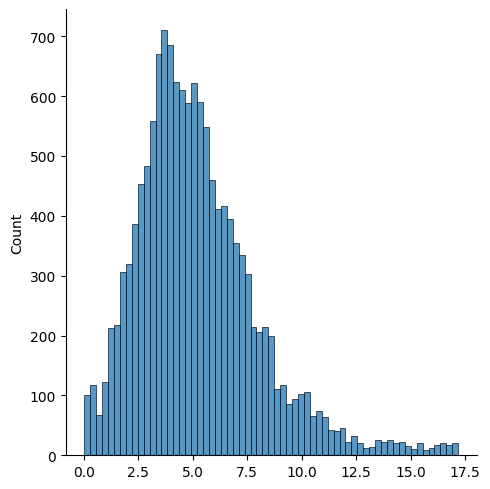

In [91]:
sns.displot(weights)

In [92]:
thres = 7.5
mask = weights > thres
weights = weights[mask]
edges = edges[mask]

g = igraph.Graph()
g.add_vertices(nodes)
g.add_edges(edges)
results = g.community_leiden(weights=weights, resolution=1.4, n_iterations=100, objective_function='modularity')

# to_labels = {i:c for i, c in enumerate(results.membership)}

In [93]:
agg['nbhd_cluster'] = [f'cluster {x}' for x in results.membership]

In [94]:
cols = ['case', 'nbhd', 'nbhd_identifier', 'contact_frac', 'tissue_type', 'nbhd_cluster']
source = agg[cols]

c1 = alt.Chart(source).mark_rect().encode(
    x=alt.X("nbhd_identifier", sort=id_order),
    color=alt.Color('nbhd_cluster').scale(scheme='category10'),
)
c1

alt.Chart(...)

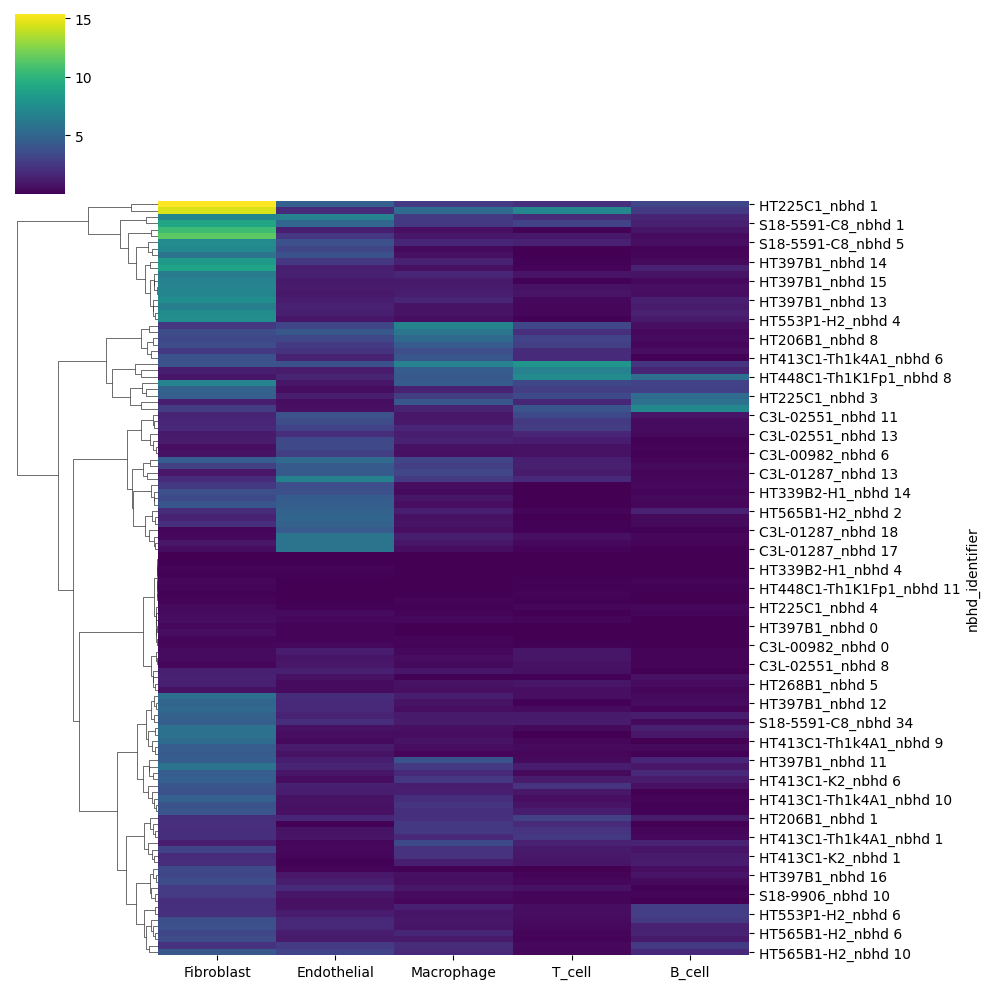

In [95]:
f = agg.copy()
f = f.set_index('nbhd_identifier')
f = f.loc[id_order, common]

# cts = ['T_cell', 'B_cell', 'Macrophage']
# f['immune'] = f[cts].values.sum(1)
# f = f[[c for c in f.columns if c not in cts]]


# f = pd.DataFrame(data=np.log2(f.values + 1), columns=f.columns, index=f.index.to_list())
# f.values[f.values>10] = 10
cg = sns.clustermap(f, col_cluster=False, method='ward', cmap='viridis')
plt.savefig('/data/estorrs/sandbox/nbhd_heatmap.svg')

In [96]:
from scipy.cluster.hierarchy import dendrogram

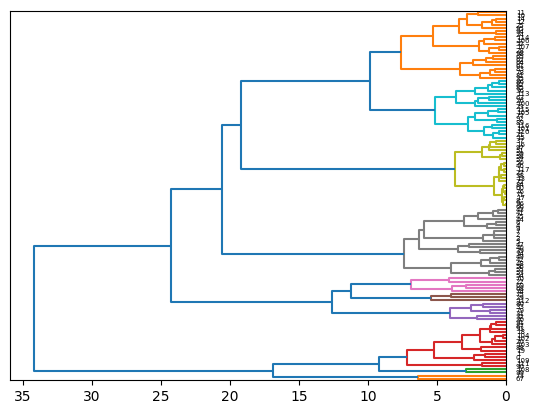

In [97]:
dendrogram(cg.dendrogram_row.linkage, color_threshold=8, orientation='left')
plt.savefig('/data/estorrs/sandbox/linkage.svg')

In [98]:
cols = ['case', 'nbhd', 'nbhd_identifier', 'contact_frac', 'tissue_type']
source = agg[cols]

c1 = alt.Chart(source).mark_rect().encode(
    x=alt.X("nbhd_identifier", sort=np.asarray(id_order)[cg.dendrogram_row.reordered_ind]),
    color=alt.Color('tissue_type').scale(scheme='category10'),
)
c1

alt.Chart(...)

In [99]:
c2 = alt.Chart(source).mark_rect().encode(
    x=alt.X("nbhd_identifier", sort=np.asarray(id_order)[cg.dendrogram_row.reordered_ind]),
    color=alt.Color('case').scale(domain=case_order, range=rng),
)
c2

alt.Chart(...)

In [100]:
alt.vconcat(c1, c2).resolve_scale(color='independent')

alt.VConcatChart(...)

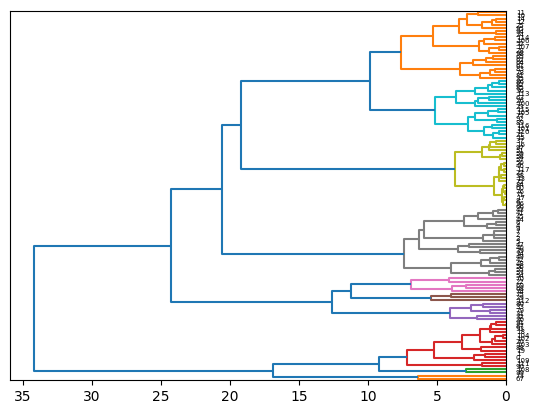

In [101]:
dend = dendrogram(cg.dendrogram_row.linkage, color_threshold=8, orientation='left')
labels = np.asarray(dend['leaves_color_list'])

labels[:4] = 'C3'
idx = 0
current = ''
relabeled = []
for l in labels:
    if l != current:
        idx += 1
        current = l
    relabeled.append(f'cluster {idx}')
id_to_label = {x:l for x, l in zip(np.asarray(id_order)[cg.dendrogram_row.reordered_ind], relabeled)}

agg['relabeled'] = [id_to_label[x] for x in agg['nbhd_identifier']]

In [102]:
cols = common + ['relabeled']

mean_df = agg[cols].groupby('relabeled').mean()
mean_df

Fibroblast  Endothelial  Macrophage    T_cell    B_cell
relabeled                                                         
cluster 1    8.484781     2.413364    1.449903  1.067407  1.048248
cluster 2    3.181465     2.818714    5.019131  2.492590  0.382464
cluster 3    2.009884     2.172750    5.131671  7.368990  3.119243
cluster 4    4.062728     0.732656    2.843998  3.010186  4.833708
cluster 5    1.807908     4.326056    1.250131  0.907737  0.332512
cluster 6    0.441710     0.362746    0.211067  0.266349  0.129408
cluster 7    4.757748     1.106795    1.415801  0.713558  0.617883
cluster 8    2.644850     1.042191    1.410029  0.821869  1.123979

In [103]:
cols = [f'{x}_q0.75' for x in common] + ['relabeled']
quart_df = agg[cols].groupby('relabeled').mean()
quart_df

Fibroblast_q0.75  Endothelial_q0.75  Macrophage_q0.75  \
relabeled                                                          
cluster 1          1.000000           0.315789          0.210526   
cluster 2          0.000000           0.500000          1.000000   
cluster 3          0.000000           0.333333          1.000000   
cluster 4          0.400000           0.000000          0.600000   
cluster 5          0.000000           0.863636          0.181818   
cluster 6          0.000000           0.000000          0.000000   
cluster 7          0.421053           0.000000          0.210526   
cluster 8          0.000000           0.000000          0.227273   

           T_cell_q0.75  B_cell_q0.75  
relabeled                              
cluster 1      0.263158      0.368421  
cluster 2      1.000000      0.000000  
cluster 3      1.000000      1.000000  
cluster 4      1.000000      1.000000  
cluster 5      0.227273      0.045455  
cluster 6      0.000000      0.000000  
cluster 7      0.052632      0.210526  
cluster 8      0.181818      0.409091

In [745]:
mean_df.values.max()

8.484780600245692

In [111]:
cmap = sns.color_palette('Set2')
cmap = ['#%02x%02x%02x' %  tuple((np.asarray(x)*255).astype(int)) for x in cmap]

In [112]:
import plotly.graph_objects as go

for cluster in sorted(set(mean_df.index.to_list())):
    fig = go.Figure(go.Barpolar(
        r=mean_df.loc[cluster].values,
        theta=[0, 72, 144, 216, 288],
        width=quart_df.loc[cluster].values * 31 + 10,
        marker_color=cmap,
        marker_line_color="black",
        marker_line_width=2,
        opacity=0.8
    ))

    fig.update_layout(
        template=None,
        polar = dict(
            radialaxis = dict(range=[0, mean_df.values.max()], showticklabels=False, ticks=''),
            angularaxis = dict(showticklabels=False, ticks='', showgrid=False)
        )
    )
    fig.write_image(f"/data/estorrs/sandbox/radial_{cluster}.svg")
    fig.show()

In [265]:
fig = go.Figure(go.Barpolar(
    r=[4,4,4,4,4],
    theta=[0, 72, 144, 216, 288],
    width=[20, 20, 20, 20, 20],
    marker_color=cmap,
    marker_line_color="black",
    marker_line_width=2,
    opacity=0.8
))

fig.update_layout(
    template=None,
    polar = dict(
        radialaxis = dict(range=[0, mean_df.values.max()], showticklabels=False, ticks=''),
        angularaxis = dict(showticklabels=True, ticks='', showgrid=False)
    )
)
fig.write_image(f"/data/estorrs/sandbox/radial_legend.svg")
fig.show()

In [114]:
f = agg.set_index('nbhd_identifier')
f.loc[np.asarray(id_order)[cg.dendrogram_row.reordered_ind]]

Fibroblast  Endothelial  Macrophage    T_cell  \
nbhd_identifier                                                          
HT225C1_nbhd 1            15.342885     4.658513    2.538869  2.124959   
HT448C1-Th1K1Fp1_nbhd 9   14.445143     1.849974    5.224879  7.100761   
S18-9906_nbhd 4            6.976287     6.728430    2.585036  1.895482   
S18-5591-C8_nbhd 1         9.047613     5.086124    2.503533  3.022711   
HT553P1-H2_nbhd 7         10.608051     1.313559    0.557203  0.061441   
...                             ...          ...         ...       ...   
HT397B1_nbhd 5             3.735276     1.742978    0.829055  0.304213   
HT565B1-H2_nbhd 6          3.289179     1.167910    1.619403  0.211754   
HT565B1-H2_nbhd 4          3.479012     1.045701    1.047732  0.142857   
HT565B1-H2_nbhd 5          2.266921     2.674929    1.880839  0.351764   
HT565B1-H2_nbhd 10         4.148418     3.009732    1.787105  0.274939   

                           B_cell  Fibroblast_q0.75  Endothelial_q0.75  \
nbhd_identifier                                                          
HT225C1_nbhd 1           3.264466              True               True   
HT448C1-Th1K1Fp1_nbhd 9  2.608504              True              False   
S18-9906_nbhd 4          1.537518              True               True   
S18-5591-C8_nbhd 1       1.364066              True               True   
HT553P1-H2_nbhd 7        0.891949              True              False   
...                           ...               ...                ...   
HT397B1_nbhd 5           1.427741             False              False   
HT565B1-H2_nbhd 6        1.479478             False              False   
HT565B1-H2_nbhd 4        1.060596             False              False   
HT565B1-H2_nbhd 5        2.524309             False              False   
HT565B1-H2_nbhd 10       1.754258             False              False   

                         Macrophage_q0.75  T_cell_q0.75  B_cell_q0.75  ...  \
nbhd_identifier                                                        ...   
HT225C1_nbhd 1                       True          True          True  ...   
HT448C1-Th1K1Fp1_nbhd 9              True          True          True  ...   
S18-9906_nbhd 4                      True          True          True  ...   
S18-5591-C8_nbhd 1                   True          True          True  ...   
HT553P1-H2_nbhd 7                   False         False         False  ...   
...                                   ...           ...           ...  ...   
HT397B1_nbhd 5                      False         False          True  ...   
HT565B1-H2_nbhd 6                   False         False          True  ...   
HT565B1-H2_nbhd 4                   False         False         False  ...   
HT565B1-H2_nbhd 5                   False         False          True  ...   
HT565B1-H2_nbhd 10                  False         False          True  ...   

                         tissue_type  contact_frac     nbhd    range  \
nbhd_identifier                                                        
HT225C1_nbhd 1                   CRC      0.061383   nbhd 1   item70   
HT448C1-Th1K1Fp1_nbhd 9          CRC      0.342776   nbhd 9   item73   
S18-9906_nbhd 4                  PKD      0.040110   nbhd 4  item107   
S18-5591-C8_nbhd 1               PKD      0.038789   nbhd 1  item115   
HT553P1-H2_nbhd 7               PDAC      0.088235   nbhd 7   item89   
...                              ...           ...      ...      ...   
HT397B1_nbhd 5                  BRCA      0.079383   nbhd 5   item20   
HT565B1-H2_nbhd 6               BRCA      0.090640   nbhd 6   item14   
HT565B1-H2_nbhd 4               BRCA      0.113300   nbhd 4   item12   
HT565B1-H2_nbhd 5               BRCA      0.210837   nbhd 5    item9   
HT565B1-H2_nbhd 10              BRCA      0.102463  nbhd 10   item13   

                         renamed_nbhd     start      stop  case_idx  \
nbhd_identifier                                                       
HT225

In [117]:
for cluster in sorted(set(agg['relabeled'])):
    print(cluster)
    print(agg[agg['relabeled']==cluster]['nbhd_identifier'].to_list())

cluster 1
['HT339B2-H1_nbhd 2', 'HT339B2-H1_nbhd 12', 'HT397B1_nbhd 14', 'HT397B1_nbhd 15', 'HT397B1_nbhd 13', 'HT225C1_nbhd 1', 'HT448C1-Th1K1Fp1_nbhd 9', 'HT553P1-H2_nbhd 12', 'HT553P1-H2_nbhd 7', 'HT553P1-H2_nbhd 18', 'HT553P1-H2_nbhd 4', 'HT553P1-H2_nbhd 9', 'S18-9906_nbhd 3', 'S18-9906_nbhd 2', 'S18-9906_nbhd 5', 'S18-9906_nbhd 4', 'S18-5591-C8_nbhd 9', 'S18-5591-C8_nbhd 1', 'S18-5591-C8_nbhd 5']
cluster 2
['HT206B1_nbhd 14', 'HT206B1_nbhd 9', 'HT206B1_nbhd 8', 'HT206B1_nbhd 11', 'HT413C1-Th1k4A1_nbhd 8', 'HT413C1-Th1k4A1_nbhd 6']
cluster 3
['HT206B1_nbhd 6', 'HT448C1-Th1K1Fp1_nbhd 8', 'S18-5591-C8_nbhd 3']
cluster 4
['HT397B1_nbhd 6', 'HT225C1_nbhd 3', 'HT225C1_nbhd 5', 'HT225C1_nbhd 2', 'HT448C1-Th1K1Fp1_nbhd 4']
cluster 5
['HT339B2-H1_nbhd 11', 'HT339B2-H1_nbhd 14', 'HT339B2-H1_nbhd 13', 'HT339B2-H1_nbhd 1', 'HT339B2-H1_nbhd 6', 'HT339B2-H1_nbhd 7', 'HT565B1-H2_nbhd 2', 'HT206B1_nbhd 16', 'C3L-01287_nbhd 11', 'C3L-01287_nbhd 9', 'C3L-01287_nbhd 17', 'C3L-01287_nbhd 7', 'C3L-012

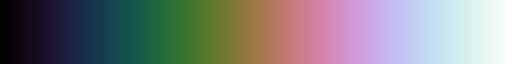

In [140]:
sns.color_palette("cubehelix", as_cmap=True)

In [137]:
sns.cubehelix_palette(n_colors=4)

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.7840440880599454, 0.5292660544265891, 0.6200568926941761],
 [0.5151069036855755, 0.29801047535056074, 0.49050619139300705],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

In [184]:
sns.cubehelix_palette(start=0, rot=.5, n_colors=10)

[[0.8985140780594055, 0.8434615970724173, 0.7616710923850389],
 [0.8625497242149864, 0.7463156935772183, 0.6677988385440397],
 [0.8254597173013548, 0.6452255531088459, 0.5981521300377665],
 [0.77839796668903, 0.545327966356106, 0.5493046856781334],
 [0.7150550031897518, 0.4511198443573199, 0.5143442519262948],
 [0.6370937494505249, 0.3698221039697866, 0.4856557480737052],
 [0.5370251460785227, 0.294287969803545, 0.45069531432186655],
 [0.42276738395849134, 0.22855772514856368, 0.40184786996223354],
 [0.3016712513237784, 0.17018241211441057, 0.33220116145596035],
 [0.18309900214118044, 0.11504037397767372, 0.238328907614961]]

In [156]:
sns.cubehelix_palette(start=.5, rot=.5, n_colors=10)

[[0.8078041134595918, 0.8885512531505309, 0.7672165392583007],
 [0.741504764578712, 0.81277085592796, 0.6414788050162212],
 [0.6936507584442431, 0.7254781249162849, 0.527183807758879],
 [0.6564805738078419, 0.6293122033430302, 0.4313438935861518],
 [0.6209372182245402, 0.5283022446811302, 0.3570489670681237],
 [0.5805591457217658, 0.43216593238599615, 0.3054498131810446],
 [0.5240017077585825, 0.33527875275329827, 0.2663529333982144],
 [0.4483825668530447, 0.2466561798609673, 0.23491403066228905],
 [0.3524610075749041, 0.16879388204658052, 0.20113094686433836],
 [0.23889416045897233, 0.10228695425101092, 0.15456505471639898]]

In [169]:
sns.cubehelix_palette(start=.75, rot=.25, n_colors=10)

[[0.879288371597917, 0.8547361334955935, 0.7536320908522631],
 [0.8261572977372413, 0.7695119335767596, 0.6426342158857025],
 [0.7752900611018976, 0.6805457617262877, 0.5455329186309059],
 [0.7230512920605429, 0.5897550435708703, 0.4619584323550381],
 [0.6661126764511613, 0.49906813457389526, 0.3906449404277951],
 [0.6050443551011866, 0.41469815071430116, 0.3323631916690014],
 [0.5312084683079256, 0.3293849340547028, 0.27831057135144854],
 [0.4459786253641021, 0.24908608047920974, 0.22843707056012366],
 [0.34849641370017603, 0.17494446410826844, 0.1789538230070385],
 [0.23873307075980438, 0.1077305326576442, 0.12580684685795296]]

In [185]:
sns.cubehelix_palette(start=.75, rot=-.25, n_colors=10)

[[0.8646230183110694, 0.8258939101920006, 0.9483286934614623],
 [0.8065858571651536, 0.7310209508972356, 0.9024638233299839],
 [0.7529060286511663, 0.636523278956789, 0.8427023754867411],
 [0.6998924584187496, 0.5442087660088831, 0.7694141166645699],
 [0.6440261392189925, 0.4556307330743598, 0.6838648634937736],
 [0.5854025463227366, 0.37606877549273077, 0.59312700440943],
 [0.5152392764049186, 0.2979784626362798, 0.4903168796289436],
 [0.43431162746791846, 0.22614069675592335, 0.38332763532222935],
 [0.34119040078645085, 0.16057579178275572, 0.2759481377772752],
 [0.23523610844974097, 0.1008530871670162, 0.17223236882832157]]

In [182]:
sns.cubehelix_palette(start=1, rot=0, n_colors=10)

[[0.933065234809246, 0.8185716976251689, 0.8009415971088043],
 [0.8862891860092658, 0.7276421867532308, 0.7032131874202231],
 [0.8315495337504076, 0.6398568616229072, 0.6103393782698963],
 [0.7688462780326718, 0.5552157222341987, 0.522320169657824],
 [0.698179418856058, 0.4737187685871046, 0.4391555615840062],
 [0.6236696149344895, 0.399208964665536, 0.3646457576624376],
 [0.5374737290130639, 0.3238431732145907, 0.2909476206382161],
 [0.4433142396327606, 0.25162156750526027, 0.2221040841522492],
 [0.3411911467935795, 0.18254414753754444, 0.15811514820453676],
 [0.23110445049552047, 0.11661091331144341, 0.09898081279507884]]

In [172]:
sns.cubehelix_palette(start=2, rot=.1, n_colors=10)

[[0.7604711720129863, 0.8967949861255227, 0.8520900271436528],
 [0.6477340036661507, 0.8370012258915477, 0.7672541712028716],
 [0.5443931775498763, 0.7729775261086859, 0.6794798589410518],
 [0.45044579106295857, 0.7044526467129769, 0.5902298480671203],
 [0.3657599996263729, 0.6312210939152617, 0.5009659158642475],
 [0.29365236388819027, 0.5571647659078808, 0.4174724354496409],
 [0.22616709422808262, 0.47441925917541355, 0.33232756913191785],
 [0.166821699751444, 0.38675532328395107, 0.25136381182051915],
 [0.11499746435041235, 0.2942367628620041, 0.1759263480620138],
 [0.06996175659581766, 0.19699596551135068, 0.10730318498742555]]

In [157]:
sns.cubehelix_palette(start=1., rot=.5, n_colors=10)

[[0.760270427557049, 0.8960700482349763, 0.8565258390301244],
 [0.6515040599715688, 0.8390041819585848, 0.7462289860800246],
 [0.5623086882017116, 0.7743702188662626, 0.623149324779936],
 [0.4937688816286159, 0.699670511496728, 0.49772548241782216],
 [0.4431371169955727, 0.6144373022845946, 0.37995961710261317],
 [0.4062104943104567, 0.5250889264554253, 0.28253916314655514],
 [0.3712902871702558, 0.4253045084399493, 0.19997134456654392],
 [0.33149753583572983, 0.3239808076535801, 0.13894851364123198],
 [0.2782407366432826, 0.2260624503243268, 0.0963807658005349],
 [0.20481476616092914, 0.13626618811647445, 0.06525575494457524]]

In [158]:
sns.cubehelix_palette(start=1.5, rot=.5, n_colors=10)

[[0.8034467062543199, 0.8584991872413081, 0.9402896919286865],
 [0.6825483150006999, 0.7987823456384681, 0.8772992006716466],
 [0.5627755768162922, 0.7430097410088011, 0.7900831640798806],
 [0.45297458233057786, 0.6860445826635019, 0.6820678633414744],
 [0.3594548007318168, 0.6233899595642487, 0.5601655519952736],
 [0.2883964466279066, 0.5556680921086449, 0.43983444800472626],
 [0.2316023049018694, 0.4743394811768471, 0.31793213665852554],
 [0.18899732192386165, 0.3832069807337893, 0.20991683592011945],
 [0.15323070946053527, 0.2847195486699032, 0.12270079932835336],
 [0.11494021354509412, 0.18299884170860076, 0.0597103080713135]]

In [159]:
sns.cubehelix_palette(start=2., rot=.5, n_colors=10)

[[0.8941566708541335, 0.8134095311631946, 0.9347442450554249],
 [0.8035932746369743, 0.7323271832877264, 0.9036192341994651],
 [0.694584535673404, 0.6627571692013621, 0.861051486358768],
 [0.5748919752117659, 0.6020603456765778, 0.8000286554334561],
 [0.4535725856970284, 0.5462075592404384, 0.7174608368534449],
 [0.3449310503566655, 0.4933242636924353, 0.6200403828973867],
 [0.24462574322180963, 0.4333486982270938, 0.5022745175821777],
 [0.16338213902930834, 0.3651085260213857, 0.37685067522006394],
 [0.1024409532094096, 0.2861080787377332, 0.25377101391997536],
 [0.05914505522730218, 0.19575226143526359, 0.14347416096987545]]

In [160]:
sns.cubehelix_palette(start=2.5, rot=.5, n_colors=10)

[[0.9416903567566764, 0.8058907360787492, 0.8454349452836011],
 [0.8935939792441175, 0.7060938572571015, 0.7988690531356616],
 [0.8259266059159354, 0.6138650752513845, 0.765085969337711],
 [0.737603667390992, 0.5317020375228799, 0.7336470666017858],
 [0.631372686925996, 0.46007250163697394, 0.6945501868189553],
 [0.5192797017679747, 0.40040126962300615, 0.6429510329318763],
 [0.39733716381013623, 0.34332294254044277, 0.5686561064138482],
 [0.28026717004662316, 0.28778389822877287, 0.47281619224112104],
 [0.17666122414103116, 0.2288395104599869, 0.3585211949837788],
 [0.09322444952534534, 0.16177302756980005, 0.23278346074169926]]

In [161]:
sns.cubehelix_palette(start=.5, rot=-.5, n_colors=10)

[[0.7611058395410276, 0.897713045748989, 0.8454349452836011],
 [0.6475389924250959, 0.8312061179534195, 0.7988690531356617],
 [0.5516174331469554, 0.7533438201390327, 0.765085969337711],
 [0.47599829224141754, 0.6647212472467017, 0.7336470666017856],
 [0.41944085427823424, 0.5678340676140038, 0.6945501868189554],
 [0.3790627817754598, 0.4716977553188698, 0.6429510329318763],
 [0.34351942619215814, 0.3706877966569699, 0.5686561064138481],
 [0.306349241555757, 0.27452187508371506, 0.47281619224112104],
 [0.258495235421288, 0.18722914407204003, 0.3585211949837789],
 [0.19219588654040817, 0.11144874684946916, 0.2327834607416993]]

In [162]:
sns.cubehelix_palette(start=1., rot=-.5, n_colors=10)

[[0.7951852338390708, 0.8637338118835255, 0.9347442450554247],
 [0.7217592633567175, 0.7739375496756732, 0.9036192341994651],
 [0.6685024641642702, 0.6760191923464198, 0.861051486358768],
 [0.6287097128297442, 0.5746954915600506, 0.8000286554334561],
 [0.5937895056895434, 0.47491107354457474, 0.7174608368534449],
 [0.5568628830044273, 0.3855626977154054, 0.6200403828973868],
 [0.5062311183713842, 0.30032948850327196, 0.5022745175821777],
 [0.43769131179828824, 0.22562978113373744, 0.37685067522006405],
 [0.3484959400284312, 0.16099581804141513, 0.25377101391997536],
 [0.23972957244295098, 0.10392995176502372, 0.14347416096987556]]

In [163]:
sns.cubehelix_palette(start=1.5, rot=-.5, n_colors=10)

[[0.8850597864549059, 0.8170011582913992, 0.9402896919286865],
 [0.8467692905394647, 0.7152804513300969, 0.8772992006716467],
 [0.8110026780761384, 0.6167930192662107, 0.7900831640798806],
 [0.7683976950981306, 0.5256605188231529, 0.6820678633414745],
 [0.7116035533720935, 0.4443319078913552, 0.5601655519952737],
 [0.6405451992681832, 0.3766100404357513, 0.43983444800472626],
 [0.5470254176694221, 0.3139554173364982, 0.31793213665852554],
 [0.4372244231837078, 0.25699025899119887, 0.20991683592011948],
 [0.3174516849993001, 0.20121765436153197, 0.12270079932835334],
 [0.19655329374568004, 0.1415008127586918, 0.059710308071313514]]

In [164]:
sns.cubehelix_palette(start=2, rot=-.5, n_colors=10)

[[0.9408549447726978, 0.8042477385647364, 0.8565258390301245],
 [0.8975590467905904, 0.7138919212622669, 0.7462289860800247],
 [0.8366178609706917, 0.6348914739786143, 0.623149324779936],
 [0.7553742567781904, 0.5666513017729062, 0.49772548241782233],
 [0.6550689496433344, 0.5066757363075647, 0.37995961710261317],
 [0.5464274143029716, 0.4537924407595616, 0.28253916314655514],
 [0.42510802478823395, 0.3979396543234222, 0.19997134456654395],
 [0.30541546432659605, 0.3372428307986379, 0.13894851364123195],
 [0.19640672536302578, 0.26767281671227366, 0.09638076580053484],
 [0.10584332914586633, 0.18659046883680536, 0.06525575494457521]]

In [165]:
sns.cubehelix_palette(start=2.5, rot=-.5, n_colors=10)

[[0.9067755504746546, 0.8382269724302, 0.7672165392583007],
 [0.8233387758589689, 0.7711604895400131, 0.6414788050162212],
 [0.7197328299533768, 0.7122161017712272, 0.527183807758879],
 [0.6026628361898636, 0.6566770574595573, 0.4313438935861518],
 [0.4807202982320253, 0.5995987303769938, 0.3570489670681237],
 [0.368627313074004, 0.539927498363026, 0.3054498131810446],
 [0.26239633260900785, 0.46829796247712013, 0.2663529333982144],
 [0.1740733940840647, 0.38613492474861555, 0.234914030662289],
 [0.10640602075588251, 0.2939061427428986, 0.2011309468643383],
 [0.05830964324332352, 0.19410926392125077, 0.154565054716399]]

In [166]:
sns.cubehelix_palette(start=3, rot=-.5, n_colors=10)

[[0.8169009978588195, 0.8849596260223263, 0.7616710923850389],
 [0.6983287486762216, 0.8298175878855895, 0.6677988385440397],
 [0.5772326160415087, 0.7714422748514363, 0.5981521300377665],
 [0.4629748539214773, 0.705712030196455, 0.5493046856781334],
 [0.3629062505494752, 0.6301778960302135, 0.5143442519262948],
 [0.2849449968102482, 0.5488801556426801, 0.4856557480737051],
 [0.22160203331096995, 0.45467203364389397, 0.4506953143218665],
 [0.1745402826986452, 0.3547744468911541, 0.4018478699622335],
 [0.13745027578501356, 0.25368430642278184, 0.3322011614559603],
 [0.10148592194059447, 0.15653840292758267, 0.238328907614961]]

In [181]:
sns.color_palette('Reds')

[(0.9950634371395617, 0.8596539792387543, 0.7986620530565167),
 (0.9882352941176471, 0.6866743560169165, 0.5778854286812765),
 (0.9865897731641676, 0.5067281814686659, 0.38123798539023457),
 (0.9570011534025374, 0.3087120338331411, 0.22191464821222606),
 (0.8370472895040368, 0.13394848135332565, 0.13079584775086506),
 (0.6663437139561708, 0.06339100346020761, 0.08641291810841982)]

In [421]:
cubehelix_map = {
#     'cluster 1': (.5, -.5),
    'cluster 1': 'Blues_r',
#     'cluster 2': (.75, .25),
    'cluster 2': 'Oranges',
#     'cluster 3': (3, .5),
    'cluster 3': 'Greens',
    'cluster 4': 'rocket_r',
#     'cluster 5': (1., -.5),
    'cluster 5': 'Purples',
    'cluster 6': (.75, .25),
#     'cluster 7': (0, .5),
    'cluster 7': 'RdPu',
    'cluster 8': 'YlOrBr',
#     'cluster 8': 'Oranges'
}

def get_cubehelixed(cluster, labels):
    n_colors = len(labels) + 1
    obj = cubehelix_map[cluster]
    if isinstance(obj, str):
        colors = sns.color_palette(obj, n_colors=n_colors - 1)
    else:
        colors = sns.cubehelix_palette(start=obj[0], rot=obj[1], n_colors=n_colors)
    mapping = {l:c for l, c in zip(labels, colors)}
    print(mapping)
    
    cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
    
    for i in range(len(cmap)):
        if i in mapping:
            if mapping[i][0] > 1:
                cmap[i] = tuple(np.asarray(mapping[i]) / 255.)
            else:
                cmap[i] = tuple(mapping[i])
    return cmap

def get_case_cmap(case):
    f = agg[agg['case']==case]
    case_cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
    for cluster in sorted(set(f['relabeled'])):
        ff = f[f['relabeled']==cluster]
        labels = [int(x.split(' ')[-1]) for x in ff['nbhd'].to_list()]
        cmap = get_cubehelixed(cluster, labels)
        for l in labels:
            case_cmap[l] = cmap[l]
    return case_cmap
        
        

In [256]:
case_to_tumor_mask['HT397B1'].shape

(2, 132, 132)

In [319]:
from scipy.ndimage import binary_fill_holes
tumor_color = np.asarray((217, 11, 14)) / 255
tumor_color = [.3, .3, .3]
def overlay_tumor(case, rgb):
    m = case_to_tumor_mask[case][0]
#     m = binary_fill_holes(m)
    rgb[m] = tumor_color
    return rgb

{12: [0.7611058395410276, 0.897713045748989, 0.8454349452836011], 7: [0.5692057725623613, 0.769825774304614, 0.7713170213730839], 18: [0.4400101343169528, 0.6073546865542835, 0.7116827253370499], 4: [0.36445067068963477, 0.4310083919724144, 0.6158403898540434], 9: [0.29790922210725757, 0.2562451006147689, 0.4512619398907063]}


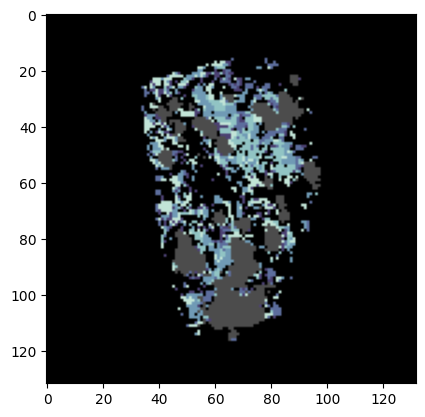

In [294]:
labels = [12, 7, 18, 4, 9]
cmap = get_cubehelixed('cluster 1', labels)
rgb = get_nbhd_rgb('HT553P1-H2', labels, cmap=cmap)
rgb = overlay_tumor('HT553P1-H2', rgb)
plt.imshow(rgb)

{8: (0.9921568627450981, 0.726797385620915, 0.49150326797385624), 6: (0.9137254901960784, 0.3686274509803921, 0.050980392156862744)}


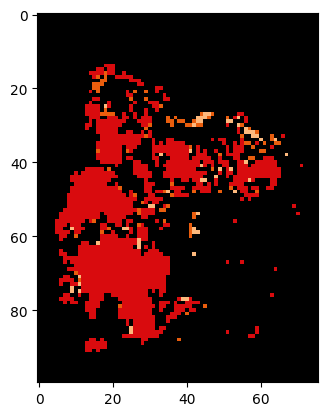

In [261]:
labels = [8, 6]
cmap = get_cubehelixed('cluster 2', labels)
rgb = get_nbhd_rgb('HT413C1-Th1k4A1', labels, cmap=cmap)
rgb = overlay_tumor('HT413C1-Th1k4A1', rgb)
plt.imshow(rgb)

{6: (0.45176470588235296, 0.7670895809304115, 0.4612072279892349)}


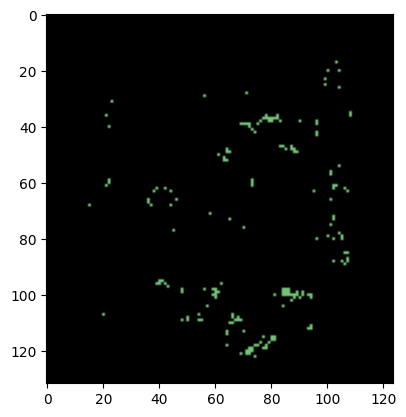

In [245]:
labels = [6]
cmap = get_cubehelixed('cluster 3', labels)
rgb = get_nbhd_rgb('HT206B1', labels, cmap=cmap)
plt.imshow(rgb)

{6: (0.79085854, 0.10184672, 0.313391)}


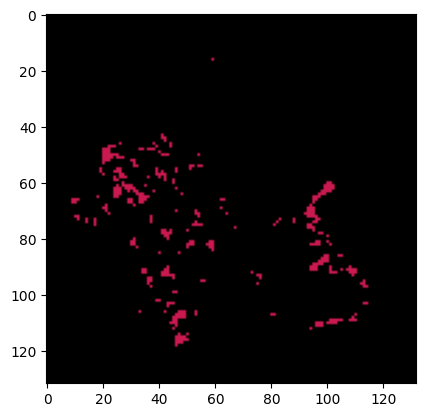

In [246]:
labels = [6]
cmap = get_cubehelixed('cluster 4', labels)
rgb = get_nbhd_rgb('HT397B1', labels, cmap=cmap)
plt.imshow(rgb)

{2: (0.617762399077278, 0.6021376393694733, 0.7834525182622069)}


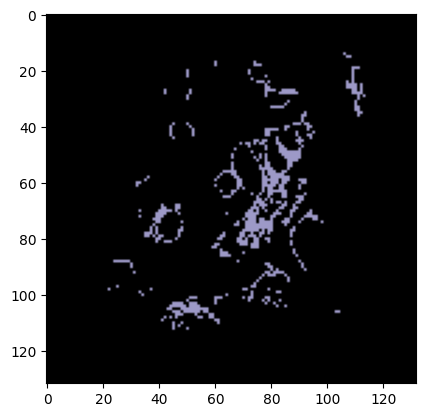

In [247]:
labels = [14, 13, 1, 6, 7]
labels = [0, 13, 12, 11]
labels = [2]
cmap = get_cubehelixed('cluster 5', labels)
rgb = get_nbhd_rgb('HT565B1-H2', labels, cmap=cmap)
plt.imshow(rgb)

{7: [0.879288371597917, 0.8547361334955935, 0.7536320908522631], 4: [0.7230512920605429, 0.5897550435708703, 0.4619584323550381], 8: [0.5312084683079256, 0.3293849340547028, 0.27831057135144854]}


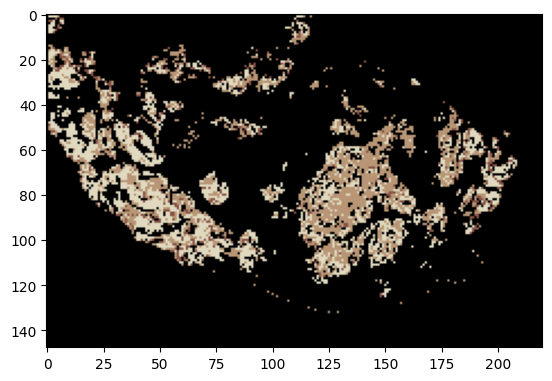

In [248]:
labels = [7, 4, 8]
cmap = get_cubehelixed('cluster 6', labels)
rgb = get_nbhd_rgb('C3L-02551', labels, cmap=cmap)
plt.imshow(rgb)

{9: (0.9898039215686275, 0.8149019607843138, 0.7984313725490196), 10: (0.9780392156862745, 0.5803921568627451, 0.6941176470588235), 5: (0.8870588235294118, 0.24470588235294116, 0.6), 12: (0.6007843137254902, 0.00392156862745098, 0.4831372549019608)}


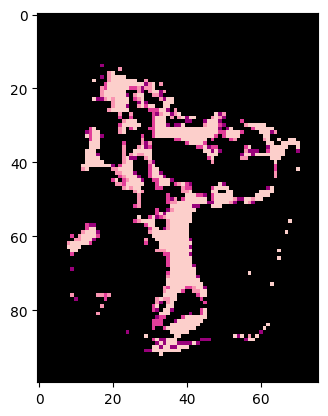

In [254]:
labels = [9, 10, 5, 12]
cmap = get_cubehelixed('cluster 7', labels)
rgb = get_nbhd_rgb('HT413C1-Th1k4A1', labels, cmap=cmap)
plt.imshow(rgb)

{32: [0.8078041134595918, 0.8885512531505309, 0.7672165392583007]}


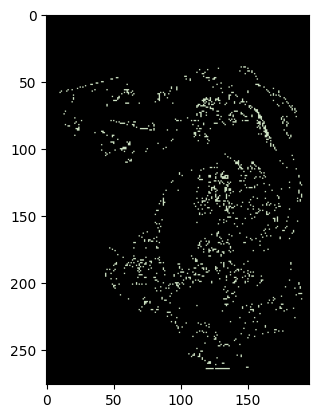

In [250]:
labels = [32]
cmap = get_cubehelixed('cluster 8', labels)
rgb = get_nbhd_rgb('C3L-00982', labels, cmap=cmap)
plt.imshow(rgb)

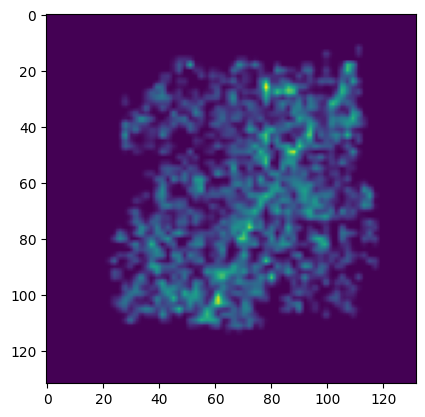

In [223]:
img = get_intensity_img('HT565B1-H2', 'visium', 'PECAM1')
plt.imshow(img)

In [328]:
case = 'HT413C1-Th1k4A1'


In [329]:
agg_f = agg[agg['case']==case]
agg_f

Fibroblast  Endothelial  Macrophage    T_cell    B_cell  Fibroblast_q0.75  \
9     5.276601     0.372603    0.750184  0.245277  0.019614              True   
0     0.168247     0.039097    0.139591  0.091020  0.005047             False   
1     2.004127     0.829642    1.767273  2.479939  0.356490             False   
4     1.920421     0.742918    2.481004  2.295829  0.186643             False   
8     3.536542     2.524631    4.365505  2.862348  0.300326             False   
10    4.697350     0.746372    2.011962  0.573586  0.122745             False   
5     3.908628     0.709032    2.311204  0.802006  0.074252             False   
6     3.791720     1.477200    4.129318  1.853957  0.112605             False   
12    4.060185     0.651303    2.099763  1.203192  0.089232             False   
11    2.049985     0.116776    2.511303  1.814054  0.023617             False   

    Endothelial_q0.75  Macrophage_q0.75  T_cell_q0.75  B_cell_q0.75  ...  \
9               False             False         False         False  ...   
0               False             False         False         False  ...   
1               False             False          True         False  ...   
4               False              True          True         False  ...   
8               False              True          True         False  ...   
10              False             False         False         False  ...   
5               False              True         False         False  ...   
6               False              True          True         False  ...   
12              False             False         False         False  ...   
11              False              True          True         False  ...   

    contact_frac     nbhd   range  renamed_nbhd     start      stop  \
9       0.180971   nbhd 9  item77        nbhd 0  0.000000  0.180971   
0       0.157347   nbhd 0  item78        nbhd 1  0.180971  0.338318   
1       0.111400   nbhd 1  item79        nbhd 2  0.338318  0.449718   
4       0.075639   nbhd 4  item80        nbhd 3  0.449718  0.525358   
8       0.053749   nbhd 8  item81        nbhd 4  0.525358  0.579107   
10      0.051365  nbhd 10  item82        nbhd 5  0.579107  0.630472   
5       0.049632   nbhd 5  item83        nbhd 6  0.630472  0.680104   
6       0.043780   nbhd 6  item84        nbhd 7  0.680104  0.723884   
12      0.037278  nbhd 12  item85        nbhd 8  0.723884  0.761162   
11      0.030342  nbhd 11  item86        nbhd 9  0.761162  0.791504   

            nbhd_identifier  case_idx  nbhd_cluster  relabeled  
9    HT413C1-Th1k4A1_nbhd 9       -11     cluster 1  cluster 7  
0    HT413C1-Th1k4A1_nbhd 0       -11     cluster 0  cluster 6  
1    HT413C1-Th1k4A1_nbhd 1       -11     cluster 2  cluster 8  
4    HT413C1-Th1k4A1_nbhd 4       -11     cluster 2  cluster 8  
8    HT413C1-Th1k4A1_nbhd 8       -11     cluster 2  cluster 2  
10  HT413C1-Th1k4A1_nbhd 10       -11    cluster 11  cluster 7  
5    HT413C1-Th1k4A1_nbhd 5       -11     cluster 8  cluster 7  
6    HT413C1-Th1k4A1_nbhd 6       -11     cluster 2  cluster 2  
12  HT413C1-Th1k4A1_nbhd 12       -11     cluster 8  cluster 7  
11  HT413C1-Th1k4A1_nbhd 11       -11     cluster 4  cluster 8  

[10 rows x 32 columns]

{8: (0.9921568627450981, 0.726797385620915, 0.49150326797385624), 6: (0.9137254901960784, 0.3686274509803921, 0.050980392156862744)}
{0: [0.879288371597917, 0.8547361334955935, 0.7536320908522631]}
{9: (0.9898039215686275, 0.8149019607843138, 0.7984313725490196), 10: (0.9780392156862745, 0.5803921568627451, 0.6941176470588235), 5: (0.8870588235294118, 0.24470588235294116, 0.6), 12: (0.6007843137254902, 0.00392156862745098, 0.4831372549019608)}
{1: [0.8078041134595918, 0.8885512531505309, 0.7672165392583007], 4: [0.6564805738078419, 0.6293122033430302, 0.4313438935861518], 11: [0.5240017077585825, 0.33527875275329827, 0.2663529333982144]}


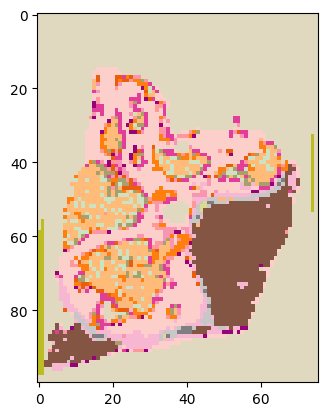

In [330]:
cmap = get_case_cmap(case)
rgb = get_nbhd_rgb(case, np.arange(case_to_exp[case]['xenium'].shape[0]), cmap=cmap)
plt.imshow(rgb)

{8: (0.9921568627450981, 0.726797385620915, 0.49150326797385624), 6: (0.9137254901960784, 0.3686274509803921, 0.050980392156862744)}
{0: [0.879288371597917, 0.8547361334955935, 0.7536320908522631]}
{9: (0.9898039215686275, 0.8149019607843138, 0.7984313725490196), 10: (0.9780392156862745, 0.5803921568627451, 0.6941176470588235), 5: (0.8870588235294118, 0.24470588235294116, 0.6), 12: (0.6007843137254902, 0.00392156862745098, 0.4831372549019608)}
{1: [0.8078041134595918, 0.8885512531505309, 0.7672165392583007], 4: [0.6564805738078419, 0.6293122033430302, 0.4313438935861518], 11: [0.5240017077585825, 0.33527875275329827, 0.2663529333982144]}


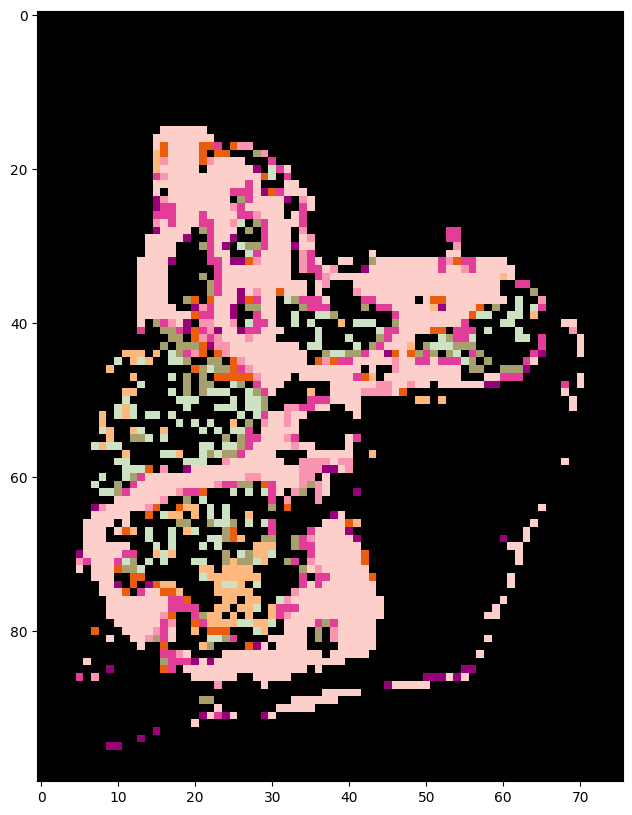

In [377]:
fig, axs = plt.subplots(figsize=(10, 10))
labels = [1,4, 6, 8, 9, 10, 5, 12]
cmap = get_case_cmap(case)
rgb = get_nbhd_rgb(case, labels, cmap=cmap, )
# rgb = overlay_tumor(case, rgb)
plt.imshow(rgb)

In [380]:
sns.color_palette(cmap, )

[(0.879288371597917, 0.8547361334955935, 0.7536320908522631),
 (0.8078041134595918, 0.8885512531505309, 0.7672165392583007),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.6564805738078419, 0.6293122033430302, 0.4313438935861518),
 (0.8870588235294118, 0.24470588235294116, 0.6),
 (0.9137254901960784, 0.3686274509803921, 0.050980392156862744),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.9921568627450981, 0.726797385620915, 0.49150326797385624),
 (0.9898039215686275, 0.8149019607843138, 0.7984313725490196),
 (0.9780392156862745, 0.5803921568627451, 0.6941176470588235),
 (0.5240017077585825, 0.33527875275329827, 0.2663529333982144),
 (0.6007843137254902, 0.00392156862745098, 0.4831372549019608),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
 (0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
 (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
 (0.4823529411764706, 0.2549019607843137, 0.45098039215686275),
 (0.6470588235294118, 0.3176470588235294, 0.5803921568627451),
 (0.807843137254902, 0.42745098039215684, 0.7411764705882353),
 (0.8705882352941177, 0.6196078431372549, 0.8392156862745098),
 (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

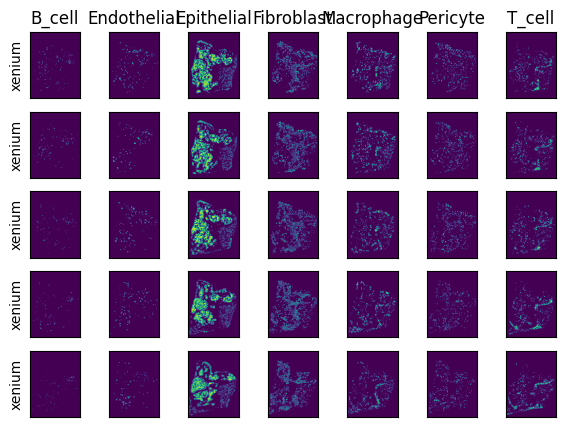

In [317]:
show_cytospace(case)


In [322]:
mushroom = Mushroom.from_config(
    os.path.join(project_dir, case, 'mushroom_50res')
)

INFO:root:loading spore for cosmx
INFO:root:data mask detected
INFO:root:starting cosmx processing
INFO:root:using 1000 channels
INFO:root:2 sections detected: ['HT413C1-Th1k4A1-U7', 'HT413C1-Th1k4A1-U34']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U7
INFO:root:generating image data for section HT413C1-Th1k4A1-U34
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT413C1-Th1k4A1-U7', 'cosmx'), ('HT413C1-Th1k4A1-U34', 'cosmx')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpv1fl2xp7
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpv1fl2xp7/_remote_module_non_scriptable.py
INFO:root:creating ViT


cosmx torch.Size([1000, 102, 73])


INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/cosmx_chkpts/last-v2.ckpt
INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:14 sections detected: ['HT413C1-Th1k4A1-U14', 'HT413C1-Th1k4A1-U18', 'HT413C1-Th1k4A1-U1', 'HT413C1-Th1k4A1-U4', 'HT413C1-Th1k4A1-U8', 'HT413C1-Th1k4A1-U11', 'HT413C1-Th1k4A1-U21', 'HT413C1-Th1k4A1-U24', 'HT413C1-Th1k4A1-U27', 'HT413C1-Th1k4A1-U29', 'HT413C1-Th1k4A1-U30', 'HT413C1-Th1k4A1-U35', 'HT413C1-Th1k4A1-U38', 'HT413C1-Th1k4A1-U40']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U14


0.02


INFO:root:generating image data for section HT413C1-Th1k4A1-U18
INFO:root:generating image data for section HT413C1-Th1k4A1-U1
INFO:root:generating image data for section HT413C1-Th1k4A1-U4
INFO:root:generating image data for section HT413C1-Th1k4A1-U8
INFO:root:generating image data for section HT413C1-Th1k4A1-U11
INFO:root:generating image data for section HT413C1-Th1k4A1-U21
INFO:root:generating image data for section HT413C1-Th1k4A1-U24
INFO:root:generating image data for section HT413C1-Th1k4A1-U27
INFO:root:generating image data for section HT413C1-Th1k4A1-U29
INFO:root:generating image data for section HT413C1-Th1k4A1-U30
INFO:root:generating image data for section HT413C1-Th1k4A1-U35
INFO:root:generating image data for section HT413C1-Th1k4A1-U38
INFO:root:generating image data for section HT413C1-Th1k4A1-U40
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 14 sections detected: [('HT413C1-Th1k4A1-U14', 'he'), ('HT413C1-Th1k4A1-U18

he torch.Size([3, 101, 72])


INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 27 channels
INFO:root:7 sections detected: ['HT413C1-Th1k4A1-U20', 'HT413C1-Th1k4A1-U3', 'HT413C1-Th1k4A1-U26', 'HT413C1-Th1k4A1-U32', 'HT413C1-Th1k4A1-U37', 'HT413C1-Th1k4A1-U41', 'HT413C1-Th1k4A1-U42']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U20


0.02


INFO:root:generating image data for section HT413C1-Th1k4A1-U3
INFO:root:generating image data for section HT413C1-Th1k4A1-U26
INFO:root:generating image data for section HT413C1-Th1k4A1-U32
INFO:root:generating image data for section HT413C1-Th1k4A1-U37
INFO:root:generating image data for section HT413C1-Th1k4A1-U41
INFO:root:generating image data for section HT413C1-Th1k4A1-U42
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 7 sections detected: [('HT413C1-Th1k4A1-U20', 'multiplex'), ('HT413C1-Th1k4A1-U3', 'multiplex'), ('HT413C1-Th1k4A1-U26', 'multiplex'), ('HT413C1-Th1k4A1-U32', 'multiplex'), ('HT413C1-Th1k4A1-U37', 'multiplex'), ('HT413C1-Th1k4A1-U41', 'multiplex'), ('HT413C1-Th1k4A1-U42', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

multiplex torch.Size([27, 101, 72])


INFO:root:loading spore for xenium
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:5 sections detected: ['HT413C1-Th1k4A1-U19', 'HT413C1-Th1k4A1-U2', 'HT413C1-Th1k4A1-U9', 'HT413C1-Th1k4A1-U25', 'HT413C1-Th1k4A1-U36']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U19
INFO:root:generating image data for section HT413C1-Th1k4A1-U2
INFO:root:generating image data for section HT413C1-Th1k4A1-U9
INFO:root:generating image data for section HT413C1-Th1k4A1-U25
INFO:root:generating image data for section HT413C1-Th1k4A1-U36
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 5 sections detected: [('HT413C1-Th1k4A1-U19', 'xenium'), ('HT413C1-Th1k4A1-U2', 'xenium'), ('HT413C1-Th1k4A1-U9', 'xenium'), ('HT413C1-Th1k4A1-U25', 'xenium'), ('HT413C1-Th1k4A1-U36', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU

xenium torch.Size([477, 102, 73])


INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding cosmx spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.



Predicting: |                                                                                       | 0/? [00:…

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

In [332]:
spore = mushroom.dtype_to_spore['multiplex']
spore.sections

[{'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s3_HT413C1-Th1k4A1-U20_multiplex.ome.tiff'}],
  'position': 30,
  'sid': 'HT413C1-Th1k4A1-U20'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s6_HT413C1-Th1k4A1-U3_multiplex.ome.tiff'}],
  'position': 55,
  'sid': 'HT413C1-Th1k4A1-U3'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s15_HT413C1-Th1k4A1-U26_multiplex.ome.tiff'}],
  'position': 125,
  'sid': 'HT413C1-Th1k4A1-U26'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s20_HT413C1-Th1k4A1-U32_multiplex.ome.tiff'}],
  'position': 155,
  'sid': 'HT413C1-Th1k4A1-U32'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submis

In [333]:
spore = mushroom.dtype_to_spore['xenium']
spore.sections

[{'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s2_HT413C1-Th1k4A1-U19_xenium.h5ad'}],
  'position': 25,
  'sid': 'HT413C1-Th1k4A1-U19'},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s5_HT413C1-Th1k4A1-U2_xenium.h5ad'}],
  'position': 50,
  'sid': 'HT413C1-Th1k4A1-U2'},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s10_HT413C1-Th1k4A1-U9_xenium.h5ad'}],
  'position': 85,
  'sid': 'HT413C1-Th1k4A1-U9'},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s14_HT413C1-Th1k4A1-U25_xenium.h5ad'}],
  'position': 120,
  'sid': 'HT413C1-Th1k4A1-U25'},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s23_HT413C1

In [325]:
spore = mushroom.dtype_to_spore['he']
spore.sections

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s0_HT413C1-Th1k4A1-U14_he.tif'}],
  'position': 0,
  'sid': 'HT413C1-Th1k4A1-U14'},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s1_HT413C1-Th1k4A1-U18_he.tif'}],
  'position': 20,
  'sid': 'HT413C1-Th1k4A1-U18'},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s4_HT413C1-Th1k4A1-U1_he.tif'}],
  'position': 45,
  'sid': 'HT413C1-Th1k4A1-U1'},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s7_HT413C1-Th1k4A1-U4_he.tif'}],
  'position': 60,
  'sid': 'HT413C1-Th1k4A1-U4'},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s9_HT413C1-Th1k4A1-U8_he.tif'}],
  'position': 80,
  's

In [337]:
section_idx = 30

In [357]:
dtype_to_volume = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
)['labeled']
dtype_to_volume.keys()

dict_keys(['cosmx', 'he', 'multiplex', 'xenium', 'integrated'])

In [358]:
dtype_to_volume['xenium'].shape

(42, 100, 76)

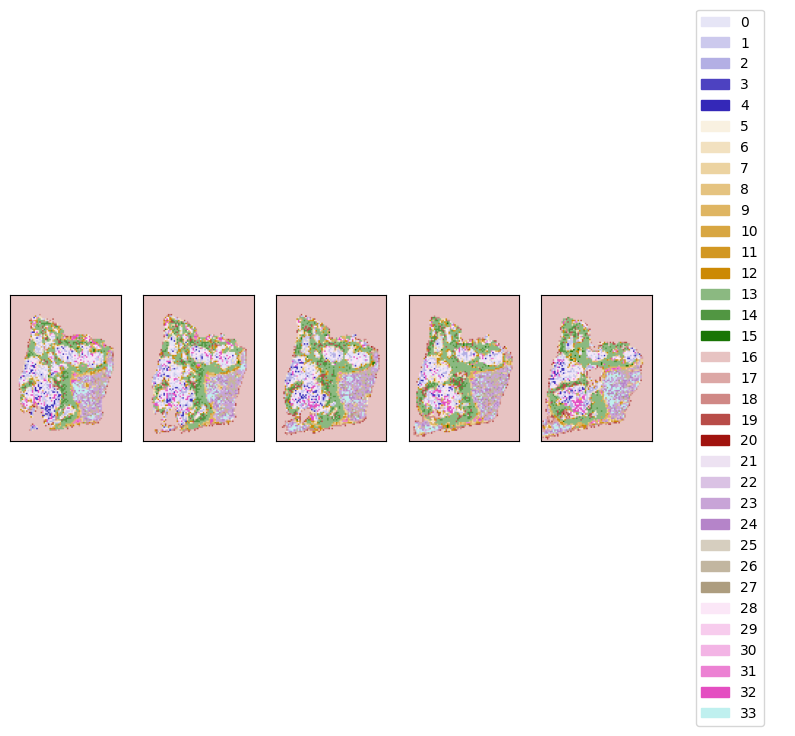

In [360]:
mushroom.display_clusters('xenium')

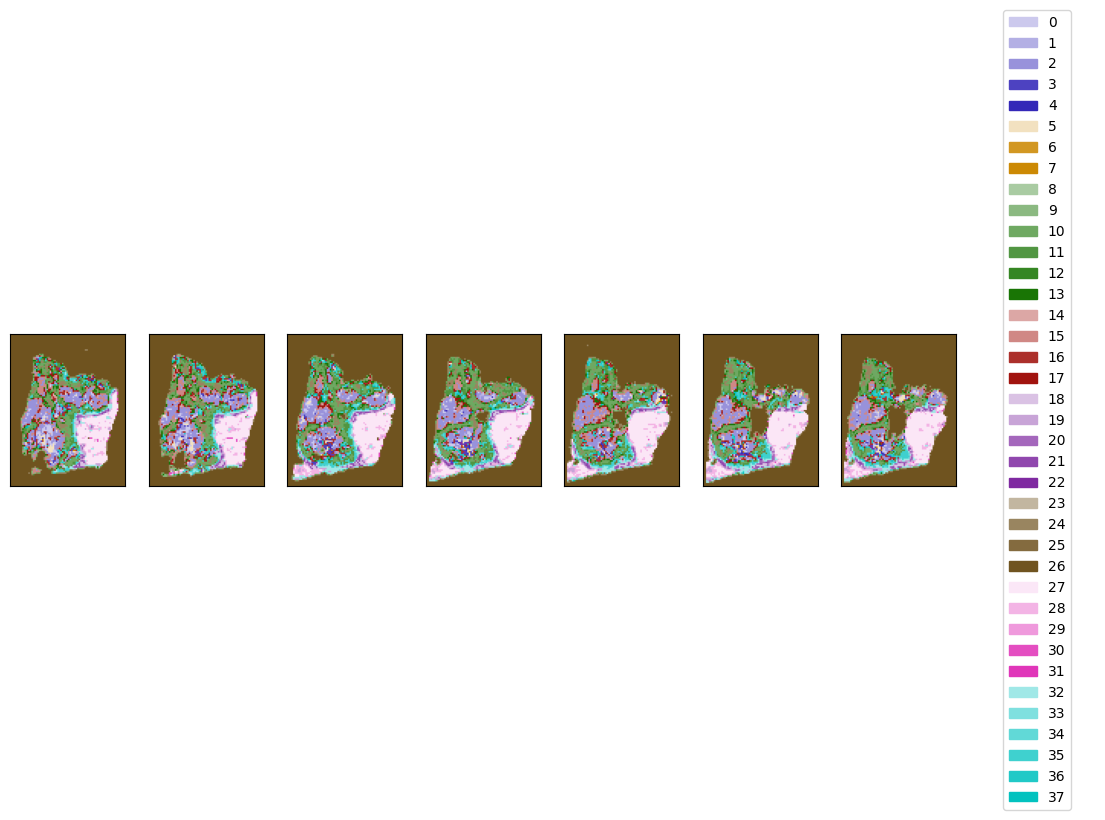

In [361]:
mushroom.display_clusters('multiplex')

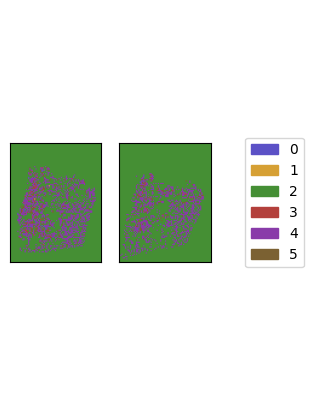

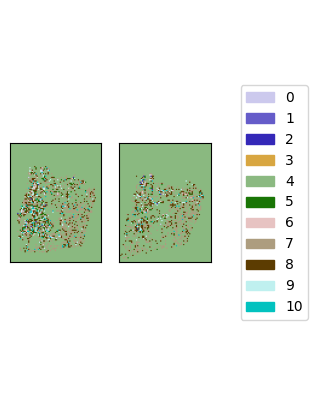

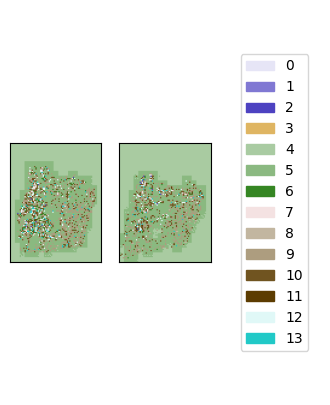

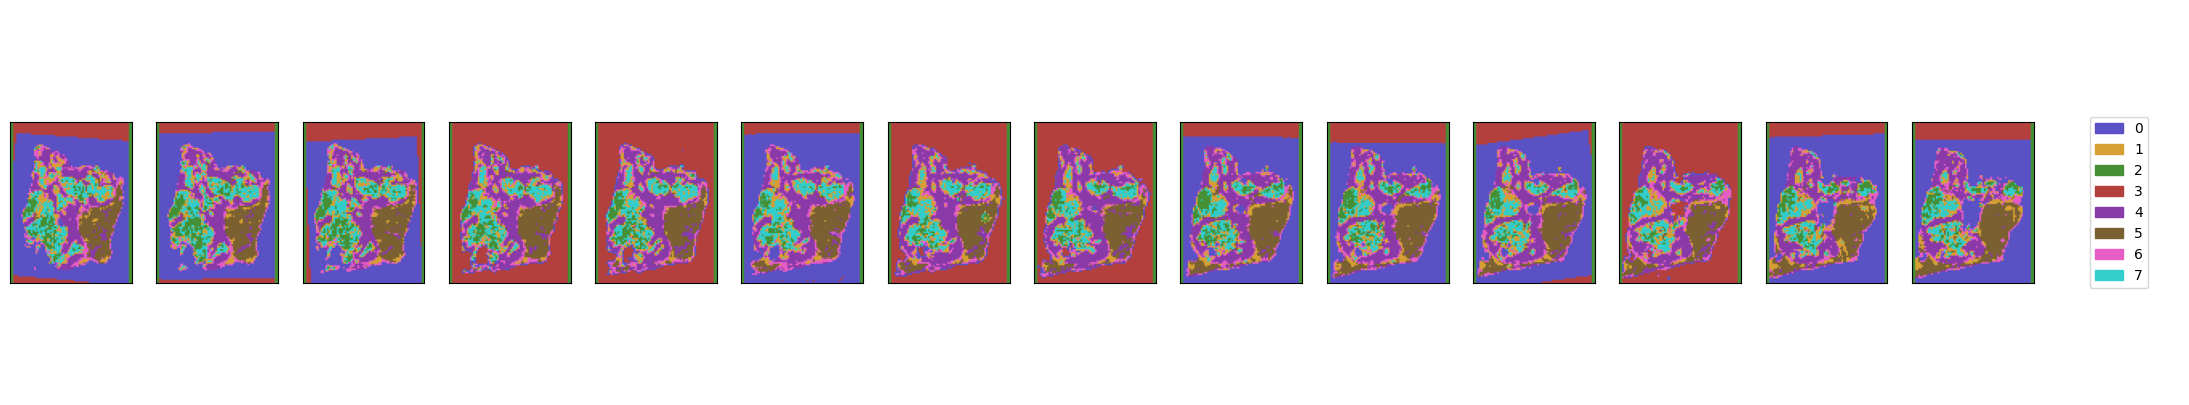

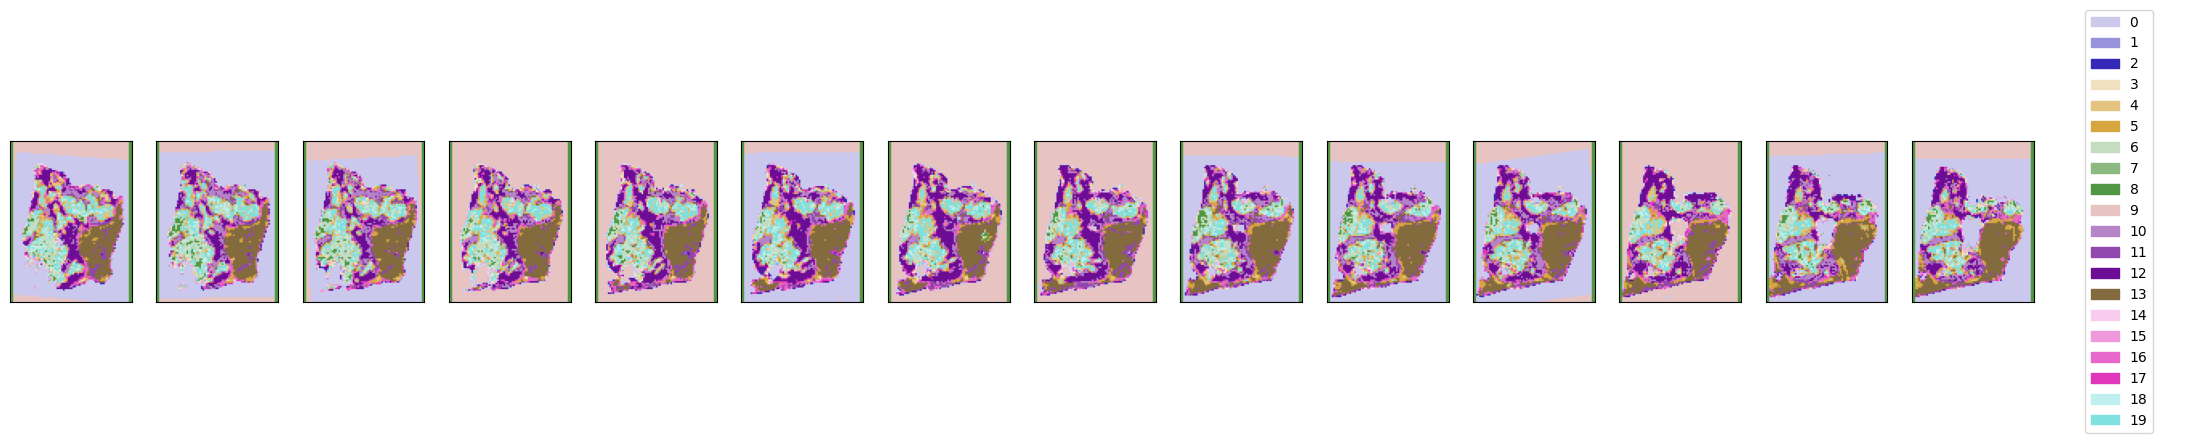

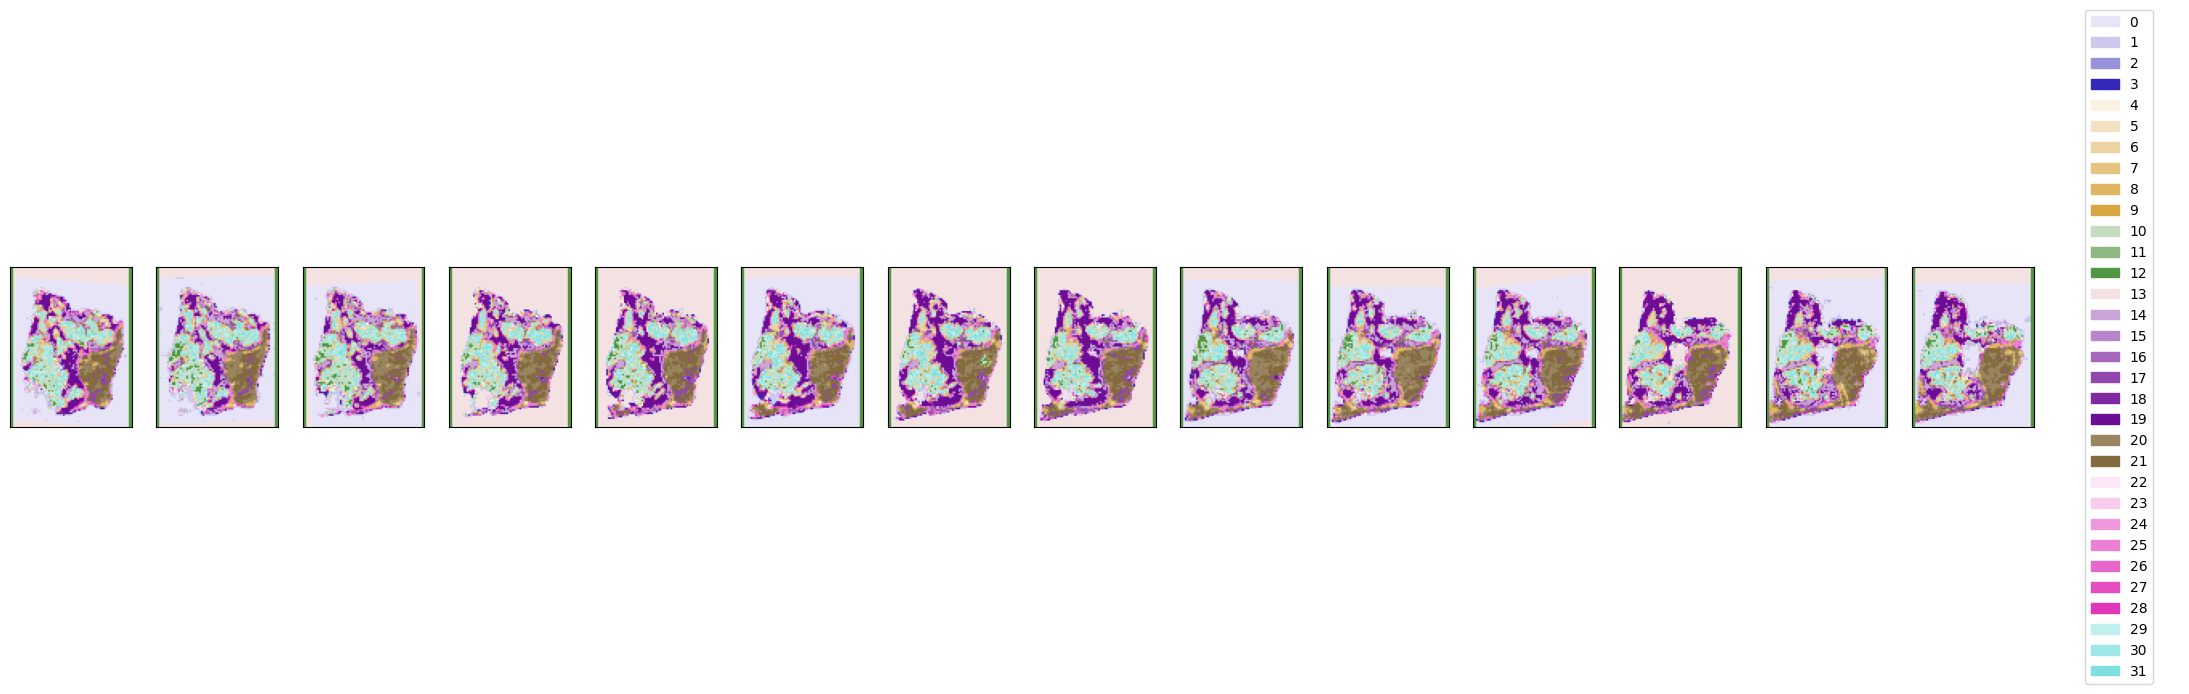

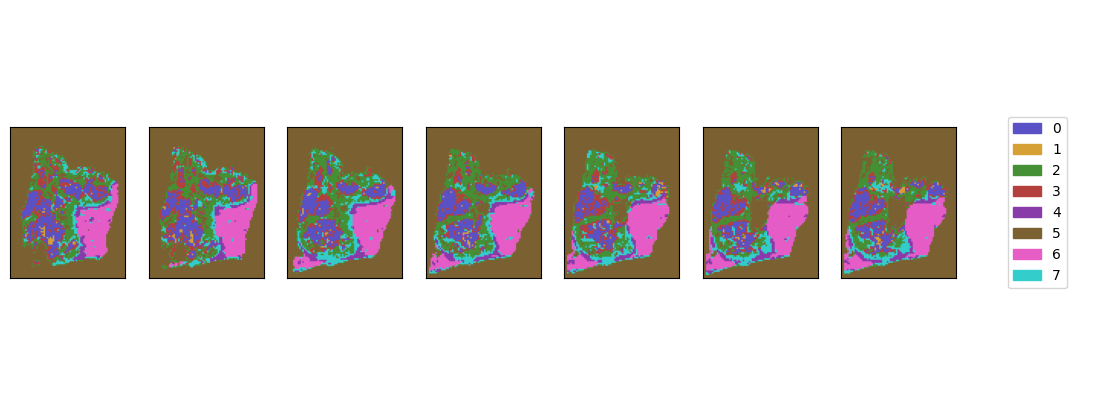

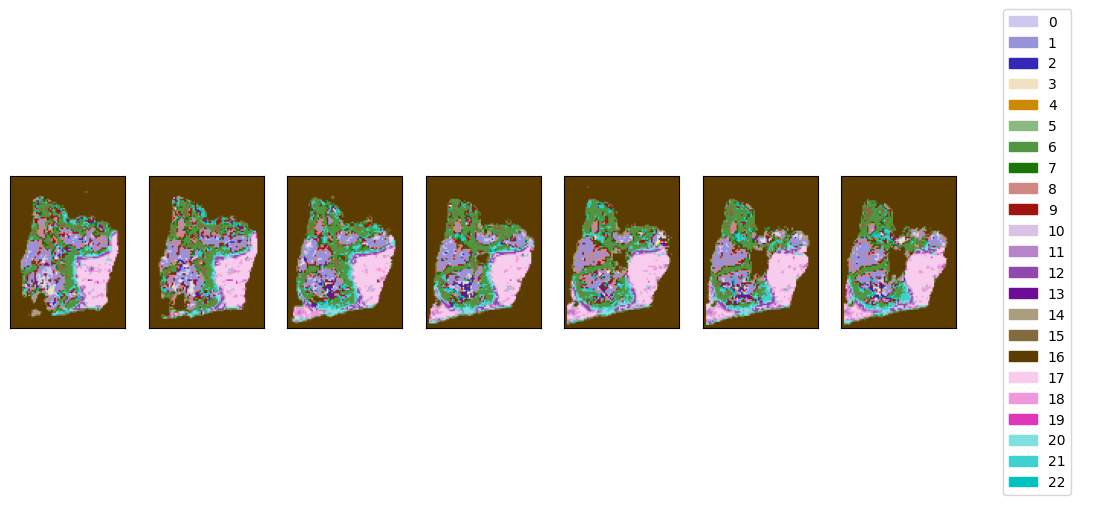

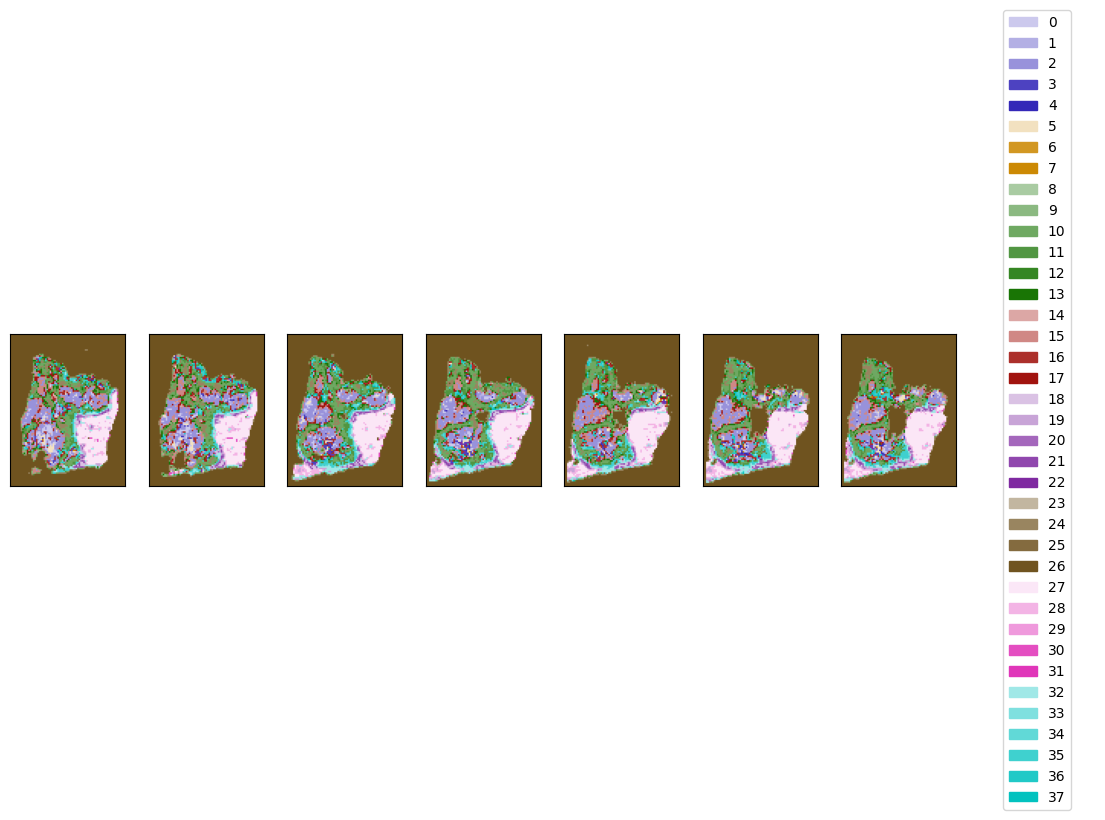

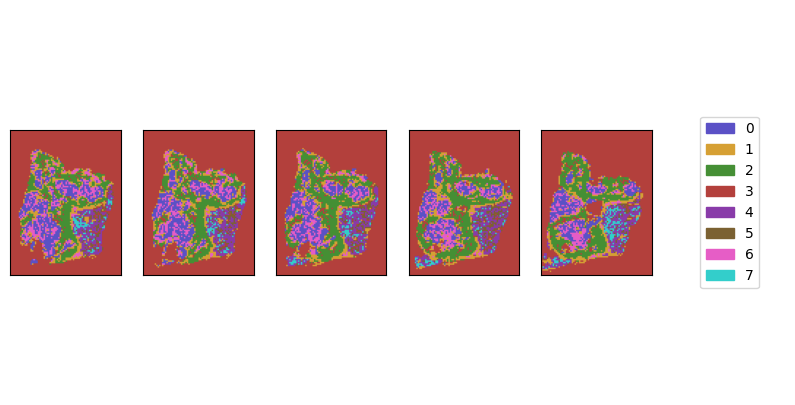

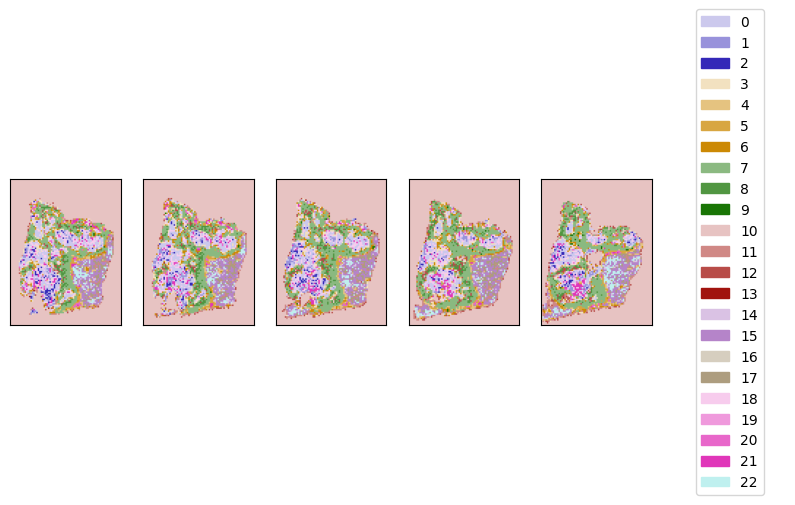

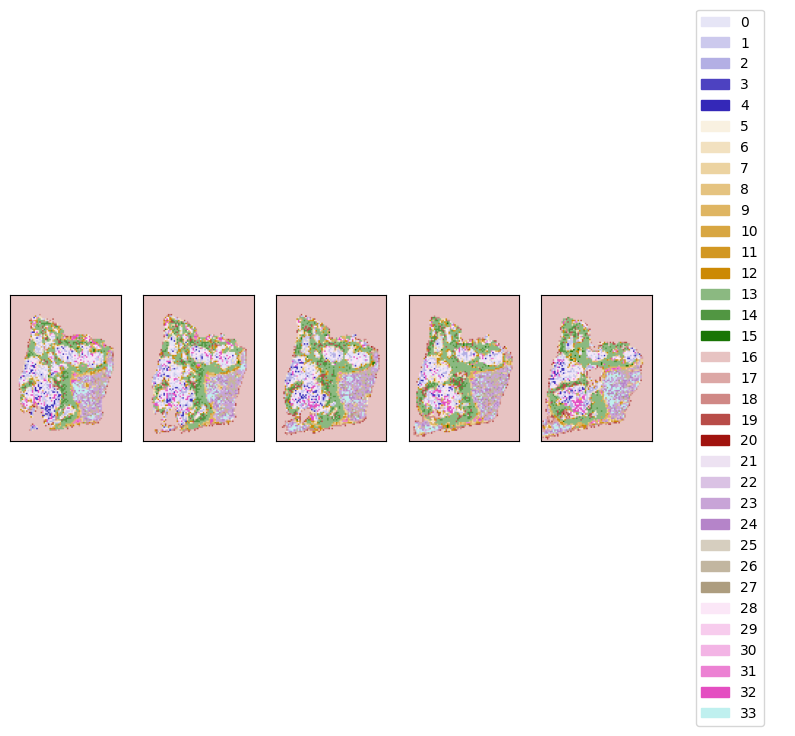

In [362]:
for dtype in mushroom.dtypes:
    for level in range(mushroom.num_levels):
        mushroom.display_clusters(dtype, level=level)
        plt.show()

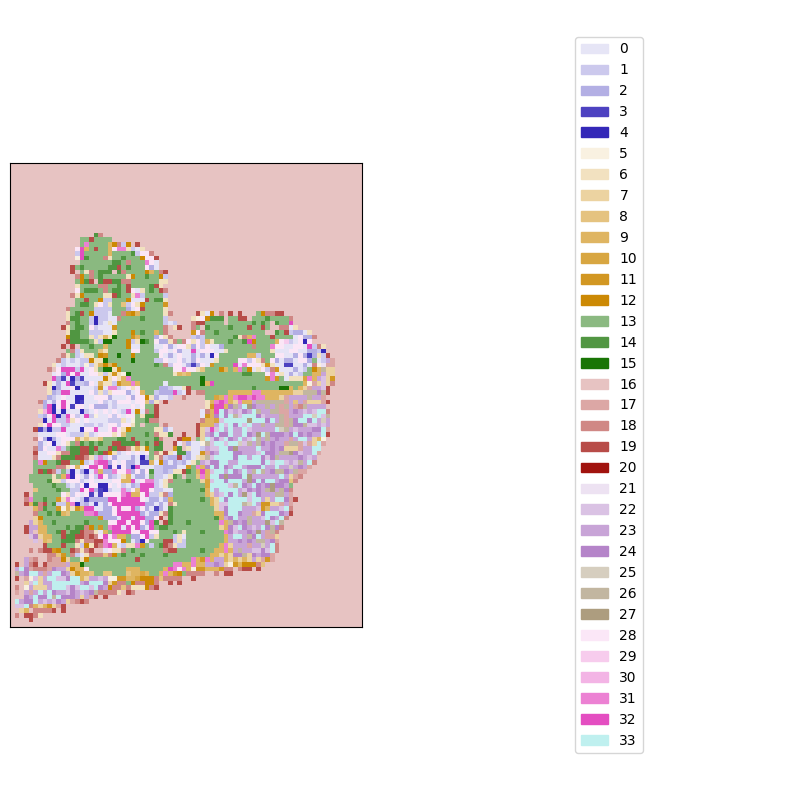

In [369]:
spore = mushroom.dtype_to_spore['xenium']
labeled = dtype_to_volume['xenium'][section_idx:section_idx + 1]
label_to_hierarchy = spore.cluster_to_agg[2]
vis_utils.display_clusters(
                labeled, label_to_hierarchy=label_to_hierarchy, preserve_indices=True, figsize=(10, 10))


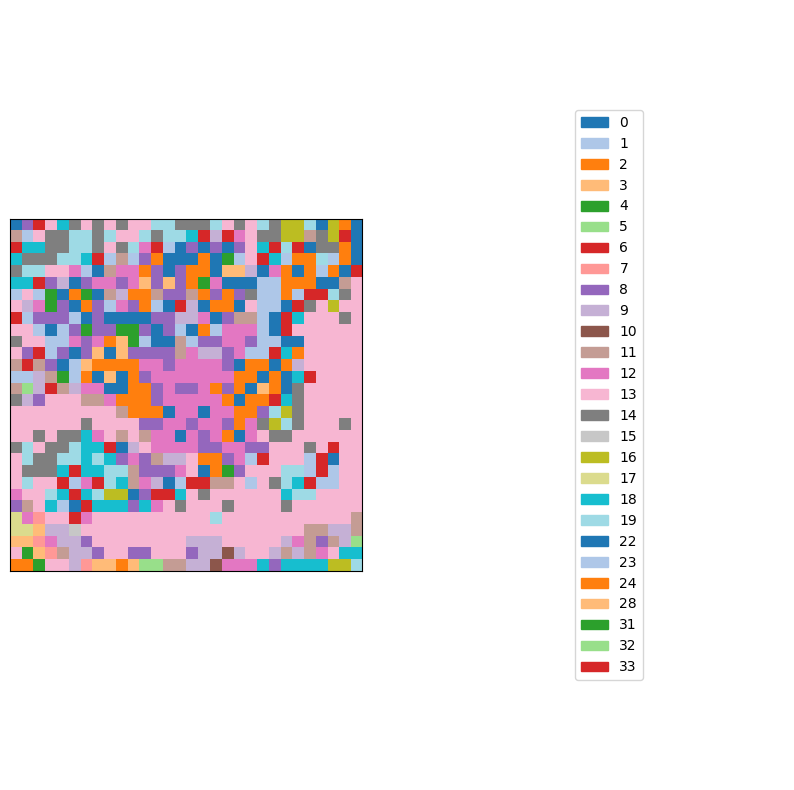

In [372]:
r1, r2, c1, c2 = 60, 90, 10, 40
labeled = dtype_to_volume['xenium'][section_idx:section_idx + 1, r1:r2, c1:c2]
label_to_hierarchy = spore.cluster_to_agg[2]
vis_utils.display_clusters(
                labeled, preserve_indices=True, figsize=(10, 10))

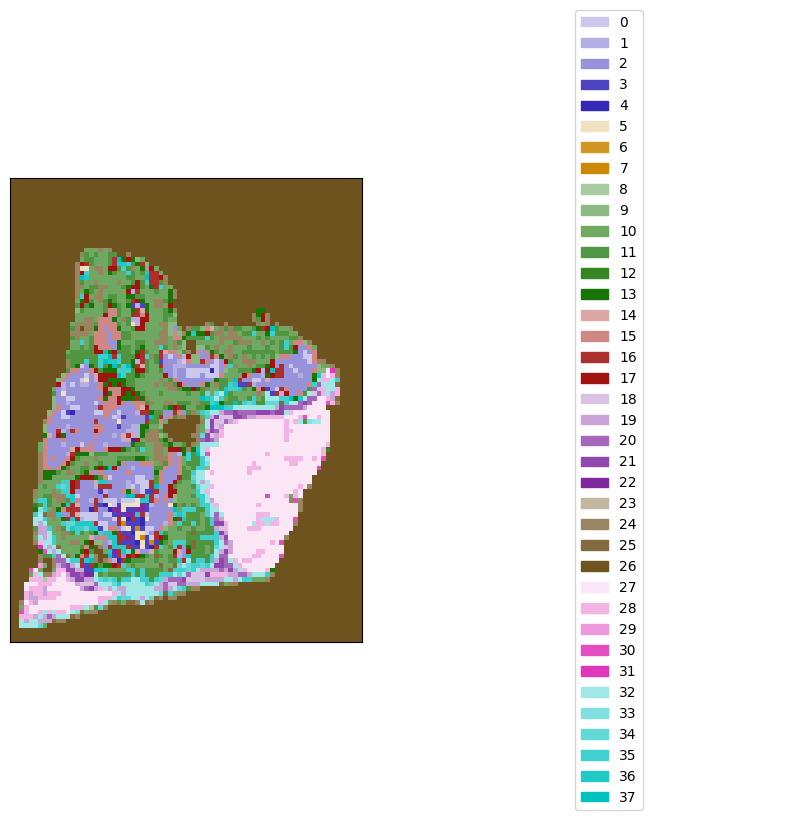

In [366]:
spore = mushroom.dtype_to_spore['multiplex']
labeled = dtype_to_volume['multiplex'][section_idx:section_idx + 1]
label_to_hierarchy = spore.cluster_to_agg[2]
vis_utils.display_clusters(
                labeled, label_to_hierarchy=label_to_hierarchy, preserve_indices=True, figsize=(10, 10))


In [381]:
case = 'HT397B1'


In [382]:
agg_f = agg[agg['case']==case]
agg_f

Fibroblast  Endothelial  Macrophage    T_cell    B_cell  Fibroblast_q0.75  \
3     2.114579     0.665736    1.319961  0.522284  2.770303             False   
14    8.282096     2.447612    1.407842  0.120450  0.399996              True   
5     3.735276     1.742978    0.829055  0.304213  1.427741             False   
7     4.491429     0.855804    1.736166  0.417999  1.764796             False   
15    6.793681     1.029535    1.020950  0.111486  0.358323              True   
12    4.963538     1.780519    0.777676  0.107614  0.434210              True   
0     0.355830     0.133912    0.025582  0.008103  0.034739             False   
6     1.265501     0.528486    4.175946  1.632743  5.759482             False   
16    3.274027     0.945076    0.601474  0.127066  0.793527             False   
11    4.550486     1.261283    3.911680  0.391405  1.597059             False   
13    7.437039     1.222580    1.575044  0.348522  1.340913              True   

    Endothelial_q0.75  Macrophage_q0.75  T_cell_q0.75  B_cell_q0.75  ...  \
3               False             False         False          True  ...   
14              False             False         False         False  ...   
5               False             False         False          True  ...   
7               False             False         False          True  ...   
15              False             False         False         False  ...   
12              False             False         False         False  ...   
0               False             False         False         False  ...   
6               False              True          True          True  ...   
16              False             False         False         False  ...   
11              False              True         False          True  ...   
13              False             False         False          True  ...   

    contact_frac     nbhd   range  renamed_nbhd     start      stop  \
3       0.148487   nbhd 3  item18        nbhd 0  0.000000  0.148487   
14      0.123358  nbhd 14  item19        nbhd 1  0.148487  0.271845   
5       0.079383   nbhd 5  item20        nbhd 2  0.271845  0.351228   
7       0.073101   nbhd 7  item21        nbhd 3  0.351228  0.424329   
15      0.071959  nbhd 15  item22        nbhd 4  0.424329  0.496288   
12      0.061108  nbhd 12  item23        nbhd 5  0.496288  0.557396   
0       0.058252   nbhd 0  item24        nbhd 6  0.557396  0.615648   
6       0.026842   nbhd 6  item25        nbhd 7  0.615648  0.642490   
16      0.024557  nbhd 16  item26        nbhd 8  0.642490  0.667047   
11      0.023986  nbhd 11  item27        nbhd 9  0.667047  0.691034   
13      0.022844  nbhd 13  item28       nbhd 10  0.691034  0.713878   

    nbhd_identifier  case_idx  nbhd_cluster  relabeled  
3    HT397B1_nbhd 3        -3     cluster 4  cluster 8  
14  HT397B1_nbhd 14        -3     cluster 0  cluster 1  
5    HT397B1_nbhd 5        -3     cluster 3  cluster 8  
7    HT397B1_nbhd 7        -3     cluster 3  cluster 7  
15  HT397B1_nbhd 15        -3     cluster 6  cluster 1  
12  HT397B1_nbhd 12        -3     cluster 1  cluster 7  
0    HT397B1_nbhd 0        -3     cluster 0  cluster 6  
6    HT397B1_nbhd 6        -3     cluster 1  cluster 4  
16  HT397B1_nbhd 16        -3     cluster 7  cluster 8  
11  HT397B1_nbhd 11        -3     cluster 8  cluster 7  
13  HT397B1_nbhd 13        -3     cluster 5  cluster 1  

[11 rows x 32 columns]

{14: (0.7752402921953095, 0.8583006535947711, 0.9368242983467897), 15: (0.41708573625528644, 0.6806305267204922, 0.8382314494425221), 13: (0.1271049596309112, 0.4401845444059977, 0.7074971164936563)}
{6: (0.79085854, 0.10184672, 0.313391)}
{0: [0.879288371597917, 0.8547361334955935, 0.7536320908522631]}
{7: (0.9881737793156479, 0.7713802383698578, 0.7526028450595924), 12: (0.9670280661284122, 0.40464436755094196, 0.6307574009996155), 11: (0.6775547866205306, 0.00392156862745098, 0.49347174163783164)}
{3: [0.8078041134595918, 0.8885512531505309, 0.7672165392583007], 5: [0.6564805738078419, 0.6293122033430302, 0.4313438935861518], 16: [0.5240017077585825, 0.33527875275329827, 0.2663529333982144]}


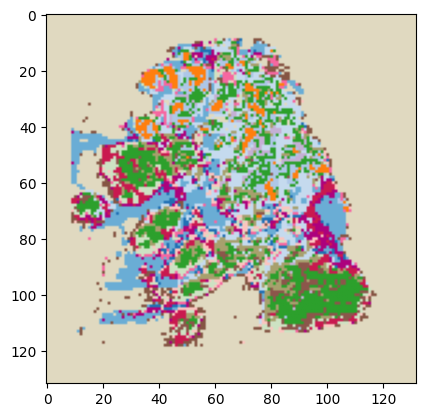

In [407]:
cmap = get_case_cmap(case)
rgb = get_nbhd_rgb(case, np.arange(case_to_exp[case]['visium'].shape[0]), cmap=cmap)
plt.imshow(rgb)

{14: (0.13042675893886968, 0.44415224913494805, 0.710326797385621), 15: (0.42274509803921567, 0.684075355632449, 0.8398923490965013), 13: (0.7786851211072664, 0.8602998846597462, 0.9379930795847751)}
{6: (0.79085854, 0.10184672, 0.313391)}
{0: [0.879288371597917, 0.8547361334955935, 0.7536320908522631]}
{7: (0.9881737793156479, 0.7713802383698578, 0.7526028450595924), 12: (0.9670280661284122, 0.40464436755094196, 0.6307574009996155), 11: (0.6775547866205306, 0.00392156862745098, 0.49347174163783164)}
{3: (0.9921568627450981, 0.814640522875817, 0.6336024605920799), 5: (0.9914186851211073, 0.550726643598616, 0.23277201076509035), 16: (0.8462745098039215, 0.28069204152249133, 0.004106113033448673)}


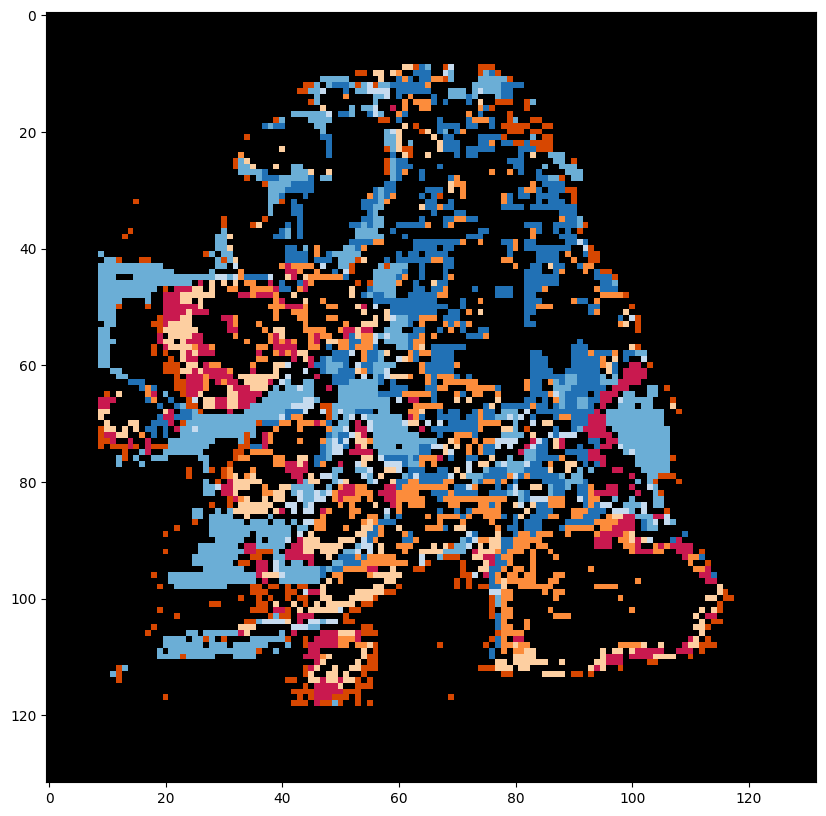

In [420]:
fig, axs = plt.subplots(figsize=(10, 10))
labels = [14,15,13, 6, 3, 5, 16]
cmap = get_case_cmap(case)
rgb = get_nbhd_rgb(case, labels, cmap=cmap, )
# rgb = overlay_tumor(case, rgb)
plt.imshow(rgb)

In [416]:
rgba.max()

255

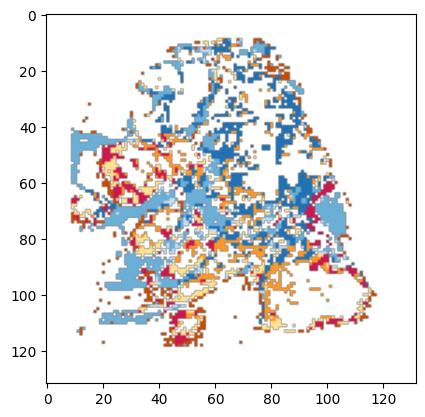

In [417]:
m = rgb.sum(-1) == 0
alpha = np.ones(m.shape)
alpha[m] = 0
alpha = np.expand_dims(alpha, -1)
rgba = np.concatenate((rgb, alpha), -1)
rgba *= 255.
rgba = rgba.astype('uint8')
plt.imshow(rgba)
skimage.io.imsave('/data/estorrs/sandbox/ht397b1_alpha.png', rgba)

{14: (0.7752402921953095, 0.8583006535947711, 0.9368242983467897), 15: (0.41708573625528644, 0.6806305267204922, 0.8382314494425221), 13: (0.1271049596309112, 0.4401845444059977, 0.7074971164936563)}
{6: (0.79085854, 0.10184672, 0.313391)}
{0: [0.879288371597917, 0.8547361334955935, 0.7536320908522631]}
{7: (0.9881737793156479, 0.7713802383698578, 0.7526028450595924), 12: (0.9670280661284122, 0.40464436755094196, 0.6307574009996155), 11: (0.6775547866205306, 0.00392156862745098, 0.49347174163783164)}
{3: [0.8078041134595918, 0.8885512531505309, 0.7672165392583007], 5: [0.6564805738078419, 0.6293122033430302, 0.4313438935861518], 16: [0.5240017077585825, 0.33527875275329827, 0.2663529333982144]}


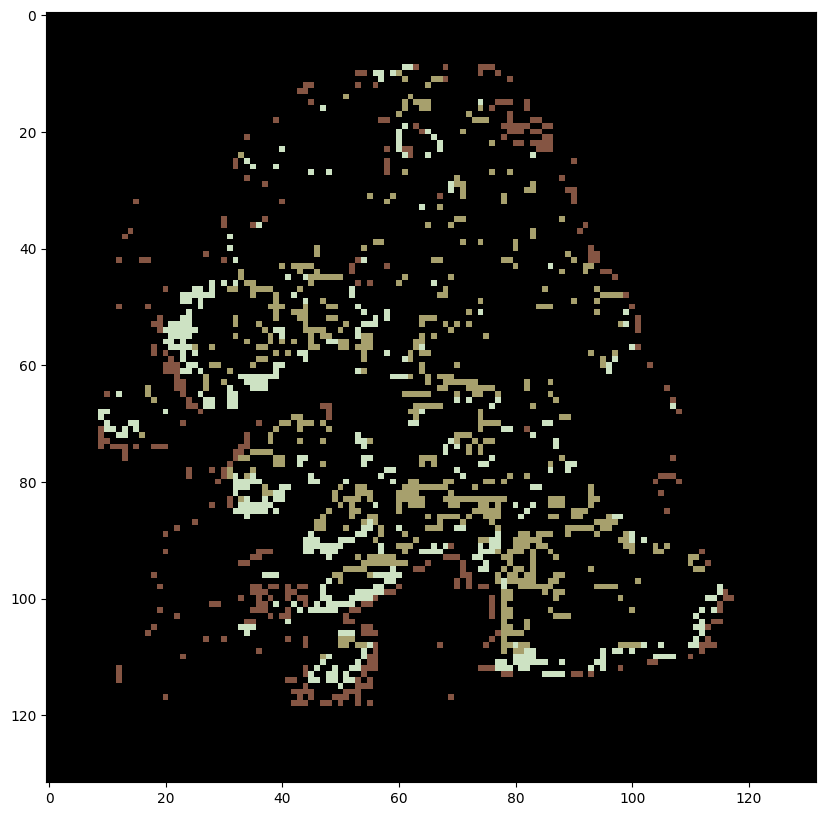

In [411]:
fig, axs = plt.subplots(figsize=(10, 10))
labels = [3, 5, 16]
cmap = get_case_cmap(case)
rgb = get_nbhd_rgb(case, labels, cmap=cmap, )
# rgb = overlay_tumor(case, rgb)
plt.imshow(rgb)

In [393]:
cmap

[(0.879288371597917, 0.8547361334955935, 0.7536320908522631),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.8078041134595918, 0.8885512531505309, 0.7672165392583007),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.6564805738078419, 0.6293122033430302, 0.4313438935861518),
 (0.79085854, 0.10184672, 0.313391),
 (0.9881737793156479, 0.7713802383698578, 0.7526028450595924),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.6775547866205306, 0.00392156862745098, 0.49347174163783164),
 (0.9670280661284122, 0.40464436755094196, 0.6307574009996155),
 (0.34351942619215814, 0.3706877966569699, 0.5686561064138481),
 (0.7611058395410276, 0.897713045748989, 0.8454349452836011),
 (0.47599829224141754, 0.6647212472467017, 0.7336470666017856),
 (0.5240017077585825, 0.3

In [418]:
sns.color_palette(cmap, )

[(0.879288371597917, 0.8547361334955935, 0.7536320908522631),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.996078431372549, 0.8892425990003844, 0.5665974625144176),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.9949711649365629, 0.5974778931180315, 0.15949250288350636),
 (0.79085854, 0.10184672, 0.313391),
 (0.9881737793156479, 0.7713802383698578, 0.7526028450595924),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.6775547866205306, 0.00392156862745098, 0.49347174163783164),
 (0.9670280661284122, 0.40464436755094196, 0.6307574009996155),
 (0.7786851211072664, 0.8602998846597462, 0.9379930795847751),
 (0.13042675893886968, 0.44415224913494805, 0.710326797385621),
 (0.42274509803921567, 0.684075355632449, 0.8398923490965013),
 (0.7952941176470588, 0.2958246828143022, 0.008027681660899655),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
 (0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
 (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
 (0.4823529411764706, 0.2549019607843137, 0.45098039215686275),
 (0.6470588235294118, 0.3176470588235294, 0.5803921568627451),
 (0.807843137254902, 0.42745098039215684, 0.7411764705882353),
 (0.8705882352941177, 0.6196078431372549, 0.8392156862745098),
 (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]